In [8]:
import cv2
import numpy as np
from pathlib import Path
from boxmot import DeepOCSORT
from ultralytics import YOLO

In [14]:
def initialize_tracker(model_weights, device='cuda:0', fp16=True):
    """
    Initialize the DeepOCSORT tracker with the given model weights and device.
    """
    tracker = DeepOCSORT(
        model_weights=model_weights,
        device=device,
        fp16=fp16
    )
    return tracker

def initialize_yolo(model_path):
    """
    Initialize the YOLO object detector with the given model path.
    """
    yolov8 = YOLO(model_path)
    return yolov8

In [15]:
class Rect:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    
    @property
    def bottom_center(self):
        return ((self.x1 + self.x2) // 2, self.y2)
    
    @property
    def width(self):
        return self.x2 - self.x1

class Color:
    def __init__(self, b, g, r):
        self.b = b
        self.g = g
        self.r = r

    @property
    def bgr_tuple(self):
        return (self.b, self.g, self.r)

def draw_ellipse(image, rect, color, thickness=2):
    center = rect.bottom_center
    axes = (int(rect.width), int(0.35 * rect.width))
    cv2.ellipse(
        image,
        center,
        axes,
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


In [77]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sys
import sklearn
from collections import Counter

def get_color_histogram(image, bbox):
    """
    Get the color histogram within a specific portion of the bounding box in the HSV color space.
    """
    x1, y1, x2, y2 = bbox
    
    height = y2 - y1
    width = x2 - x1
    
    new_y1 = y1 + int(0.1 * height)
    new_y2 = y1 + int(0.5 * height)
    
    new_x1 = x1 + int(0.2 * width)
    new_x2 = x2 - int(0.2 * width)
    
    roi = image[new_y1:new_y2, new_x1:new_x2]
    
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    
    a_channel = roi_lab[:,:,1]
    _, mask = cv2.threshold(a_channel, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Using the mask to exclude green pixels in LAB
    roi_lab_filtered = roi_lab.copy()
    roi_lab_filtered[mask != 255] = 0
    
    non_black_pixels = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    color_counter = Counter(map(tuple, non_black_pixels))
    most_common_color = color_counter.most_common(1)[0][0]
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    
    hist = cv2.calcHist([roi_lab], [0, 1], None, [8, 8], [0, 180, 0, 256])
    
    
    cv2.normalize(hist, hist)
    
    # Displaying the images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(roi_lab, cv2.COLOR_Lab2RGB))
    plt.title("Filtered LAB")
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(roi_lab_filtered, cv2.COLOR_Lab2RGB))
    plt.title("Filtered LAB")
    
    plt.subplot(1, 3, 3)
    plt.imshow([[most_common_color]])
    plt.title("Most Common Color")
    plt.axis('off')
    
    plt.show()
    return hist.flatten()

def get_mean_color(image, bbox):
    """
    Get the mean color within a specific portion of the bounding box in both RGB and LAB color spaces,
    excluding green pixels.
    """
    x1, y1, x2, y2 = bbox
    
    # Adjusting the bounding box to focus on the upper part
    height = y2 - y1
    width = x2 - x1
    
    new_y1 = y1 + int(0.17 * height)
    new_y2 = y1 + int(0.5 * height)
    new_x1 = x1 + int(0.2 * width)
    new_x2 = x2 - int(0.2 * width)

    adjusted_bbox = (new_x1, new_y1, new_x2, new_y2)
    
    # Extracting the ROI based on the adjusted bounding box
    roi = image[adjusted_bbox[1]:adjusted_bbox[3], adjusted_bbox[0]:adjusted_bbox[2]]
    
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    
    # Getting the A channel and applying threshold
    a_channel = roi_lab[:,:,1]
    _, mask = cv2.threshold(a_channel, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Using the mask to exclude green pixels in LAB
    roi_lab_filtered = roi_lab.copy()
    roi_lab_filtered[mask != 255] = 0
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]

    # Calculate the mean of each channel
    if non_zero_subarrays.size > 0:
        mean_color_lab = non_zero_subarrays.mean(axis=0)
        
        
    color_counter = Counter(map(tuple, non_zero_subarrays))
    most_common_color_lab = np.array(color_counter.most_common(1)[0][0], dtype=np.uint8)

    most_common_color_bgr = cv2.cvtColor(np.array([[most_common_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2BGR)[0][0]

    # Displaying the images
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(roi_lab, cv2.COLOR_Lab2RGB))
    plt.title("Original LAB")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(roi_lab_filtered, cv2.COLOR_Lab2RGB))
    plt.title("Filtered LAB")
    
    plt.subplot(1, 3, 3)
    plt.imshow([[cv2.cvtColor(np.array([[mean_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2RGB)[0][0]]])
    plt.title("Most Common Color")
    plt.axis('off')
    
    plt.show()
    
    return most_common_color_lab, mean_color_lab

def perform_kmeans_clustering(colors, initial_centroids=None, max_iter=10):
    """
    Perform k-means clustering on the given color data.
    """
    colors[:,1:3] *= 4
    if initial_centroids is not None:
        kmeans = KMeans(n_clusters=2, init=initial_centroids, random_state=0, n_init=1, max_iter=max_iter).fit(colors)
    else:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(colors)
        initial_centroids = kmeans.cluster_centers_
    
    return kmeans.labels_, initial_centroids

In [78]:
def process_video(input_file, output_file, tracker, yolov8, conf=0.3):
    """
    Process the input video, perform object detection and tracking, and save the results to the output video.
    """
    input_video = cv2.VideoCapture(input_file)
    width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = input_video.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
    
    thickness = 2
    fontscale = 0.5
    counter = 0
    
    # Function to get unique colors for each class id
    def get_color(cls_id):
        np.random.seed(cls_id)
        return tuple(np.random.randint(0, 255, 3).tolist())
    
    plt.figure(figsize=(10, 5))

    plt.figure(figsize=(10, 5))

    initial_centroids = None
    counter = 1
    while True:
        print(counter)
        counter += 1
        ret, im = input_video.read()
        if not ret:
            break

        predicted = yolov8.predict(im, conf=conf)
        dets = predicted[0].boxes.data.cpu().numpy()
        tracks = tracker.update(dets, im)
        xyxys = tracks[:, 0:4].astype('int')
        ids = tracks[:, 4].astype('int')
        clss = tracks[:, 6].astype('int')

        if tracks.shape[0] != 0:
            player_mean_colors = [get_mean_color(im, xyxy)[1] for xyxy, cls in zip(xyxys, clss) if cls == 1]
            #player_mean_colors = [get_color_histogram(im, xyxy) for xyxy, cls in zip(xyxys, clss) if cls == 1]
            if len(player_mean_colors) > 1:
                player_mean_colors = np.array(player_mean_colors)
                labels, initial_centroids = perform_kmeans_clustering(player_mean_colors, initial_centroids)
                
                # Plotting the results (optional)
                """
                plt.subplot(1, 2, 1)
                plt.scatter(player_mean_colors[:, 1], player_mean_colors[:, 2], c=player_mean_colors / 255.0)
                plt.title('Original Colors')

                plt.subplot(1, 2, 2)
                plt.scatter(player_mean_colors[labels == 0][:, 1], player_mean_colors[labels == 0][:, 2], c='blue', marker='o')
                plt.scatter(player_mean_colors[labels == 1][:, 1], player_mean_colors[labels == 1][:, 2], c='red', marker='x')
                plt.title('Clustered Colors')

                plt.show()
                """
                    
            for xyxy, id, cls, label in zip(xyxys, ids, clss, labels):
                
                if cls == 1:  # Modify this condition as per your actual player class ID
                    # Adjusting the bounding box to focus on the upper part
                    x1, y1, x2, y2 = xyxy
                    height = y2 - y1
                    width = x2 - x1

                    new_y1 = y1 + int(0.17 * height)
                    new_y2 = y1 + int(0.5 * height)
                    new_x1 = x1 + int(0.2 * width)
                    new_x2 = x2 - int(0.2 * width)

                    # Visualize the adjusted bounding box
                    cv2.rectangle(im, (new_x1, new_y1), (new_x2, new_y2), (255, 0, 0), 2)
                
                
                # Convert bounding box coordinates to Rect object
                rect = Rect(xyxy[0], xyxy[1], xyxy[2], xyxy[3])
                
                if cls == 1:
                    cls = cls + label
                
                # Get a unique color for each class
                color = Color(*get_color(cls))

                # Draw an ellipse at the bottom of the bounding box
                draw_ellipse(im, rect, color, thickness)
                
                # Place ID text just above the ellipse
                cv2.putText(
                    im,
                    f'{id}',
                    (rect.bottom_center[0] - 10, rect.bottom_center[1] - int(0.35 * rect.width) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    fontscale,
                    color.bgr_tuple,
                    thickness
                )
                
                
        out.write(im)

    input_video.release()
    out.release()
    cv2.destroyAllWindows()


2023-10-12 17:35:32.644 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:207 - Successfully loaded pretrained weights from "osnet_x0_25_msmt17.pt"
2023-10-12 17:35:32.646 | WARNING  | boxmot.appearance.reid_model_factory:load_pretrained_weights:211 - The following layers are discarded due to unmatched keys or layer size: ('classifier.weight', 'classifier.bias')


2sec_tracking1_output.mp4
1



0: 1120x1984 1 ball, 22 players, 20.0ms
Speed: 11.7ms preprocess, 20.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1120, 1984)


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

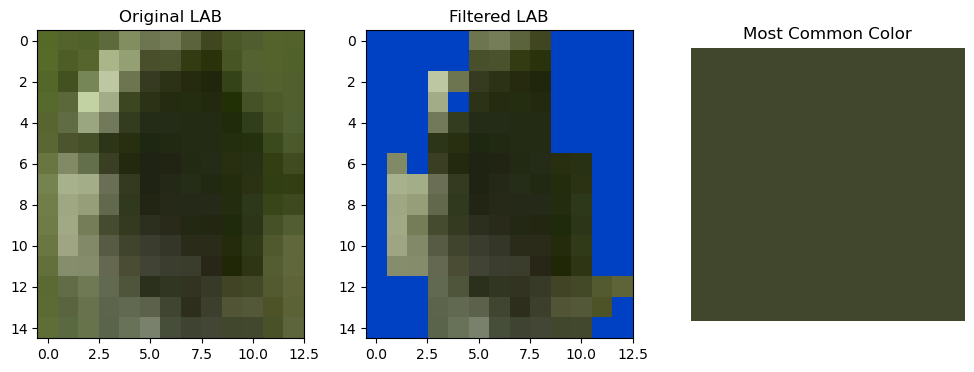

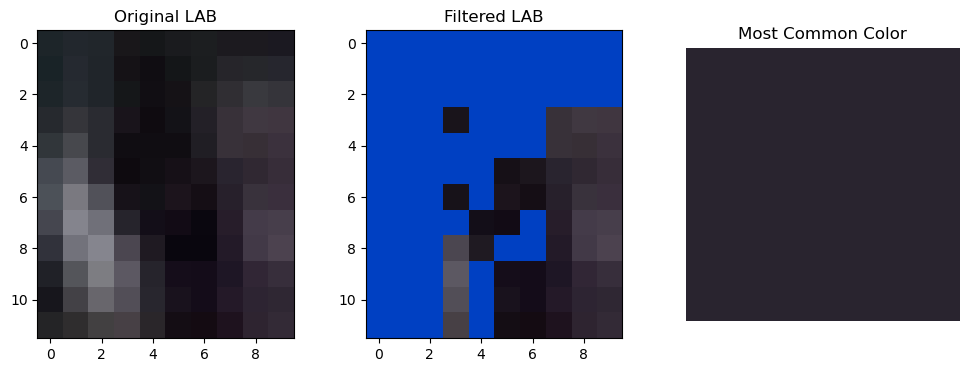

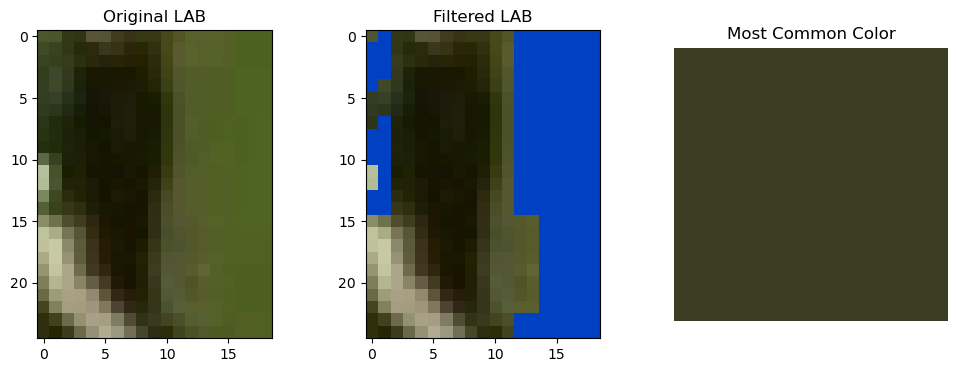

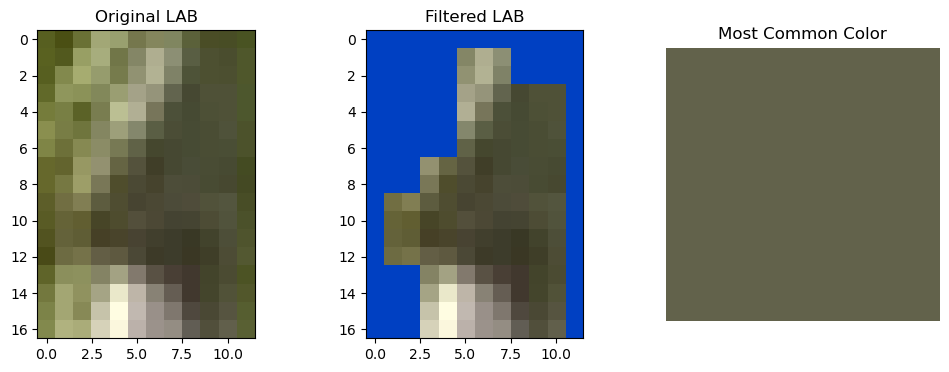

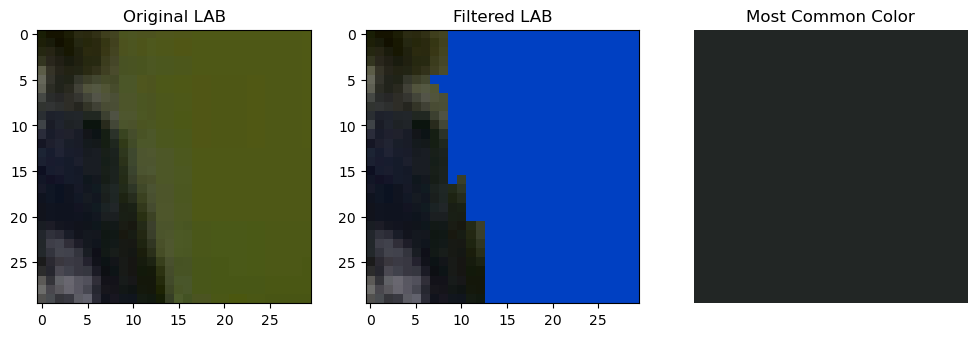

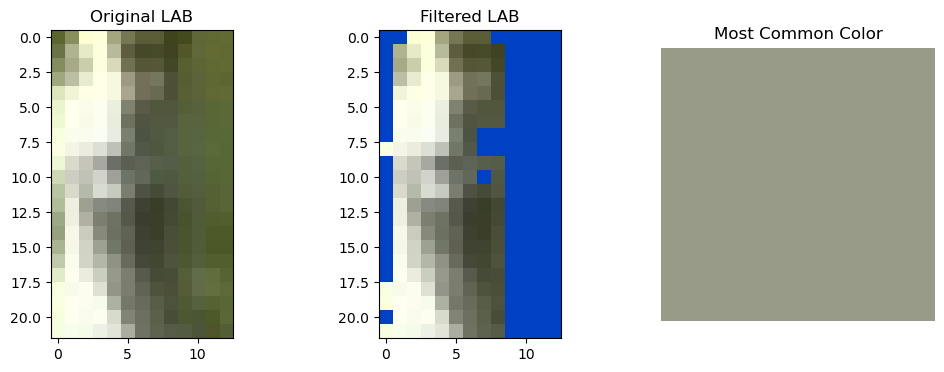

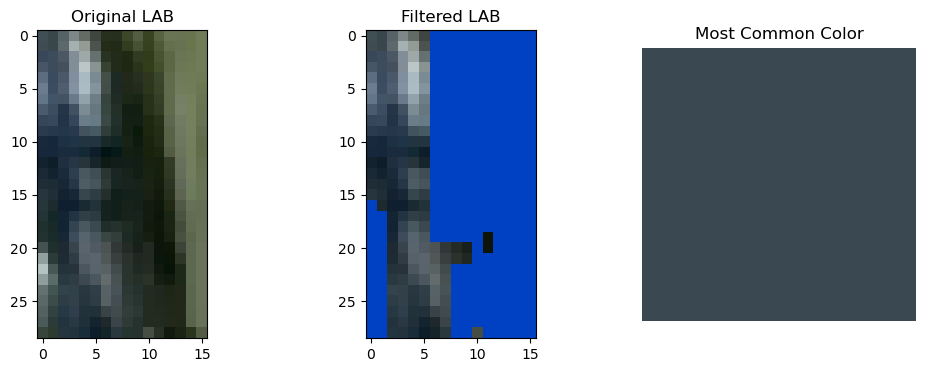

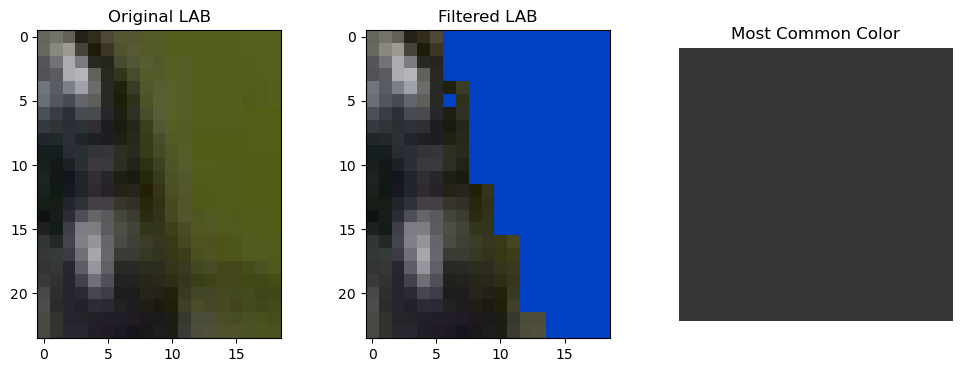

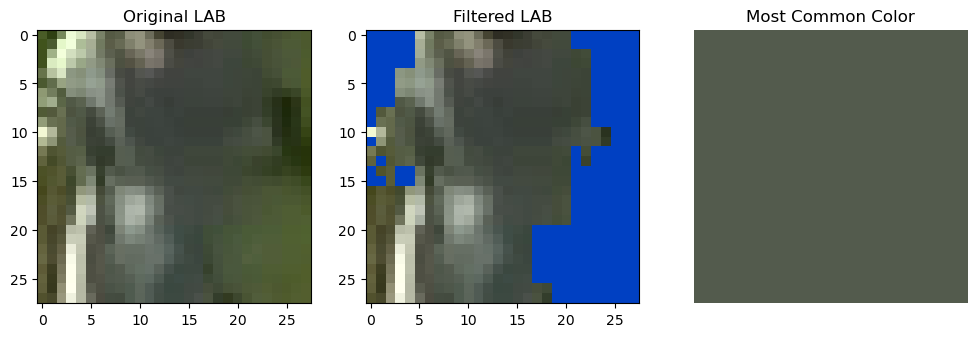

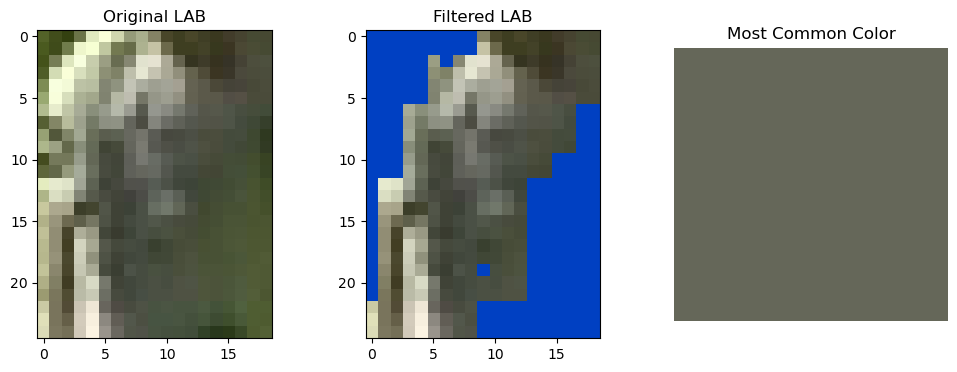

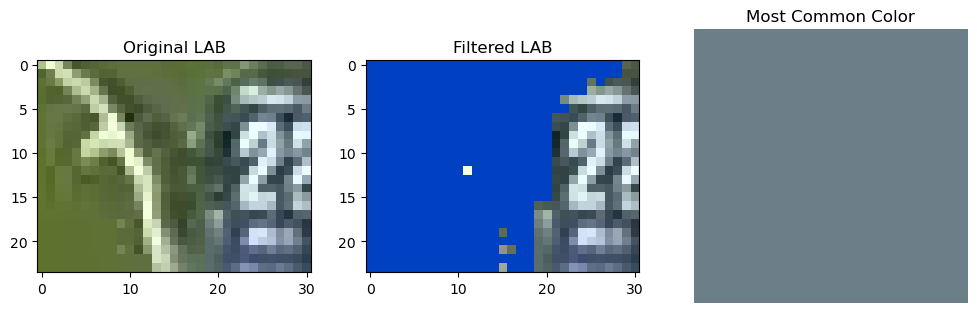

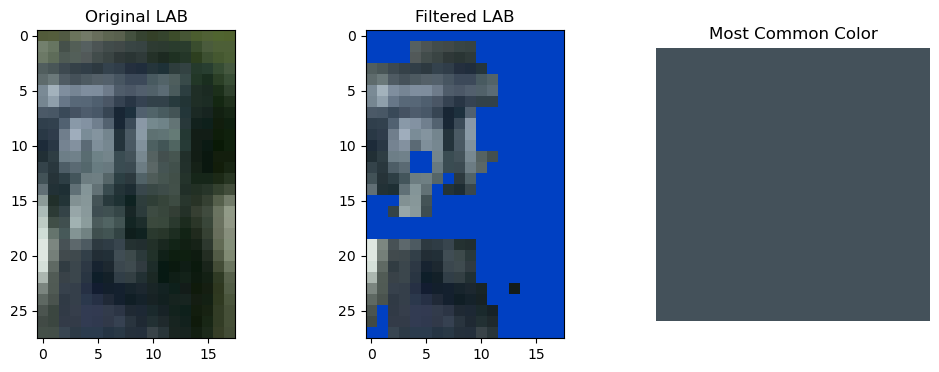

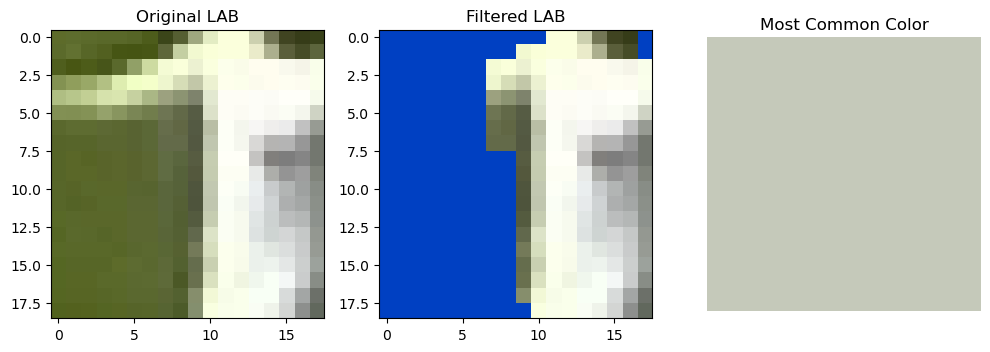

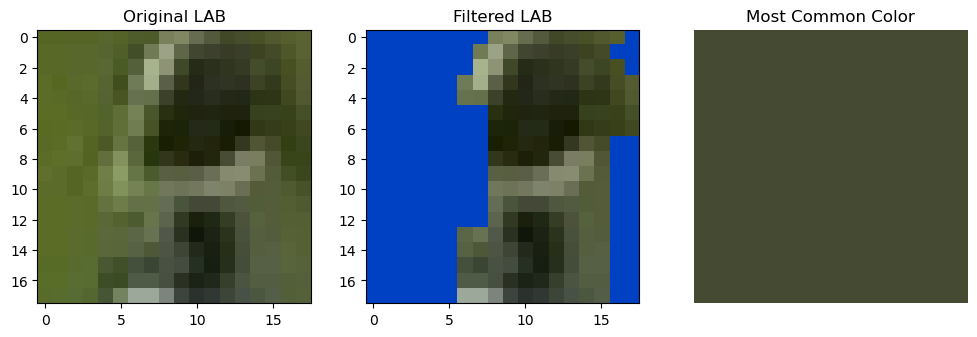

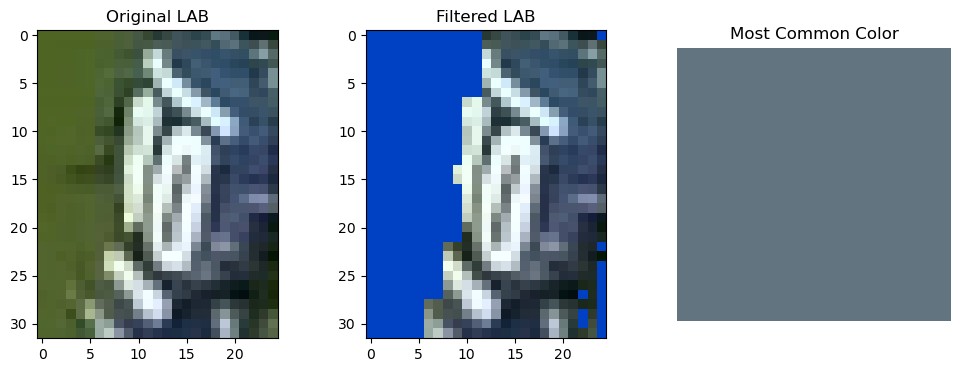

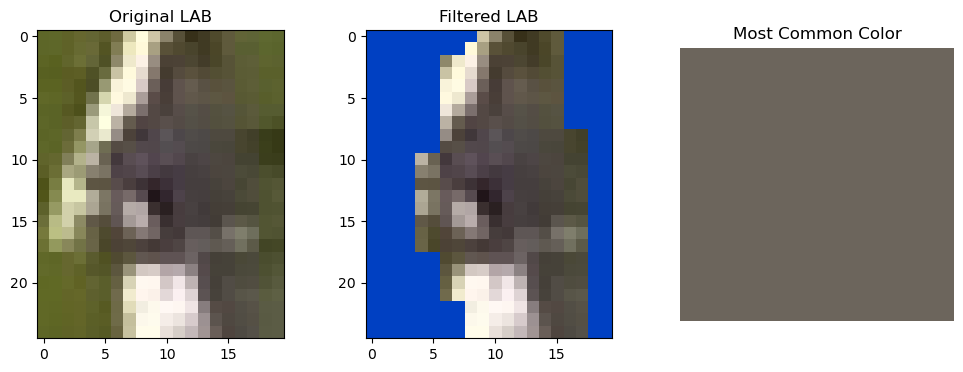

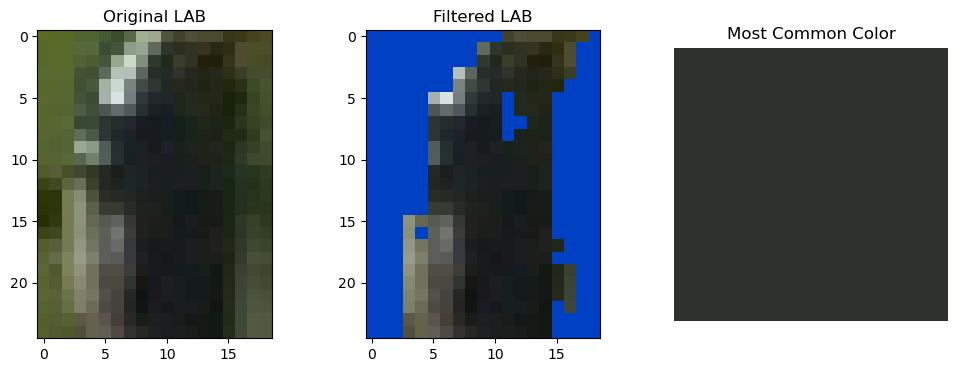

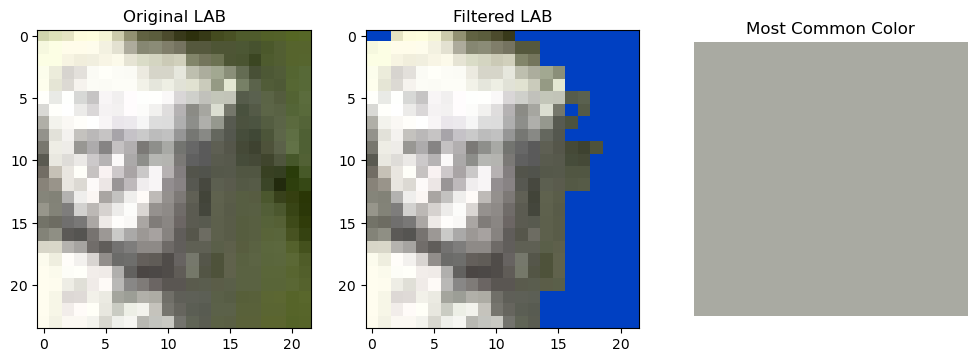

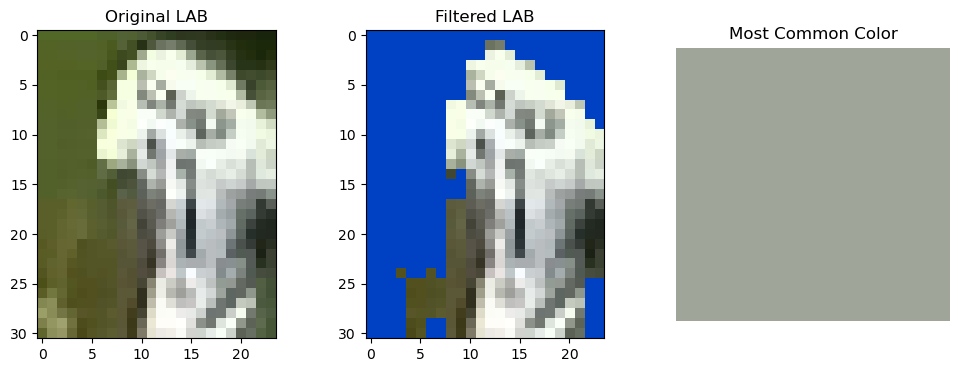

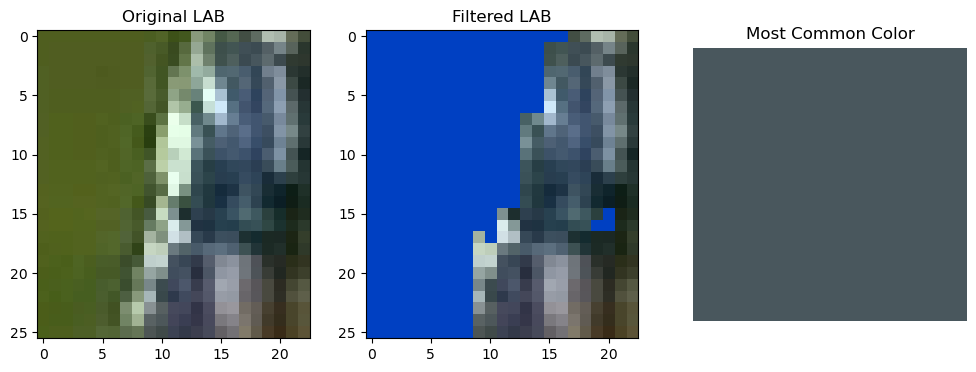

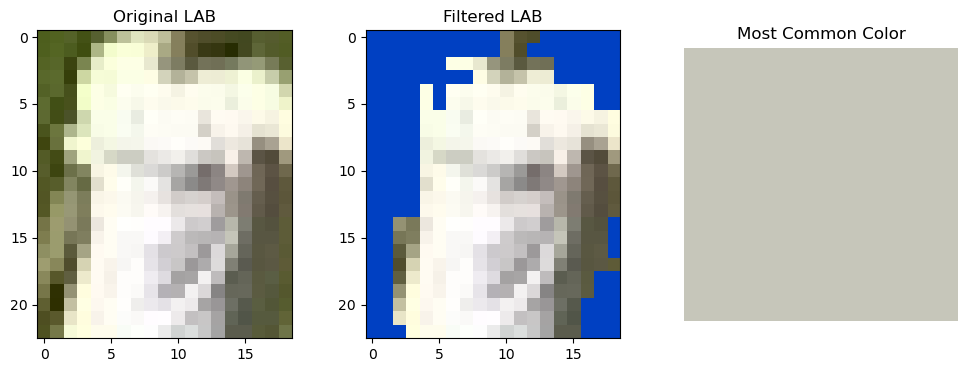

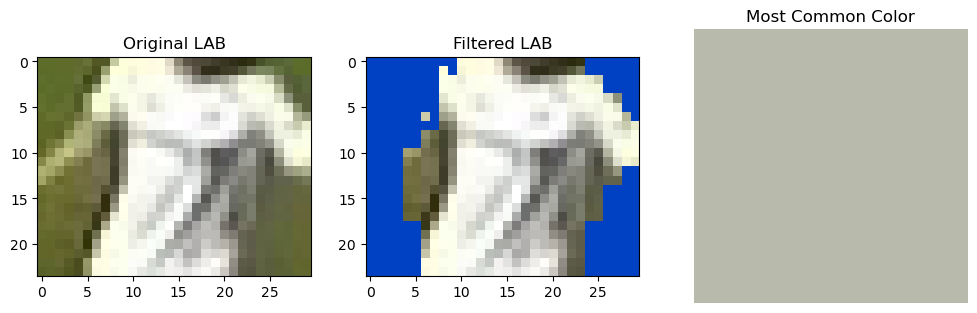

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f908d790>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f908d790>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.5ms
Spe

2


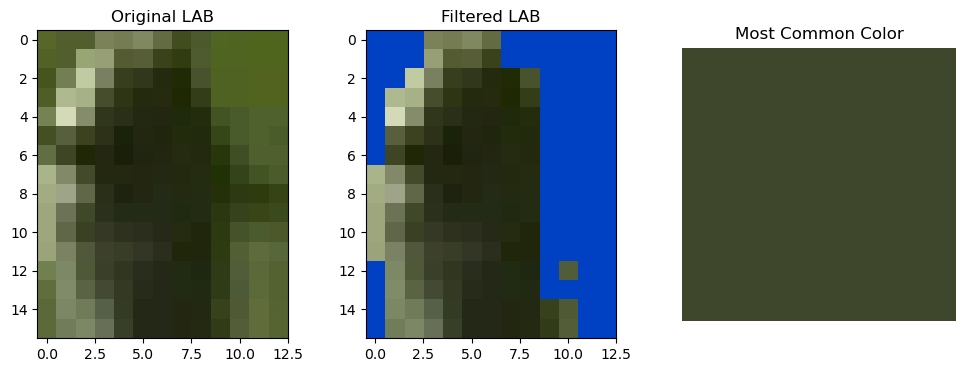

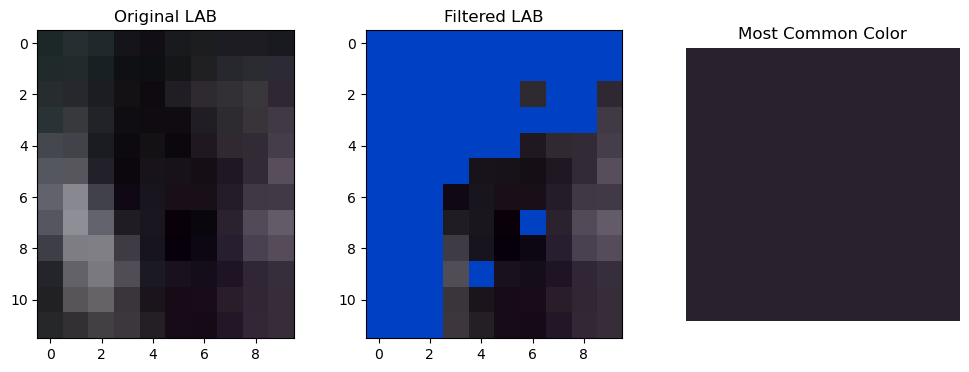

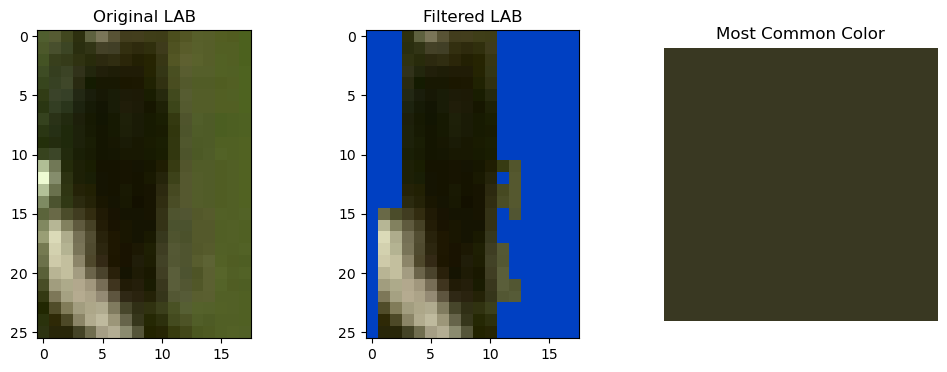

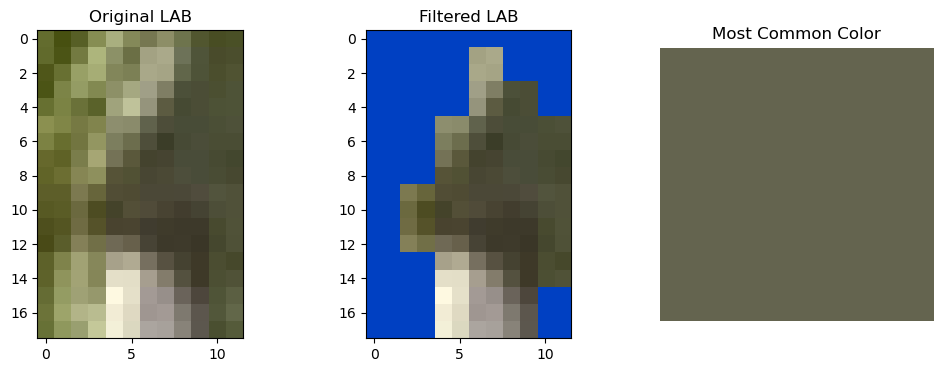

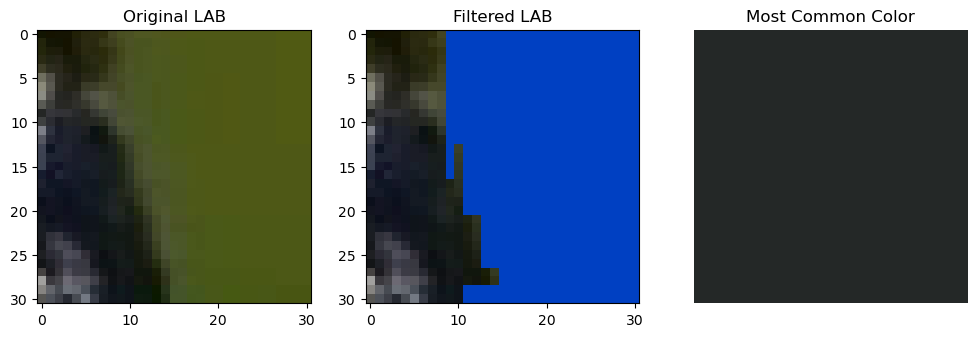

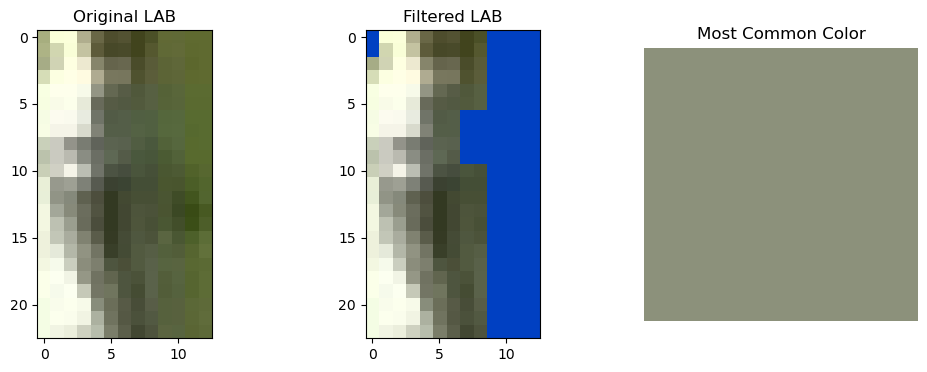

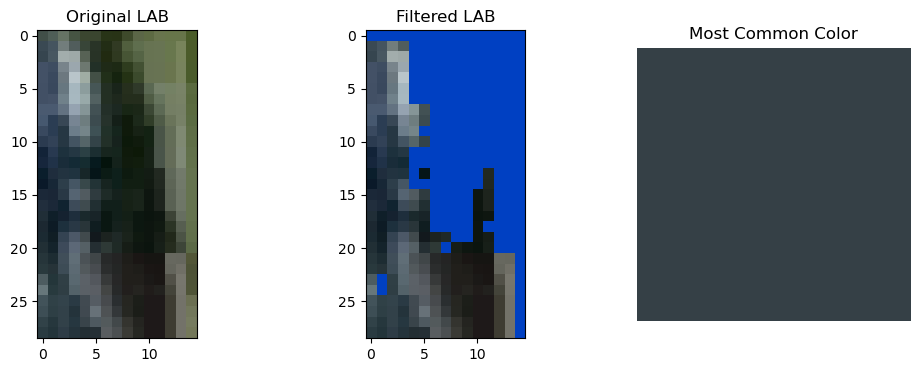

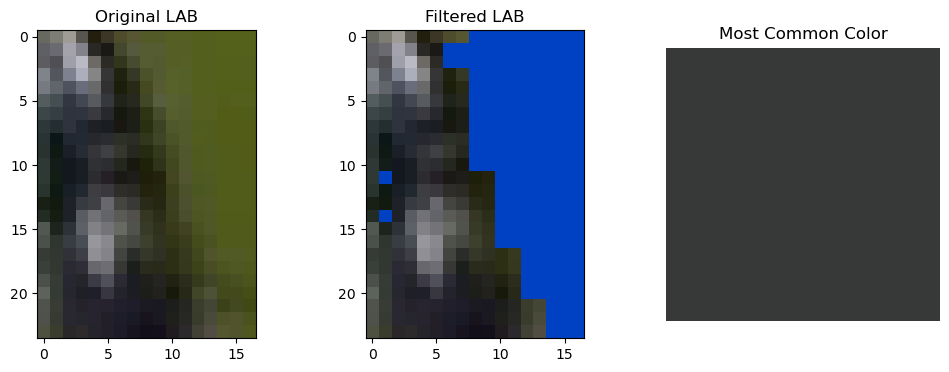

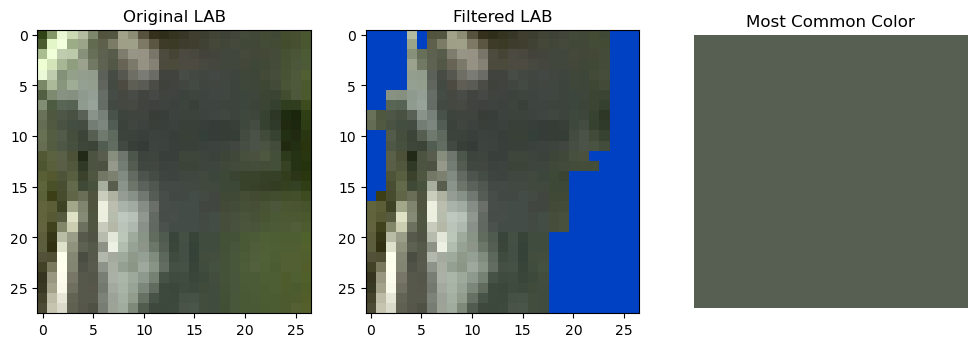

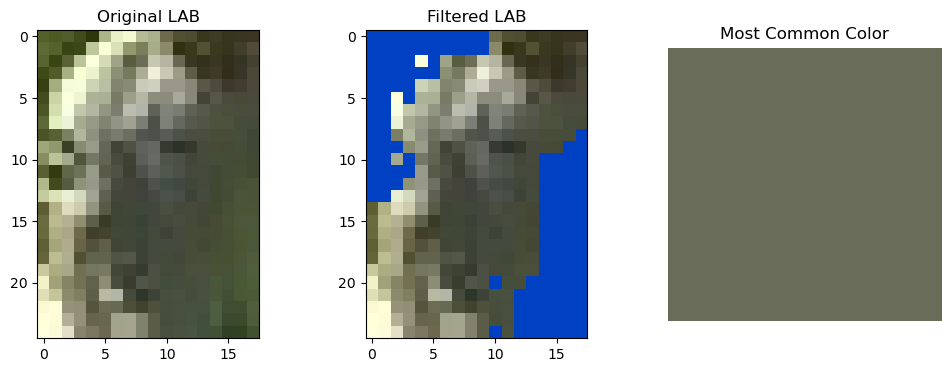

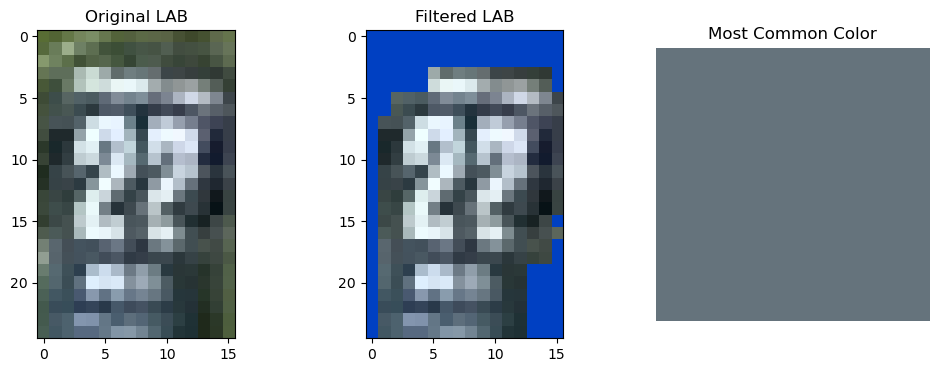

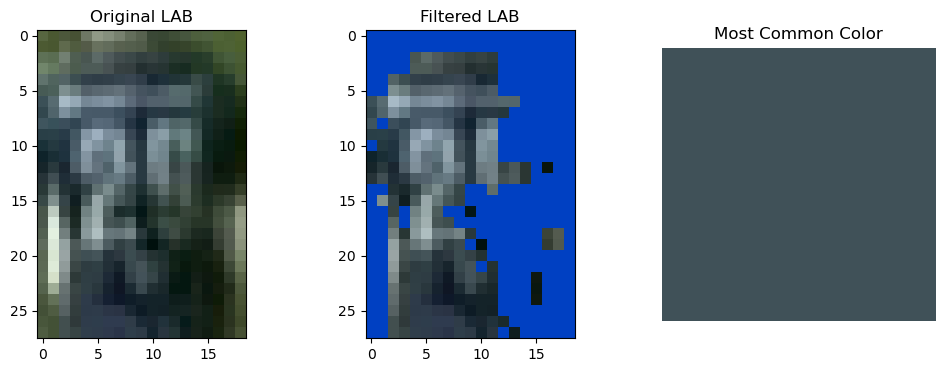

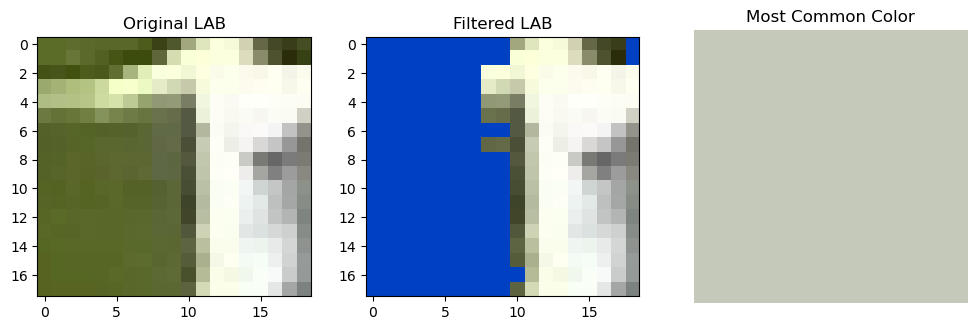

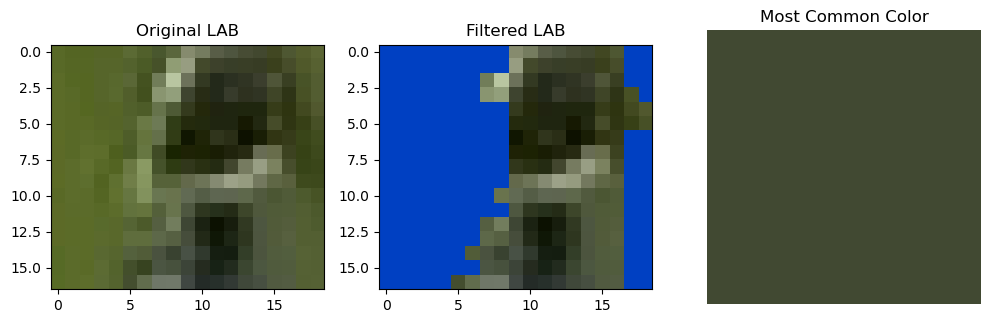

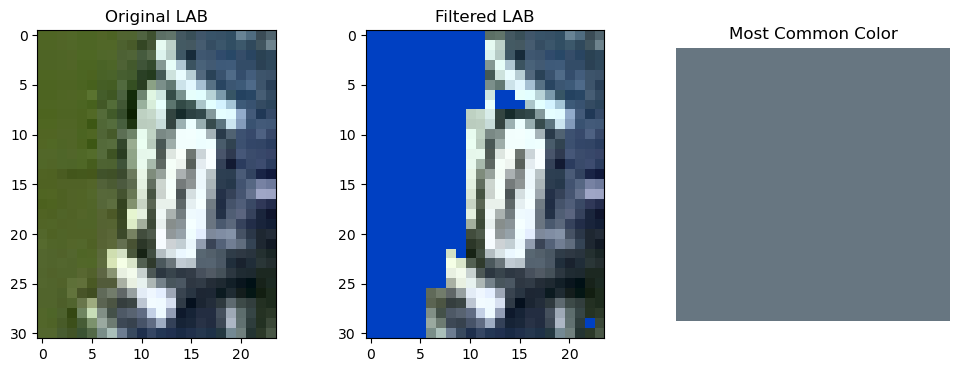

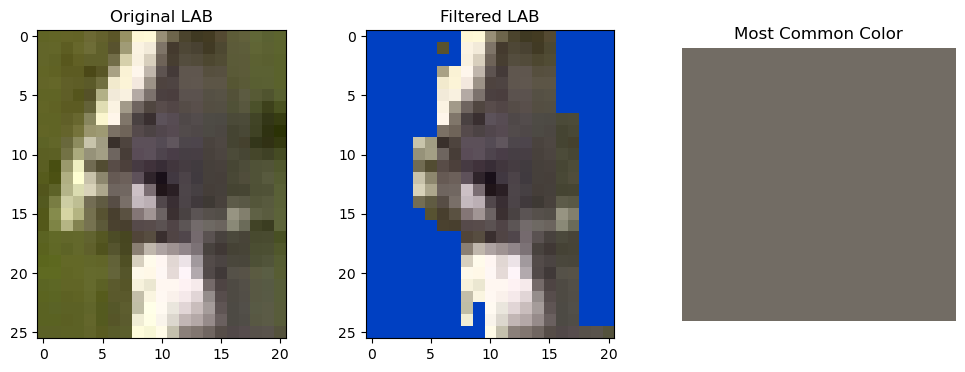

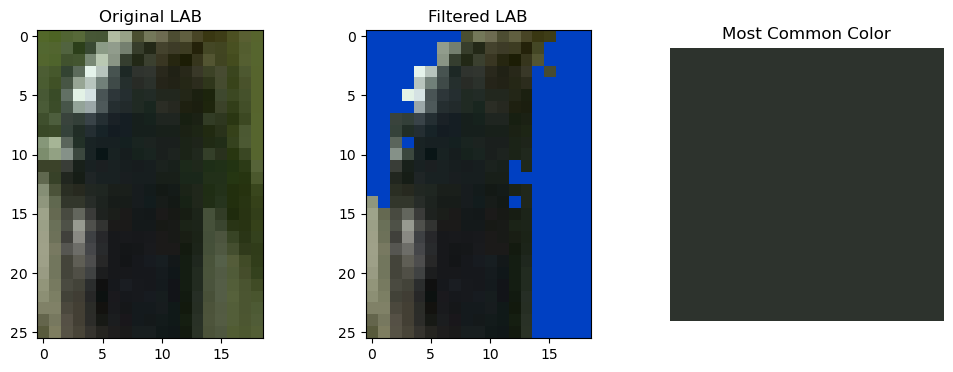

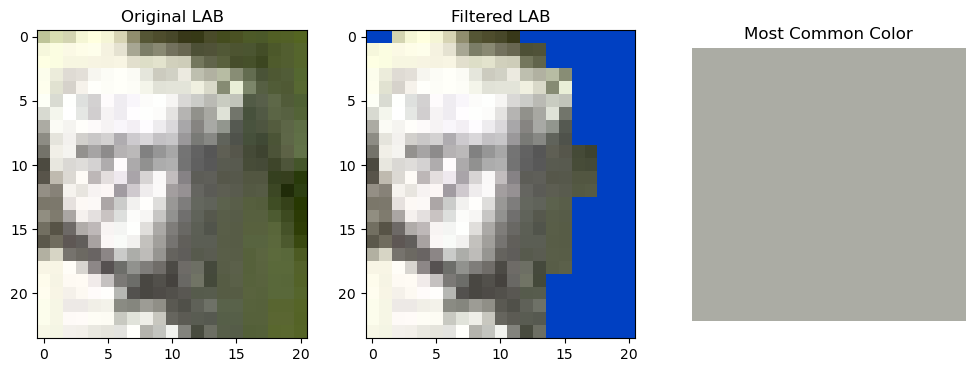

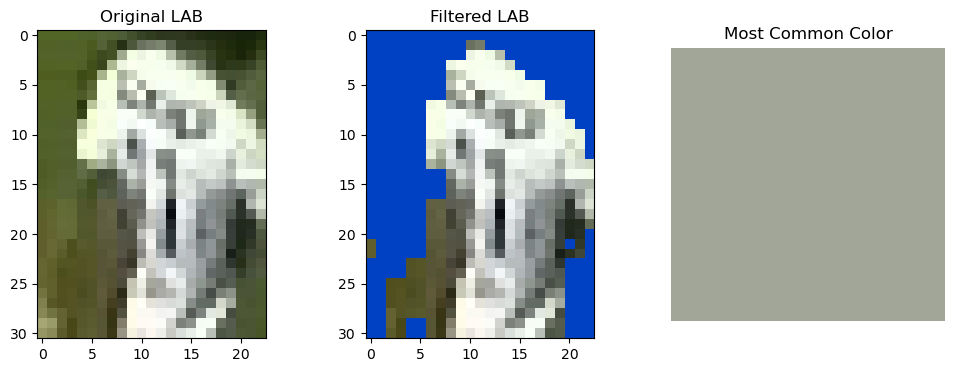

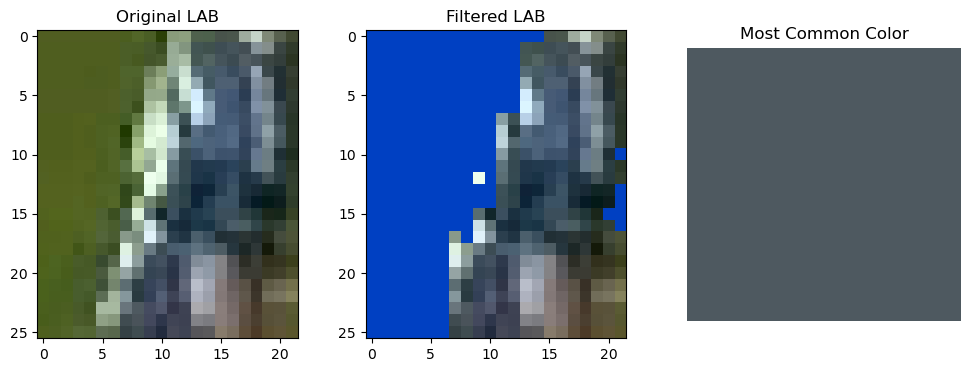

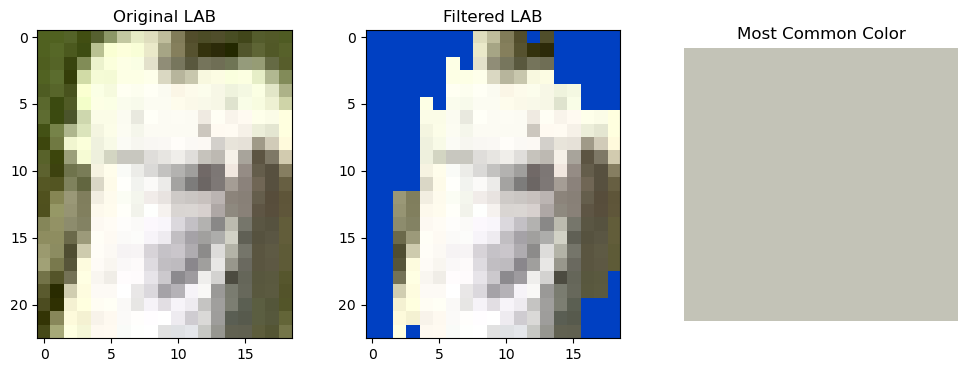

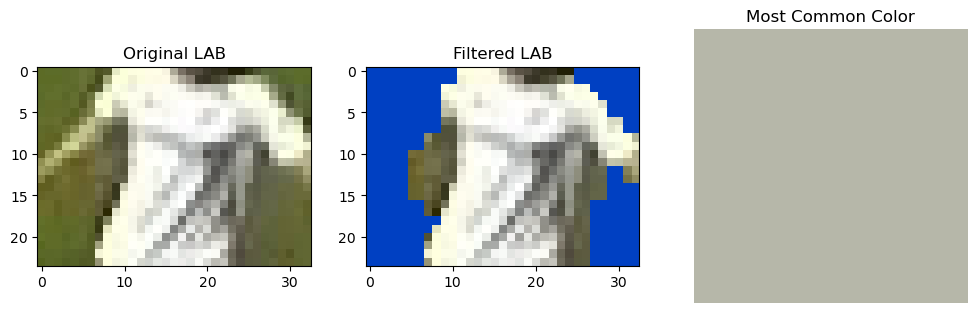

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f908d790>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.5ms
Spe

3


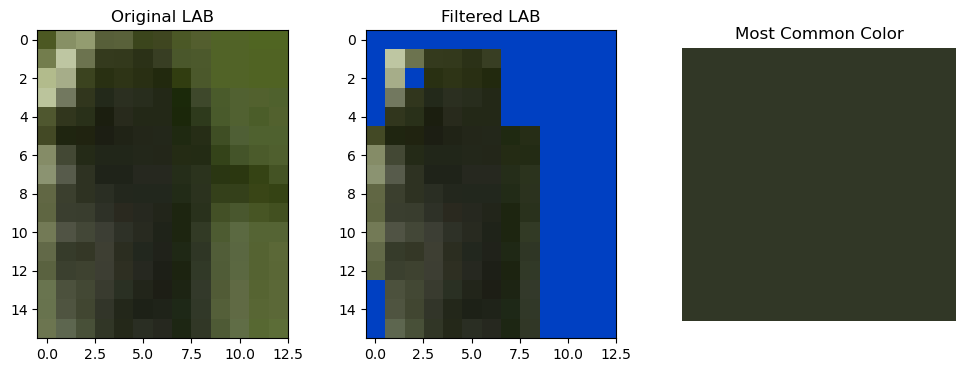

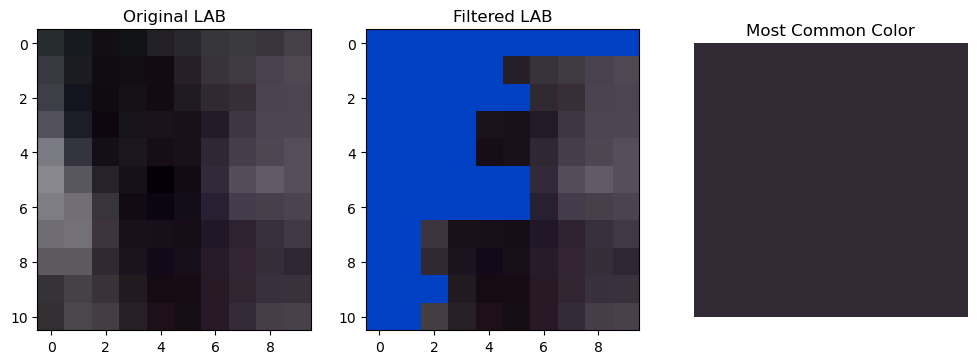

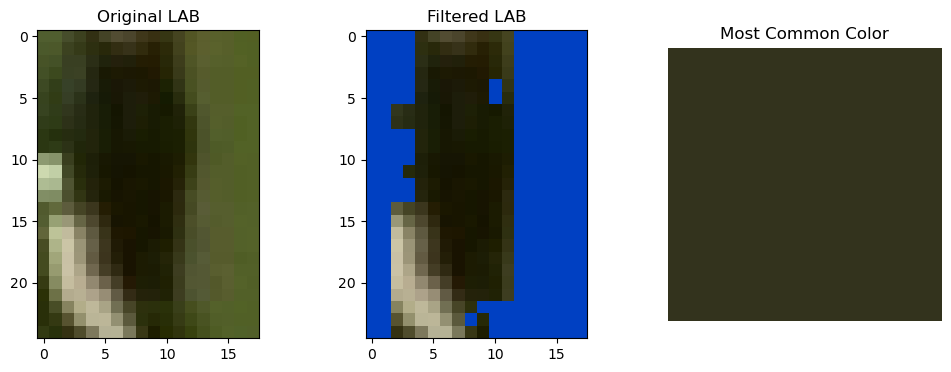

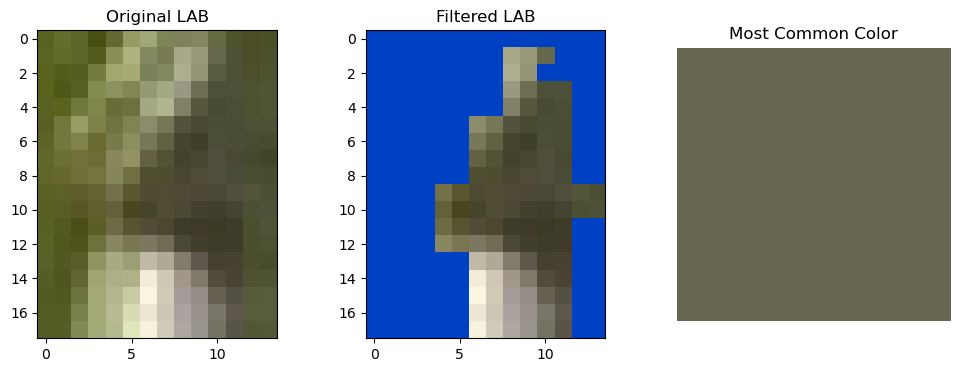

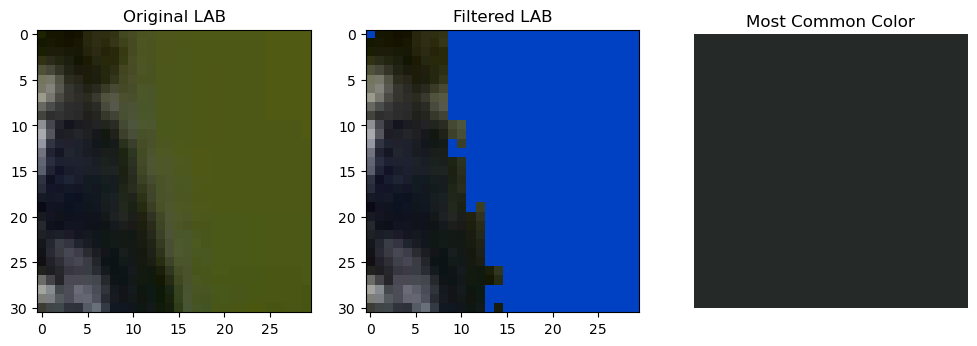

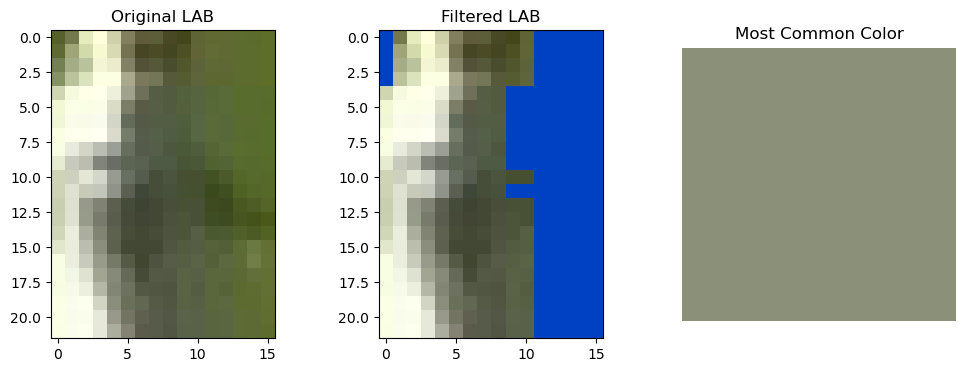

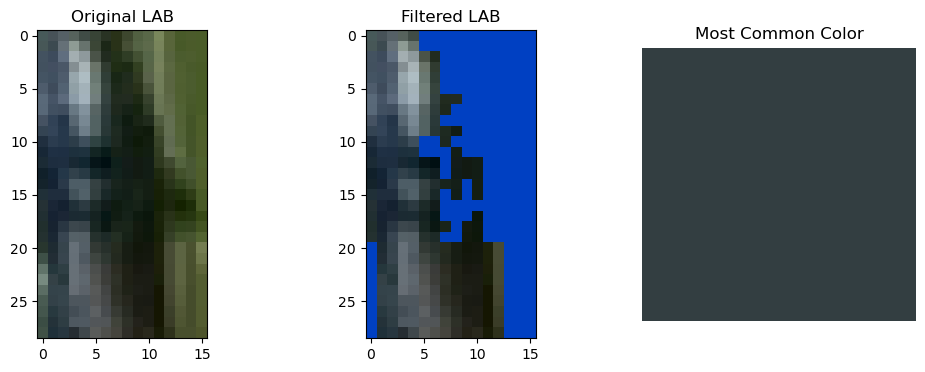

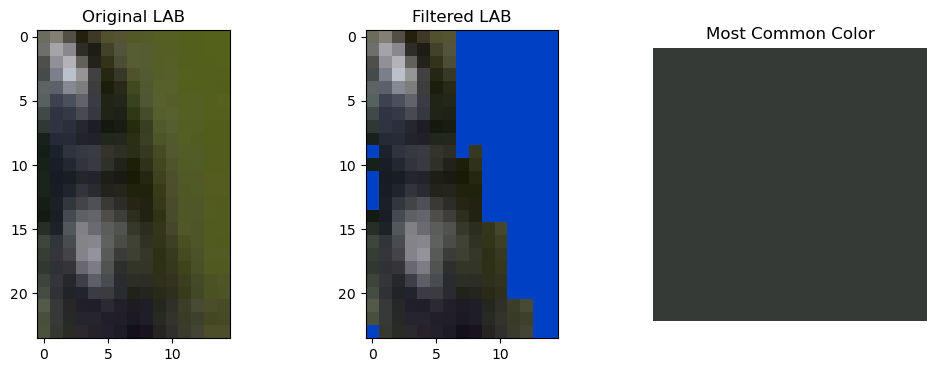

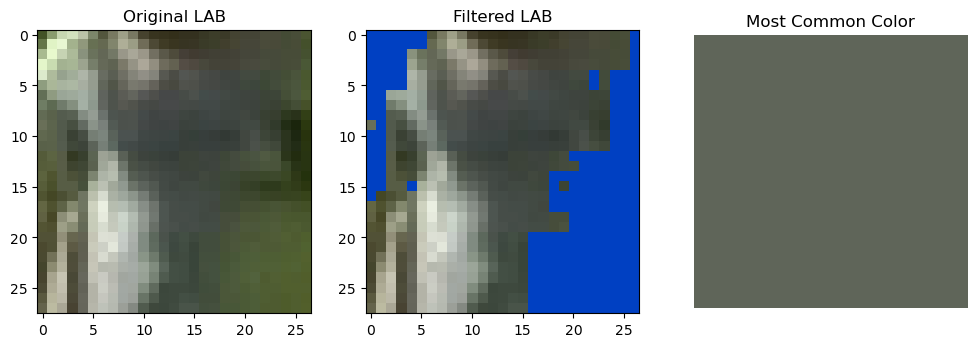

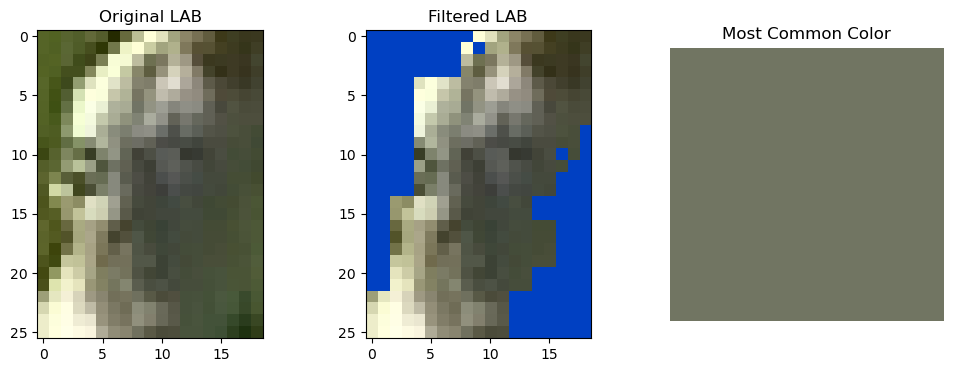

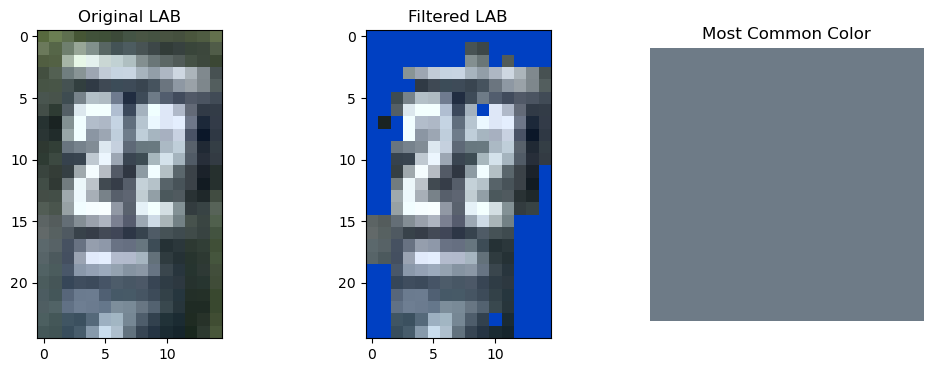

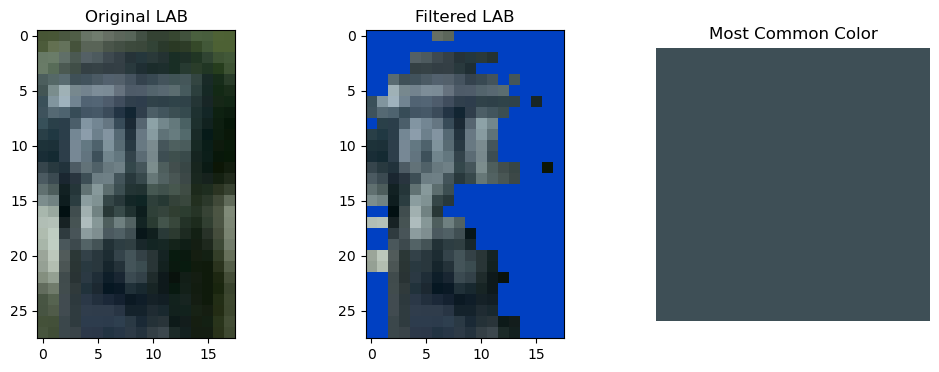

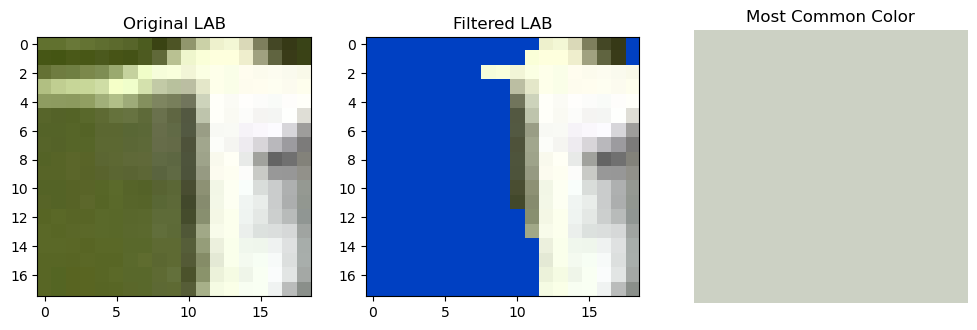

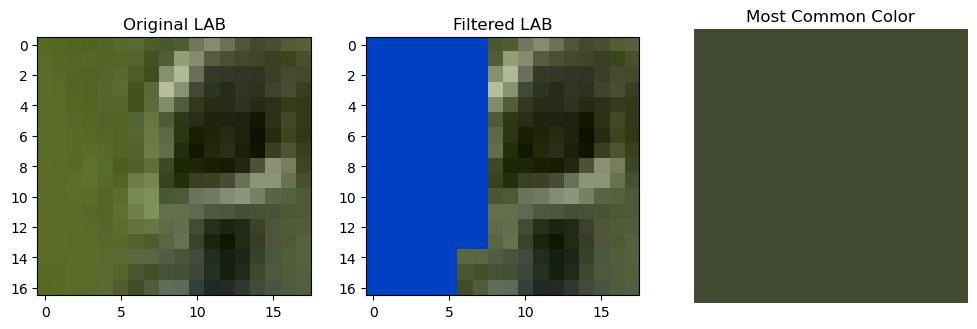

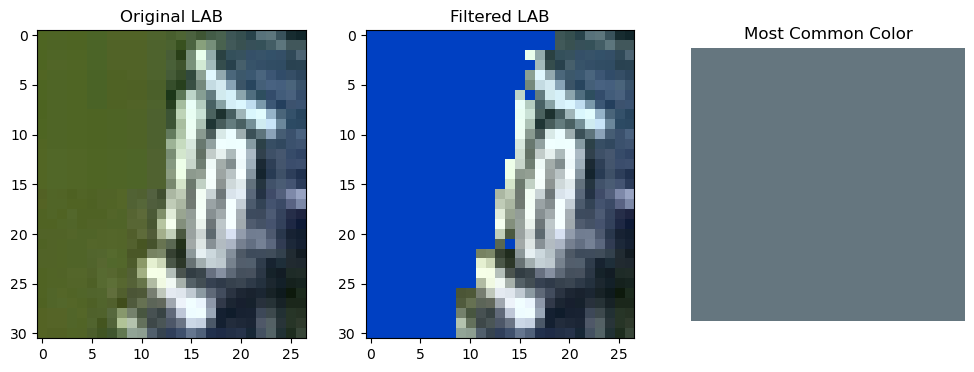

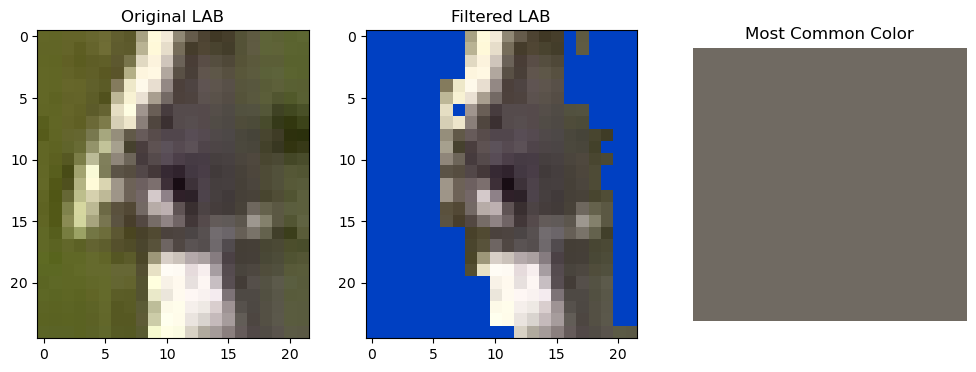

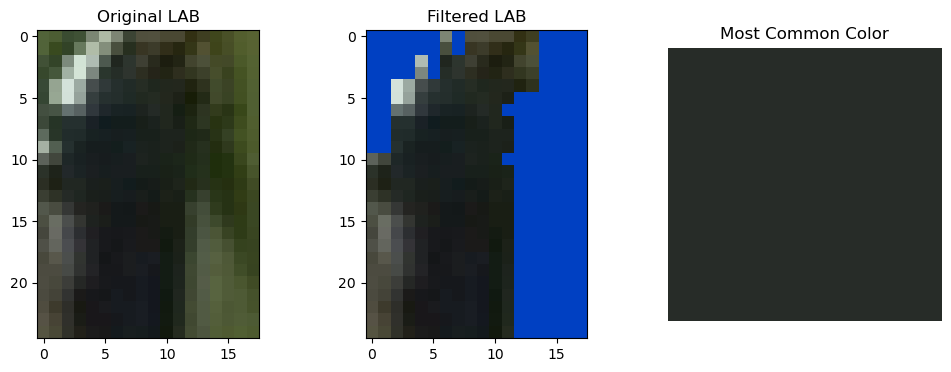

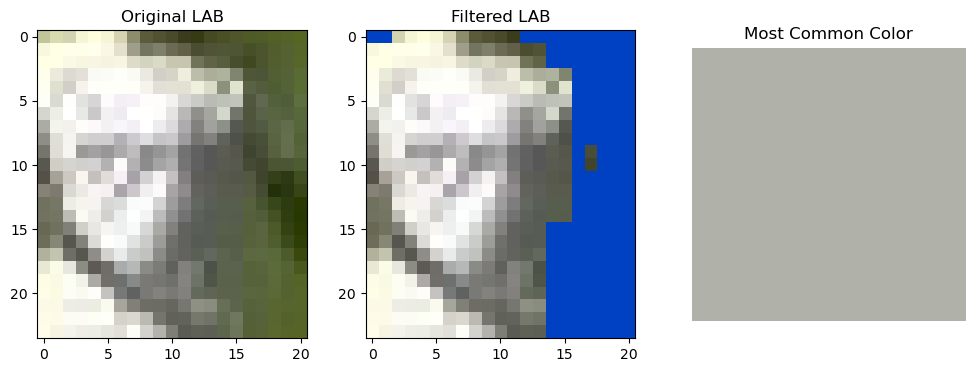

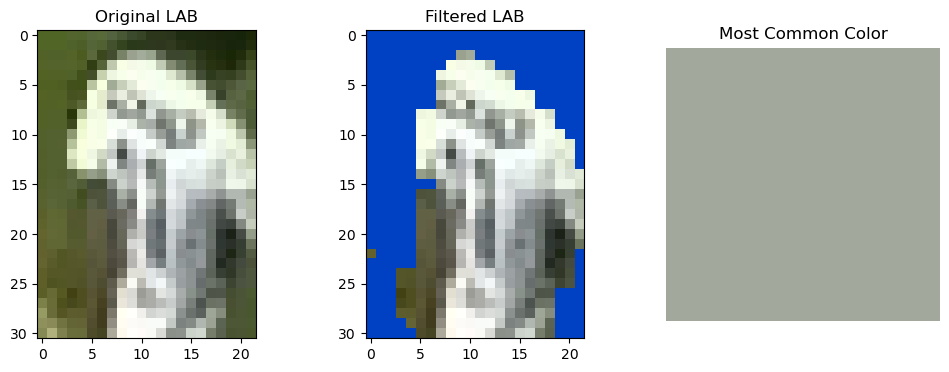

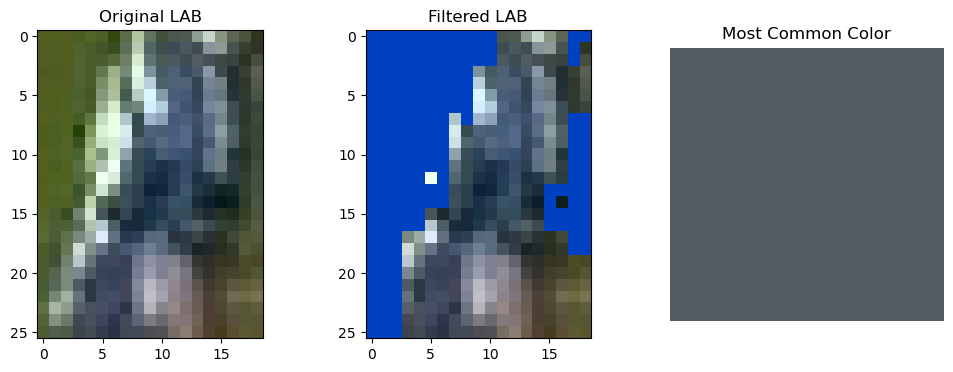

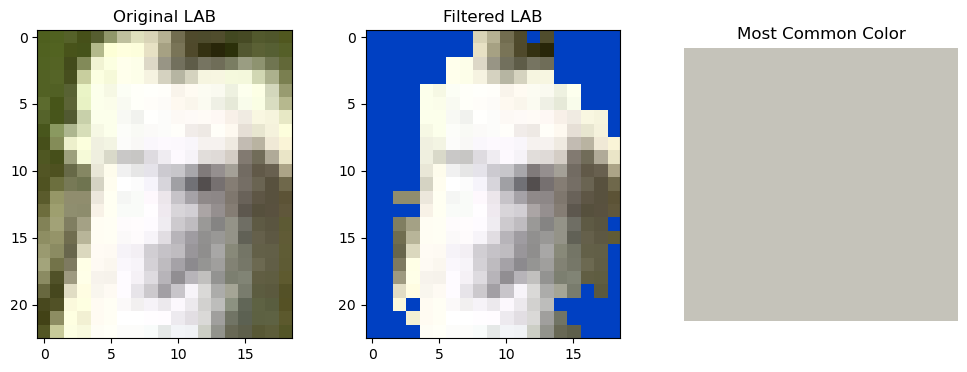

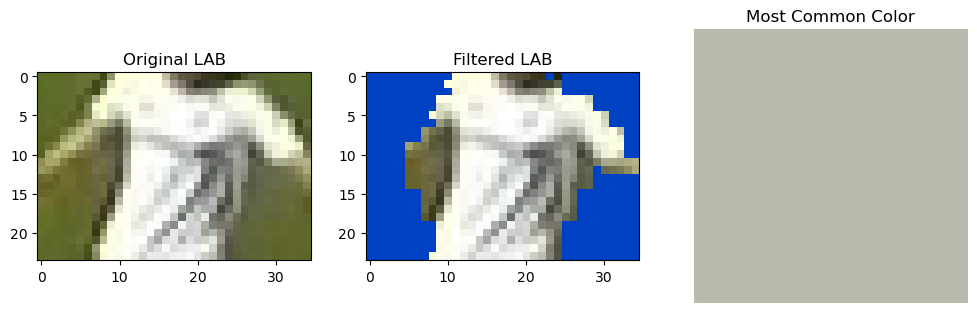

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f908d790>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 23 players, 19.4ms
Spe

4


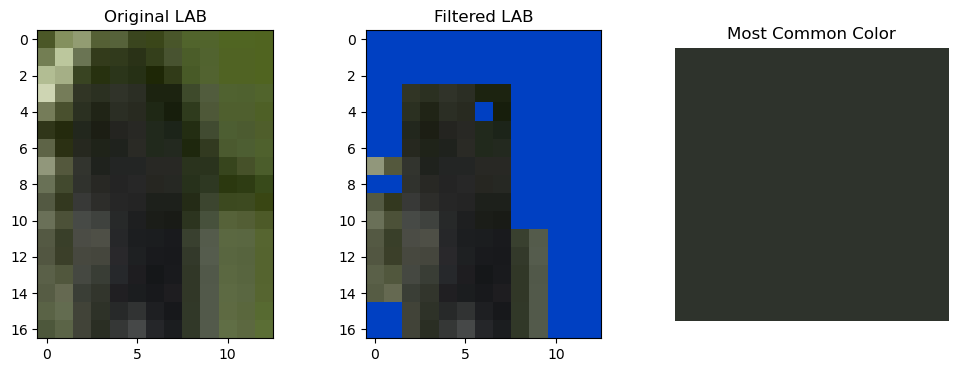

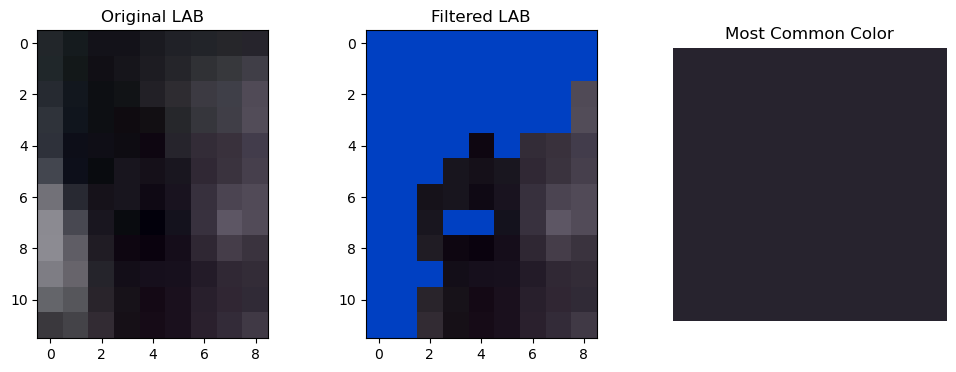

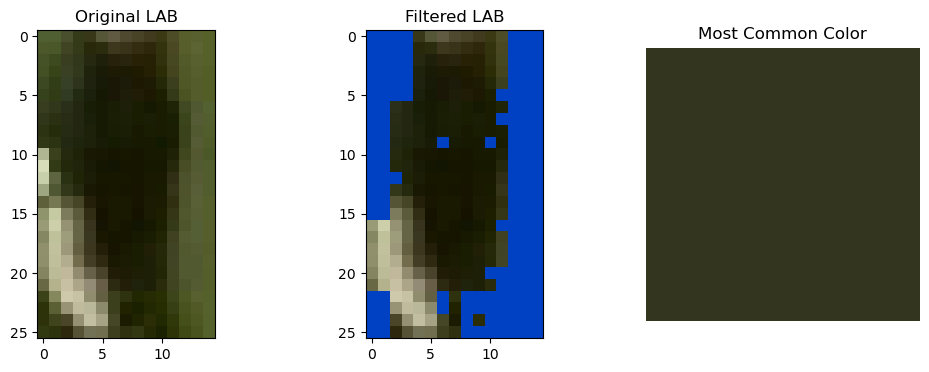

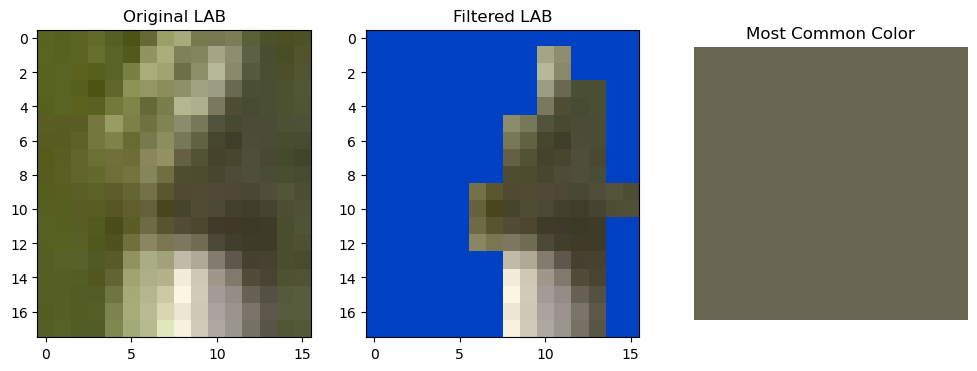

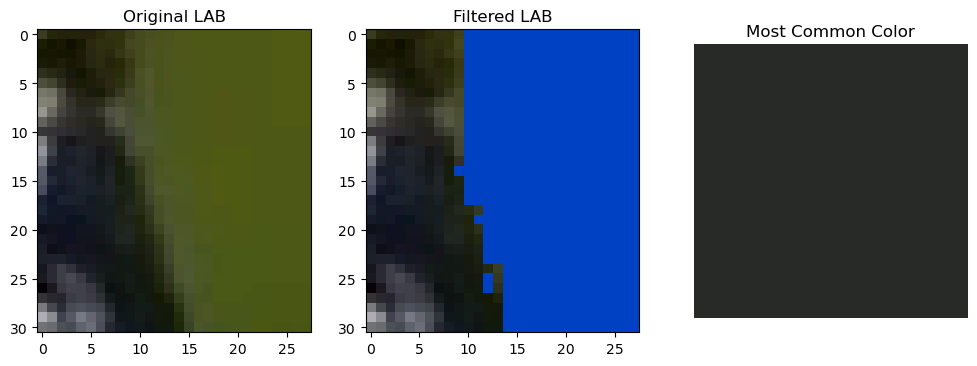

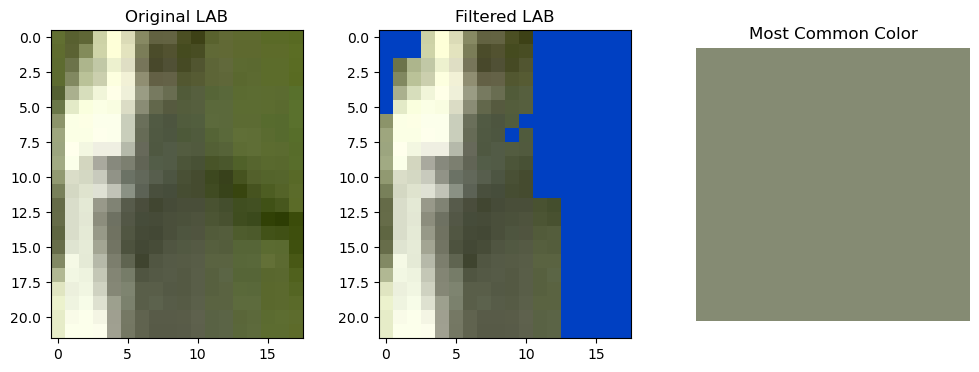

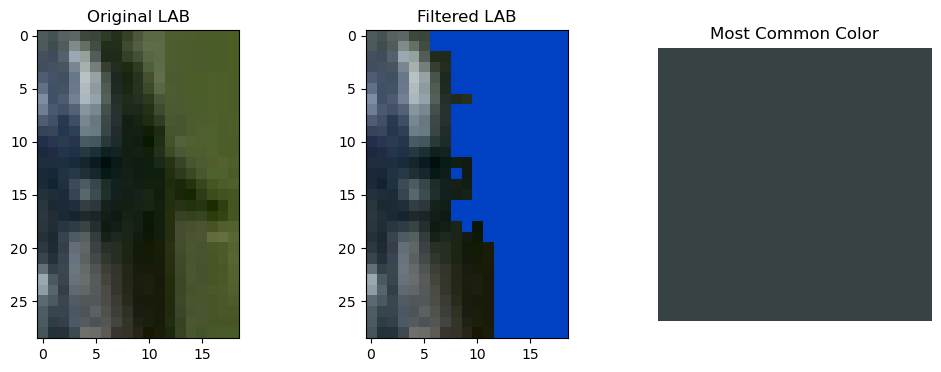

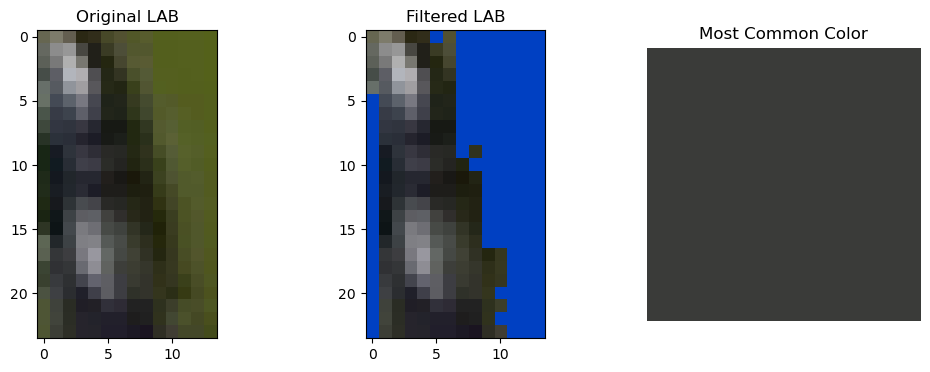

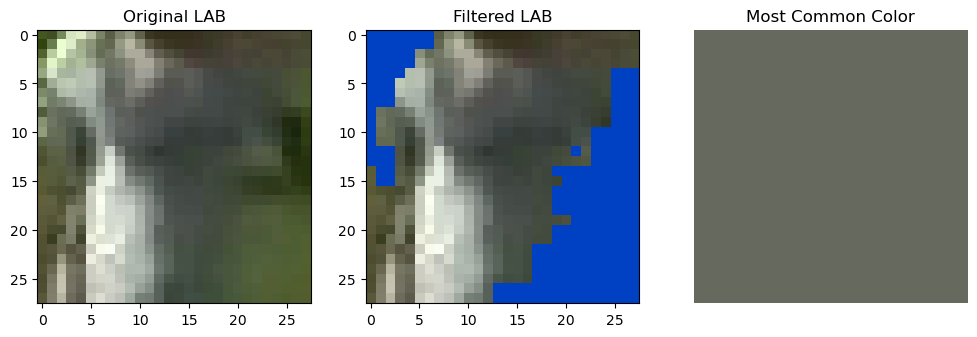

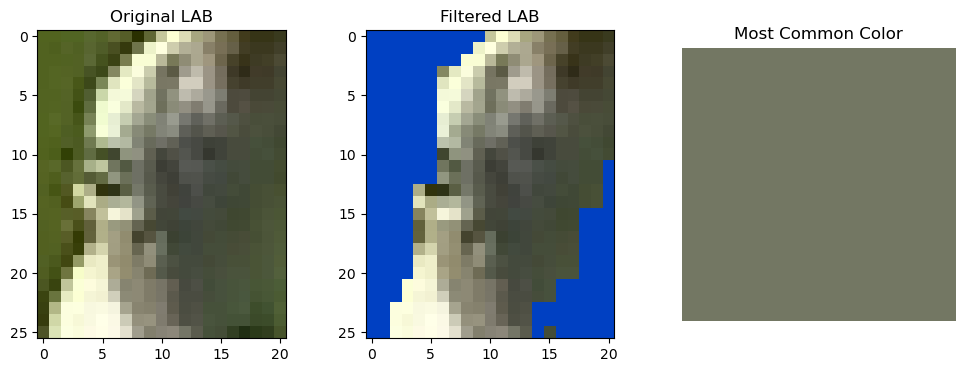

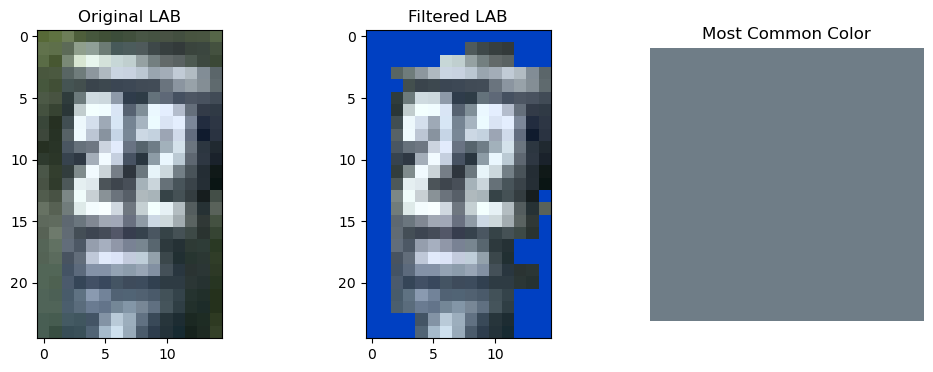

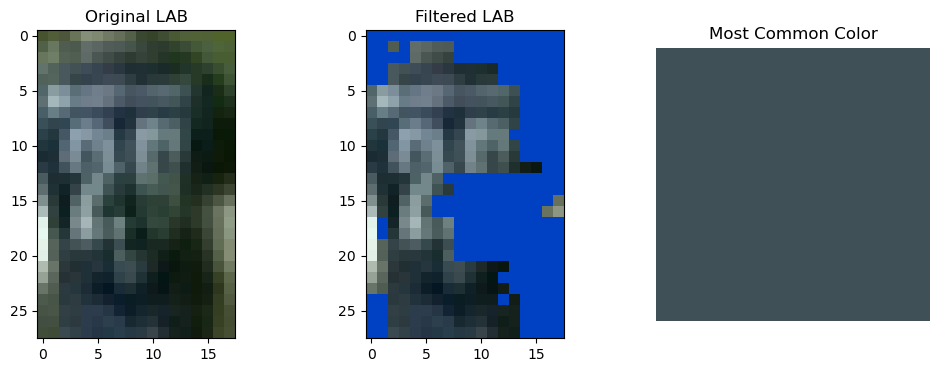

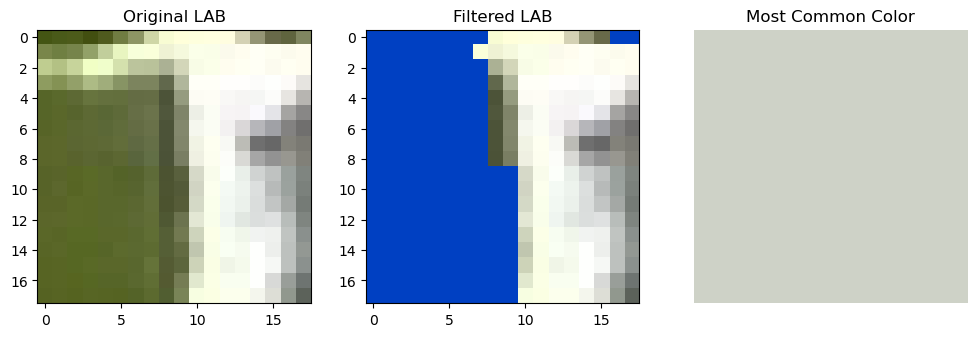

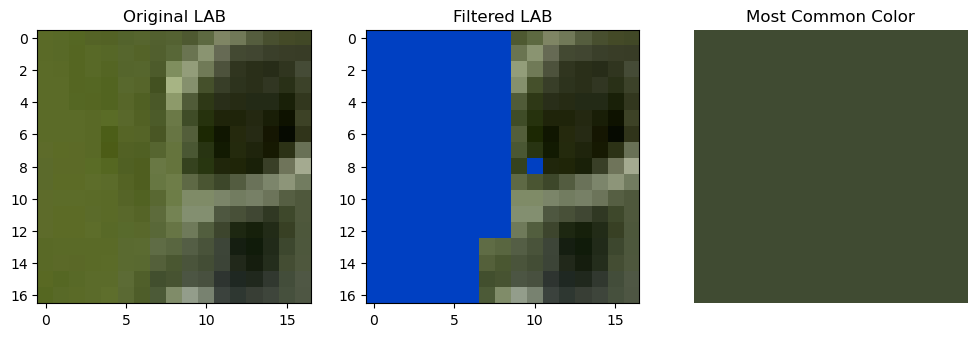

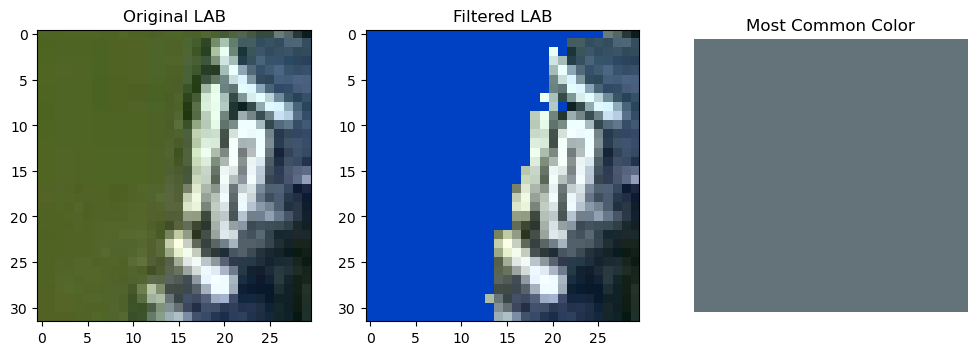

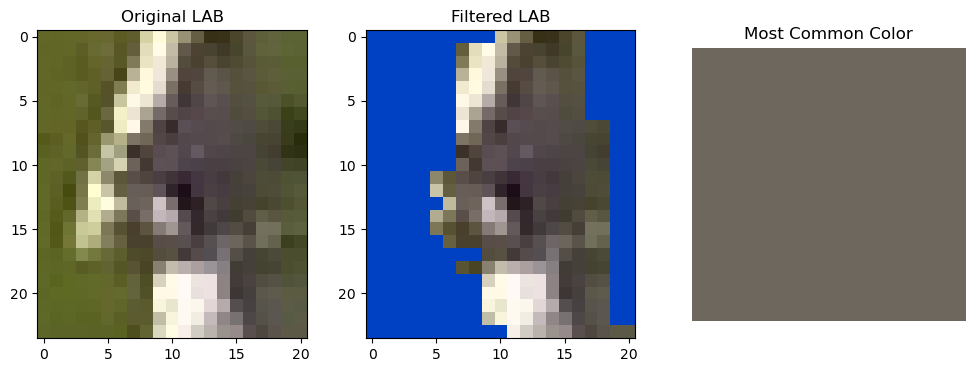

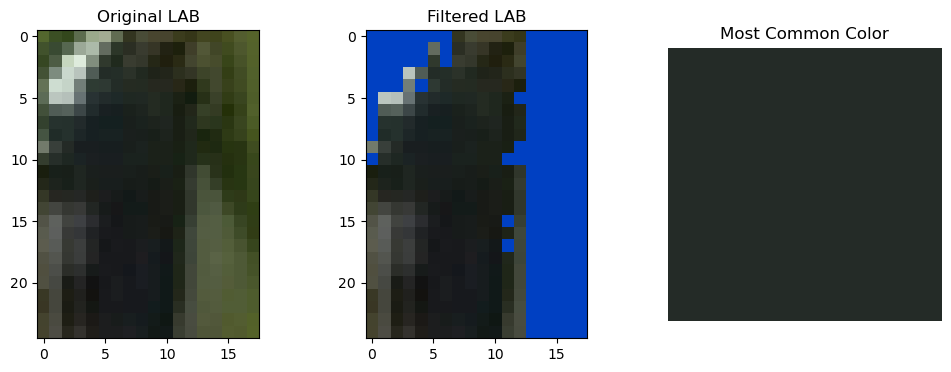

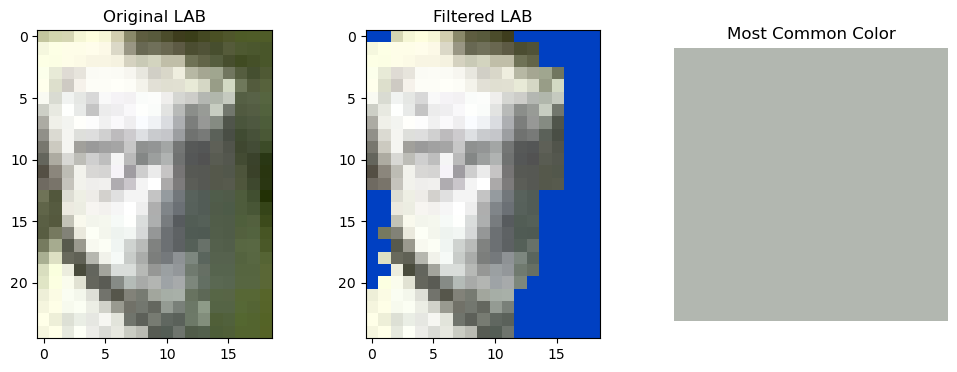

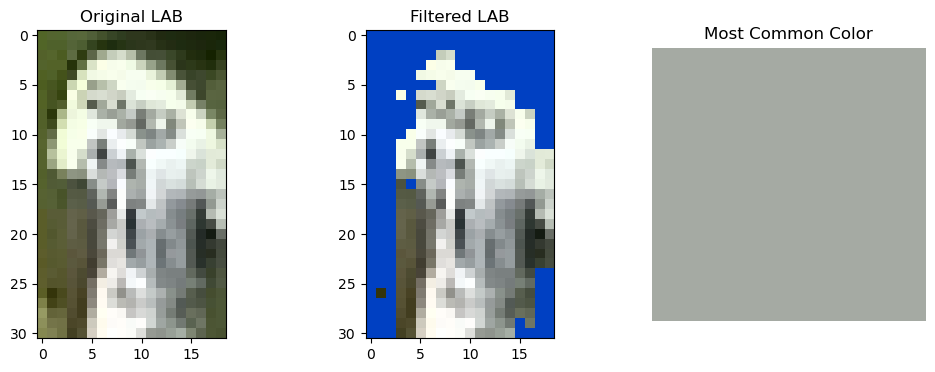

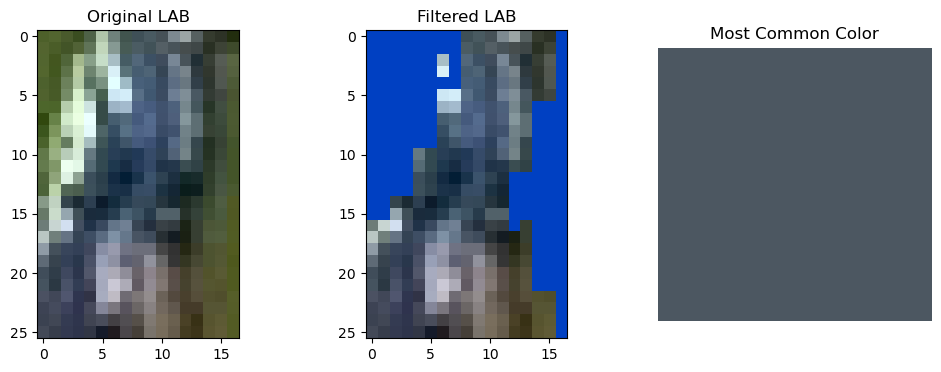

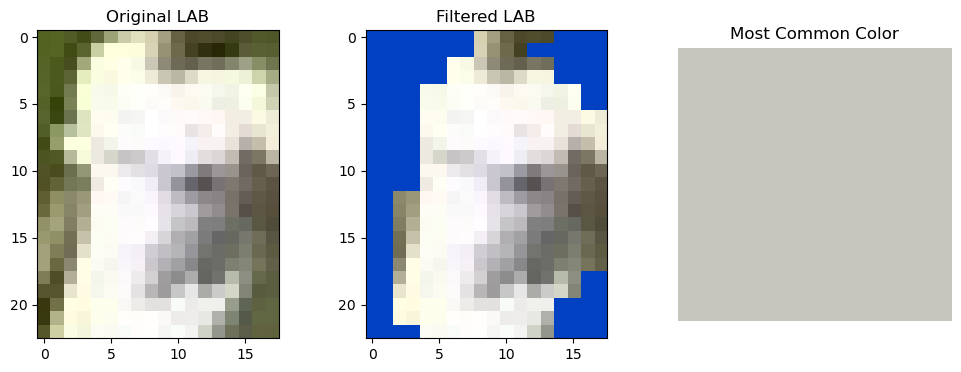

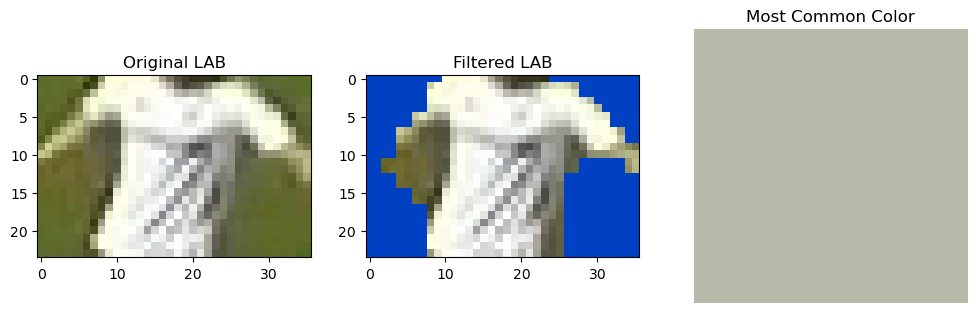

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f87a9940>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.4ms
Spe

5


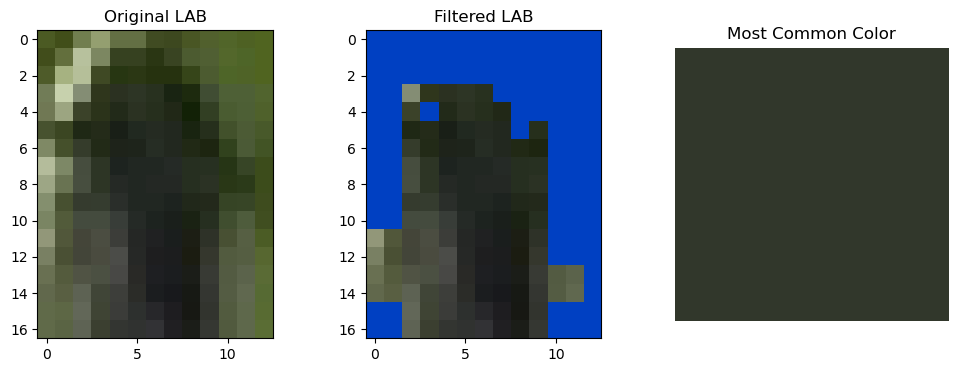

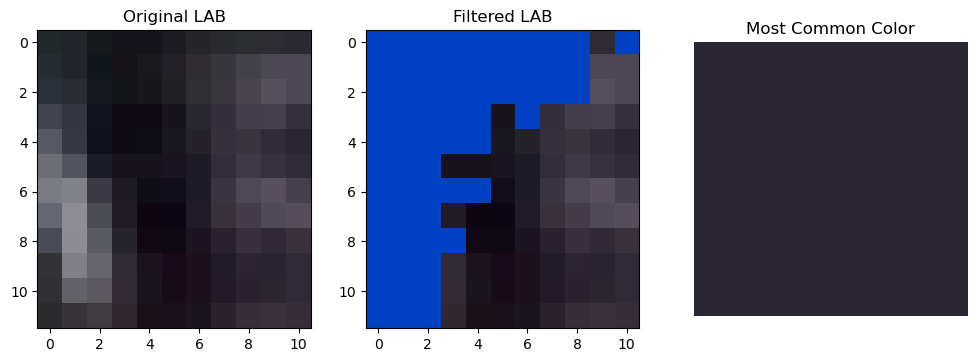

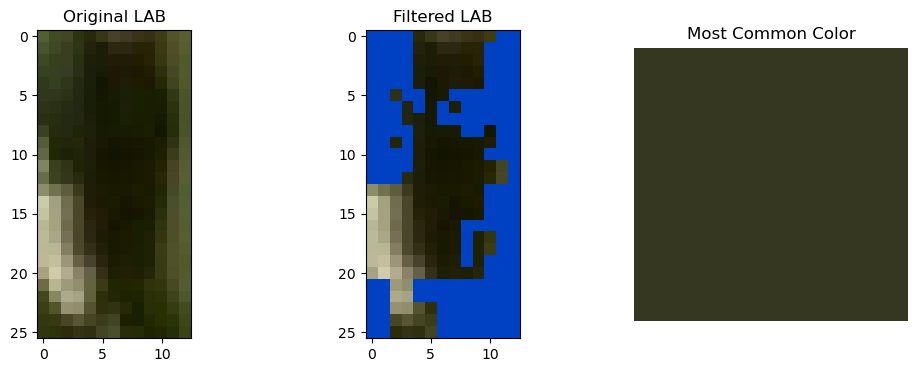

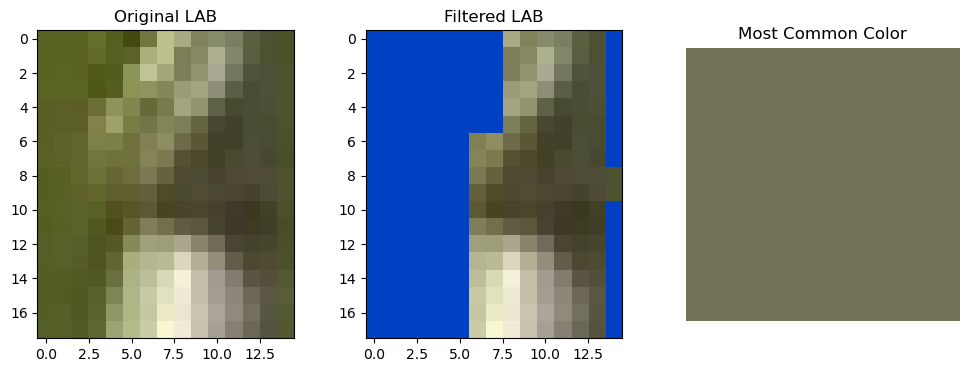

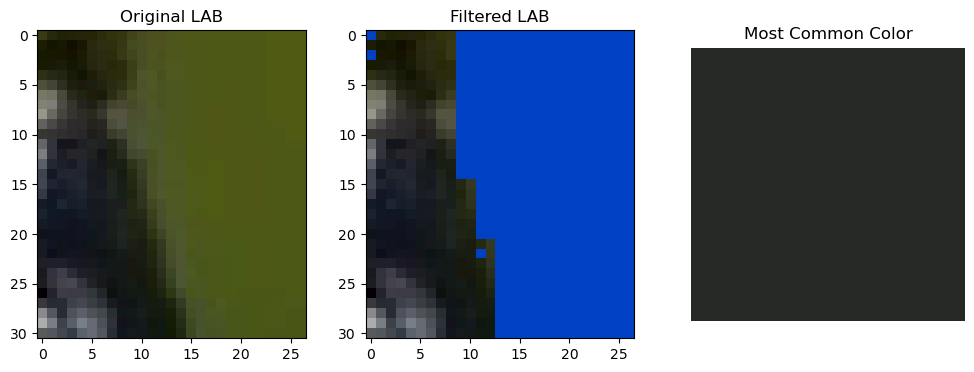

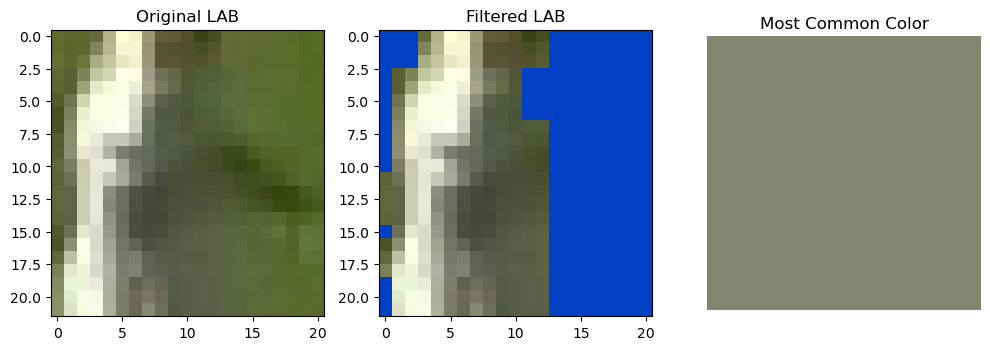

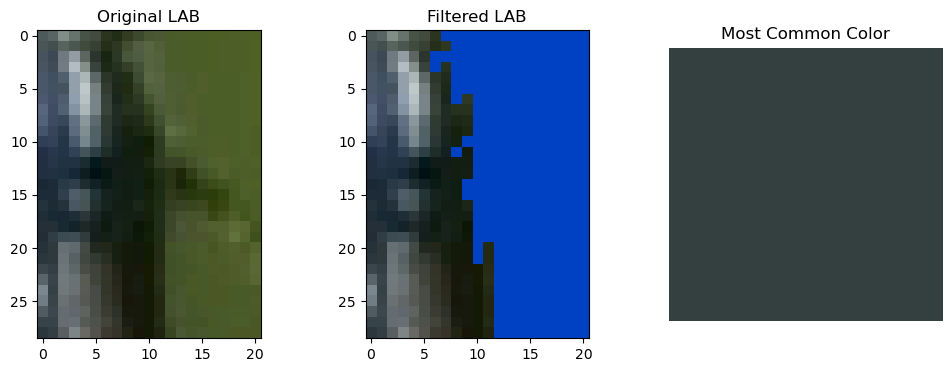

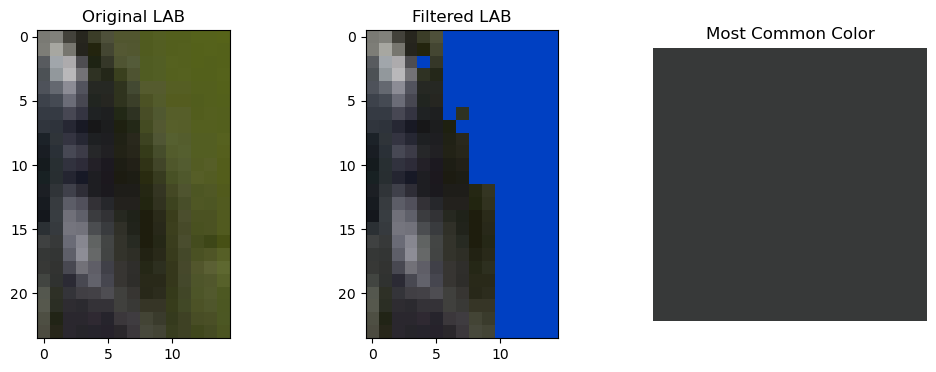

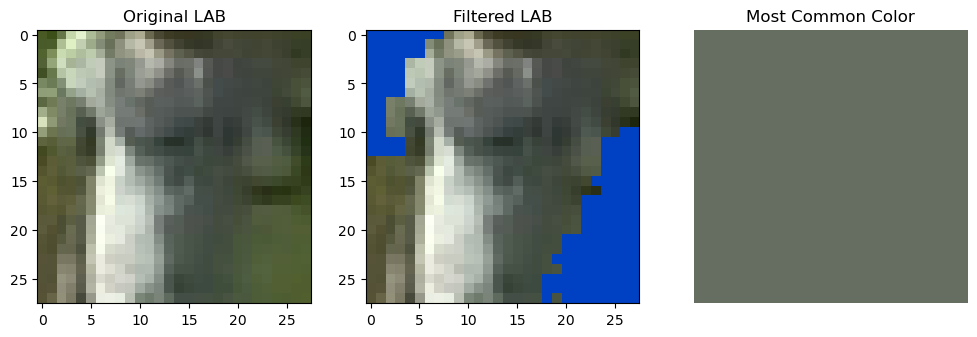

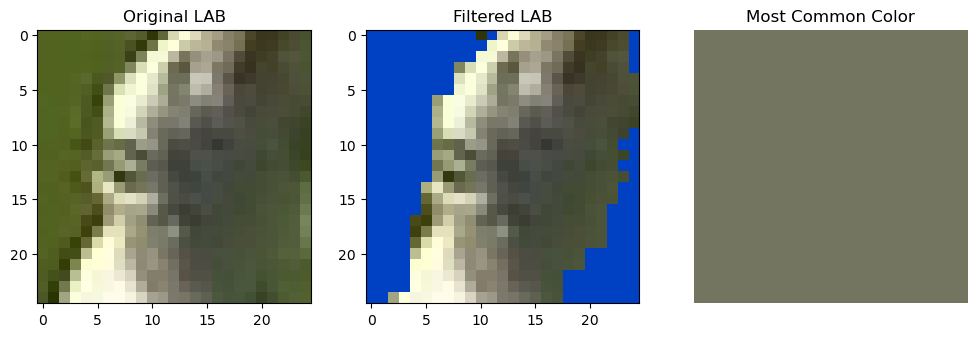

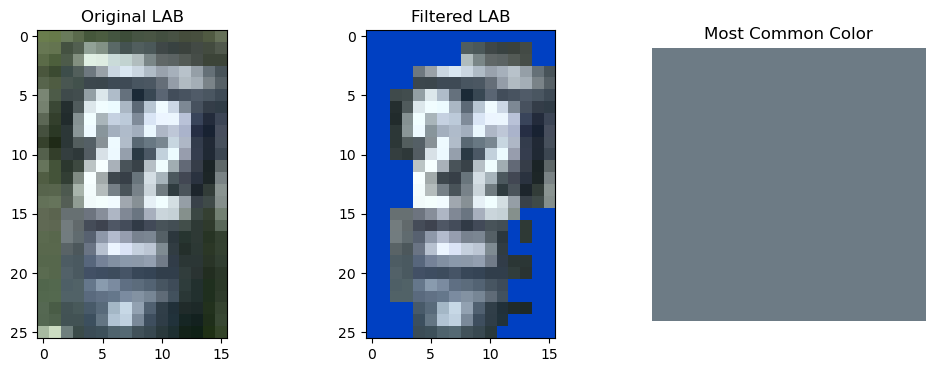

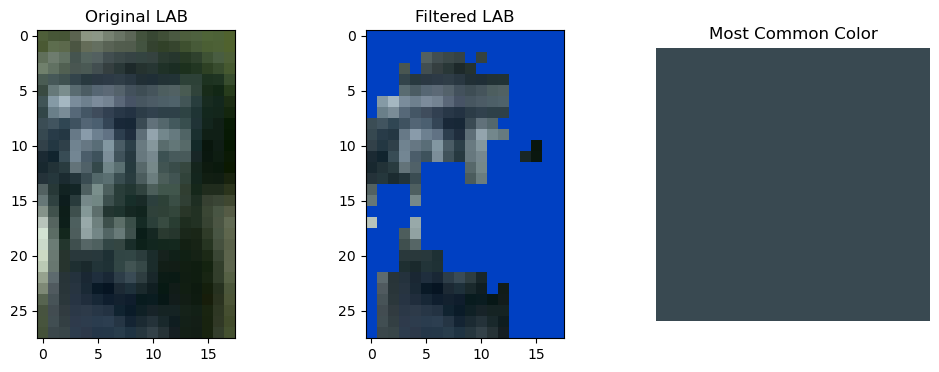

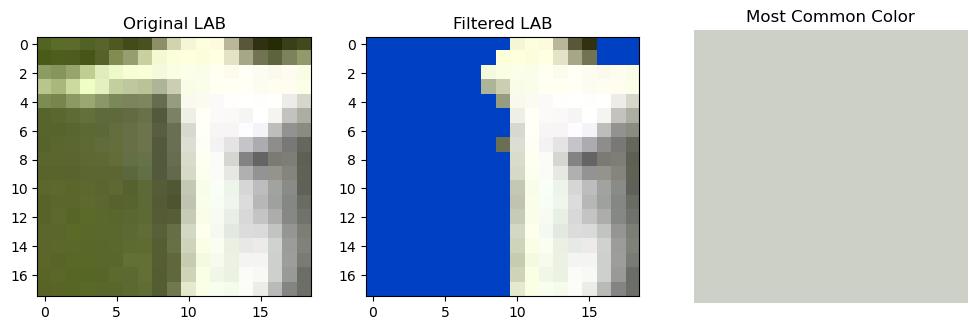

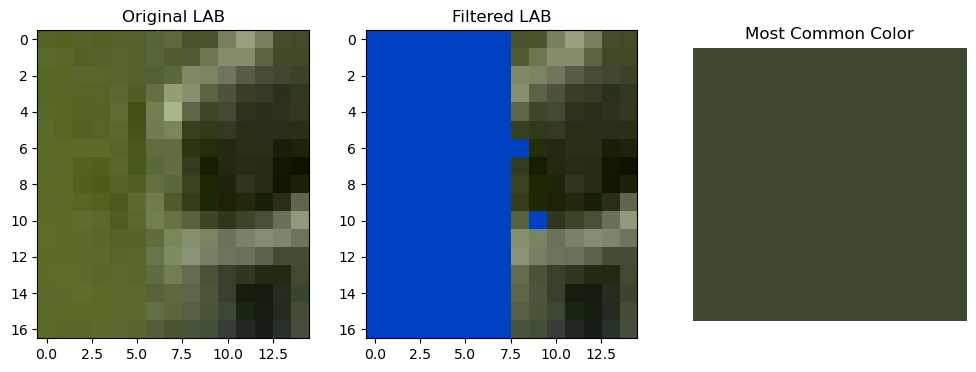

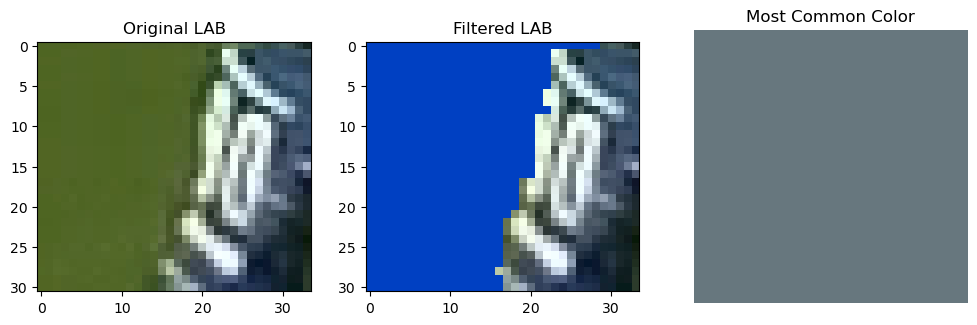

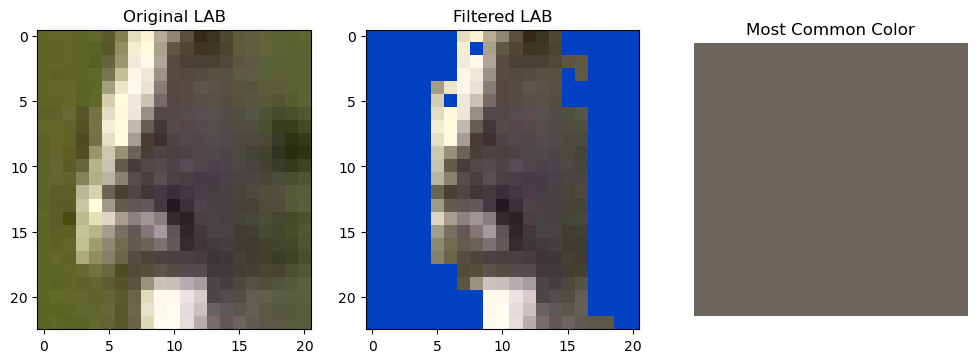

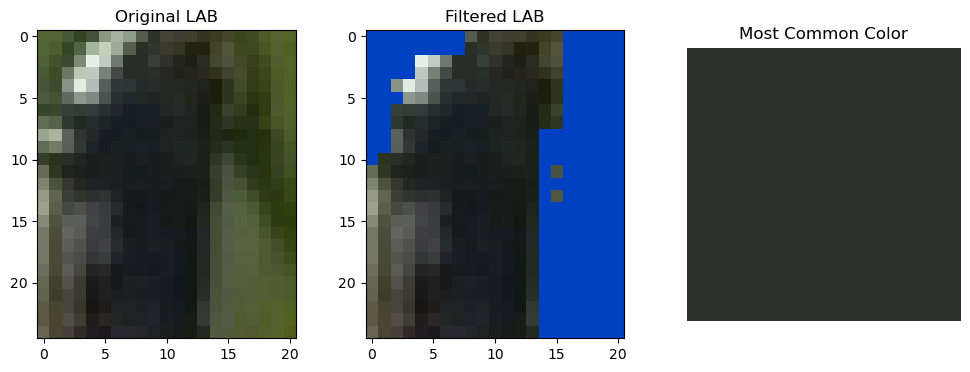

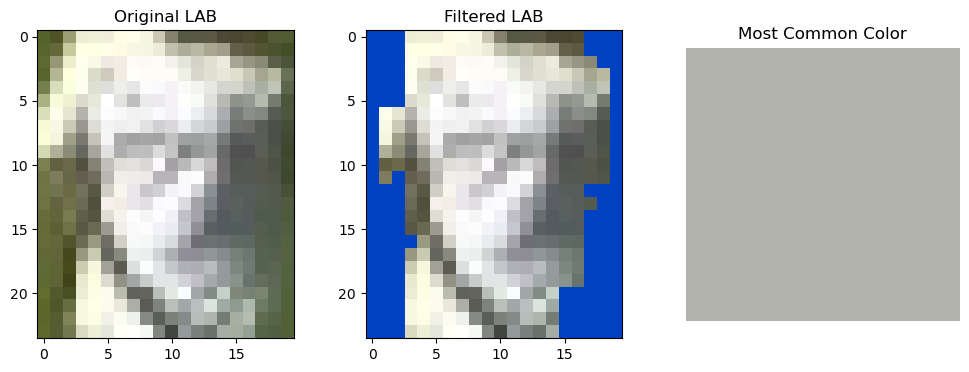

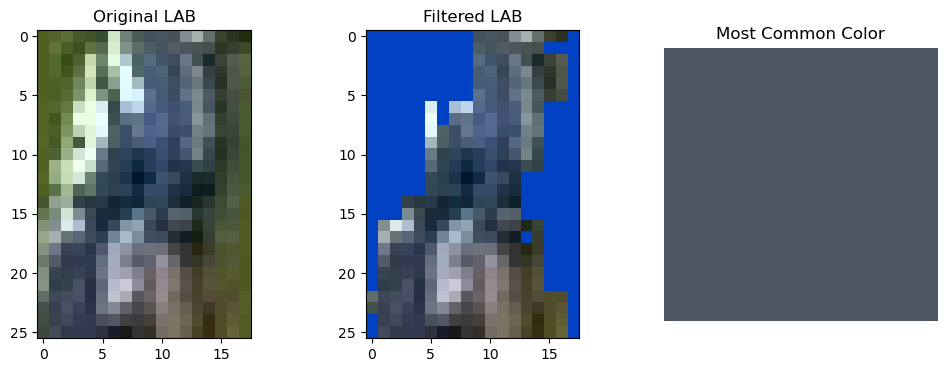

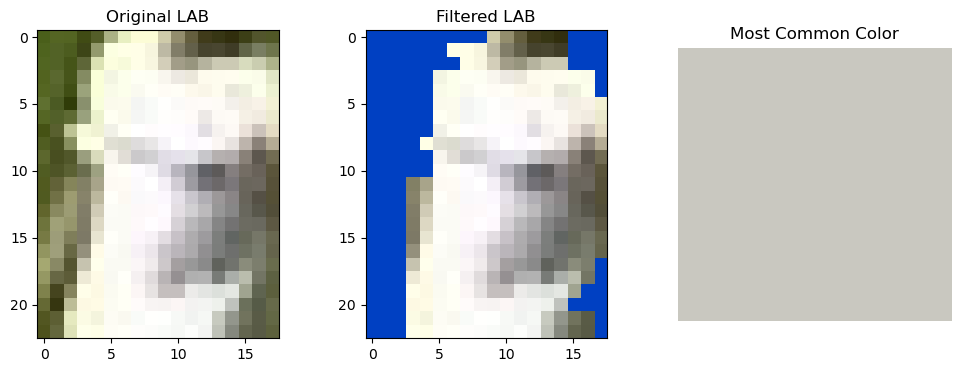

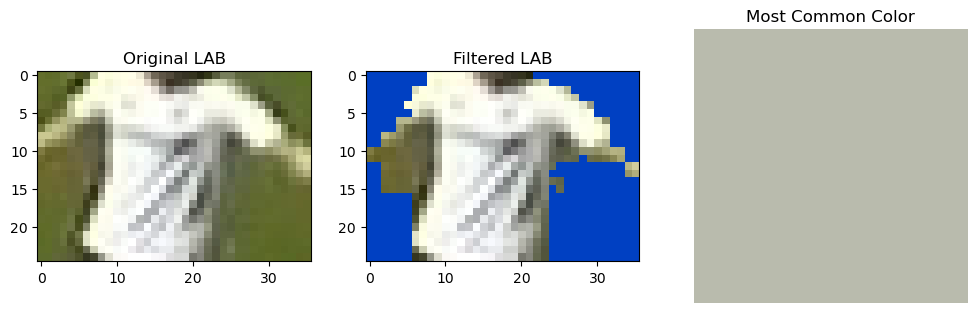

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f87a9940>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 23 players, 19.5ms
Spe

6


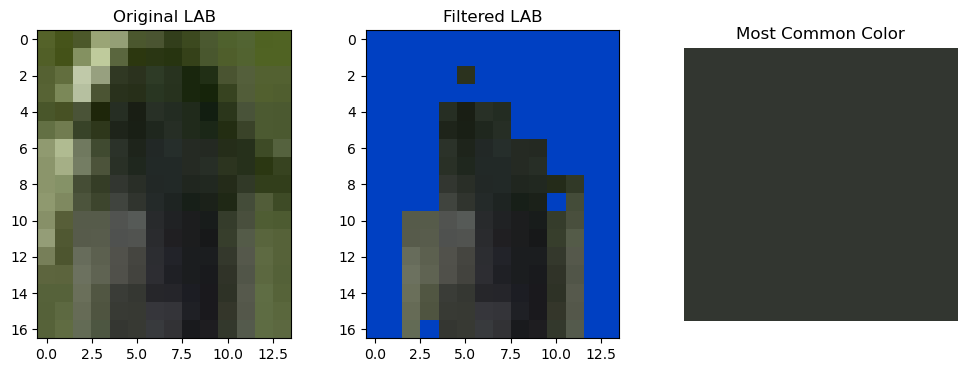

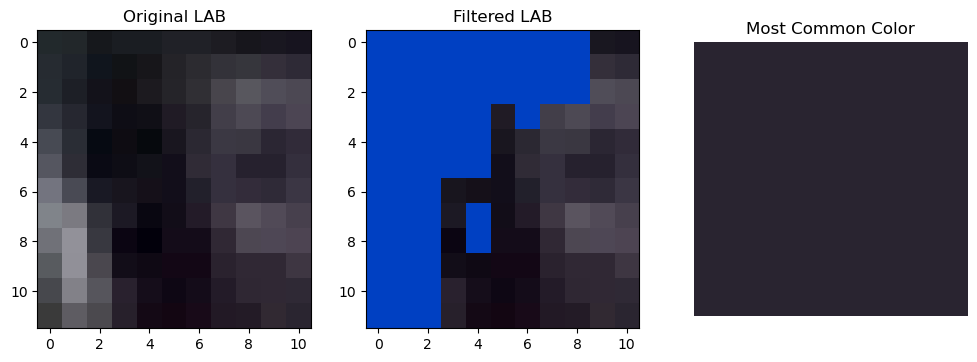

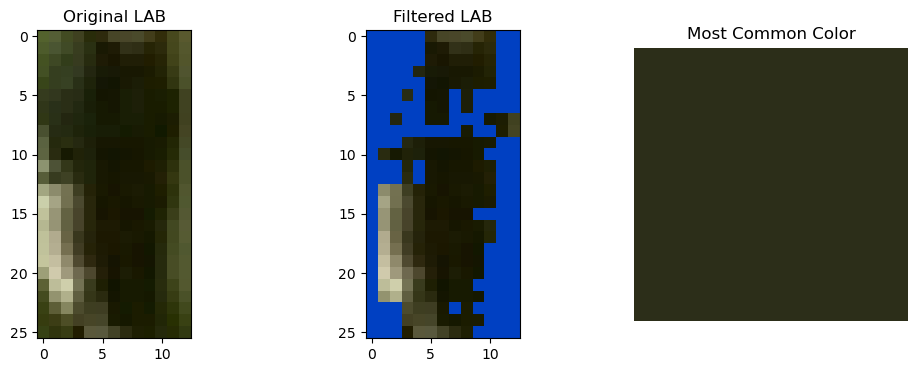

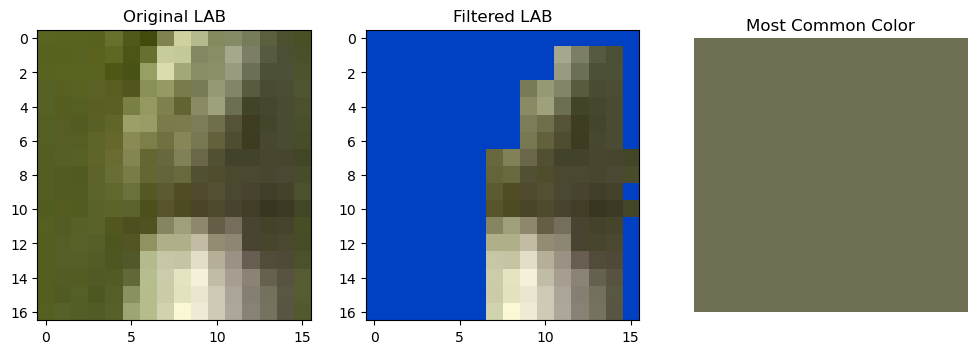

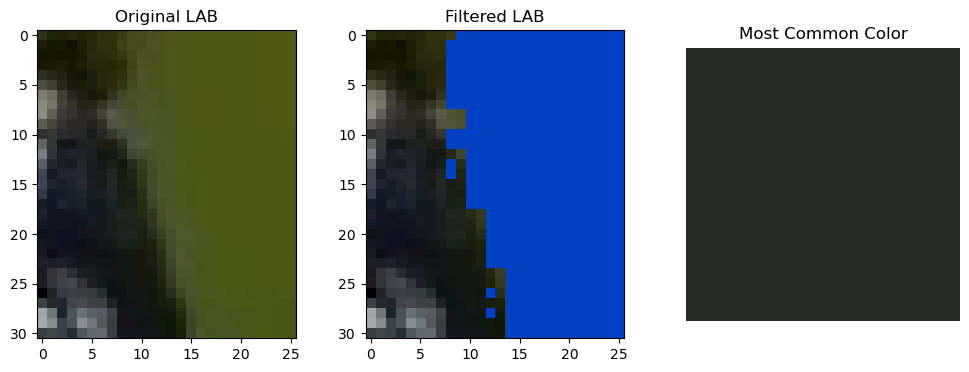

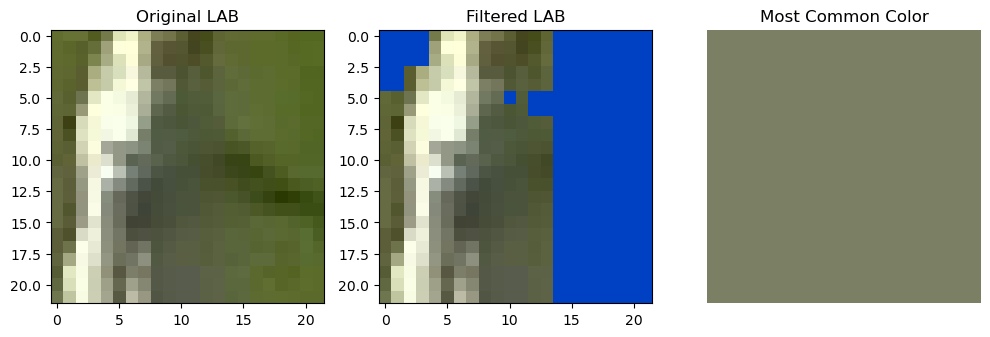

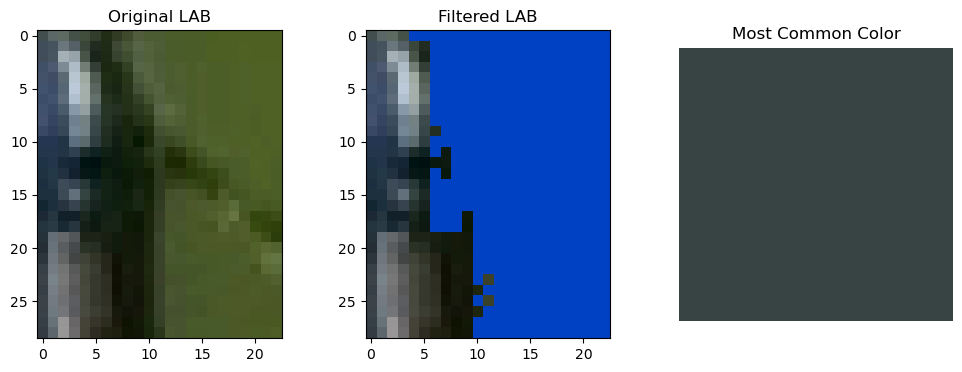

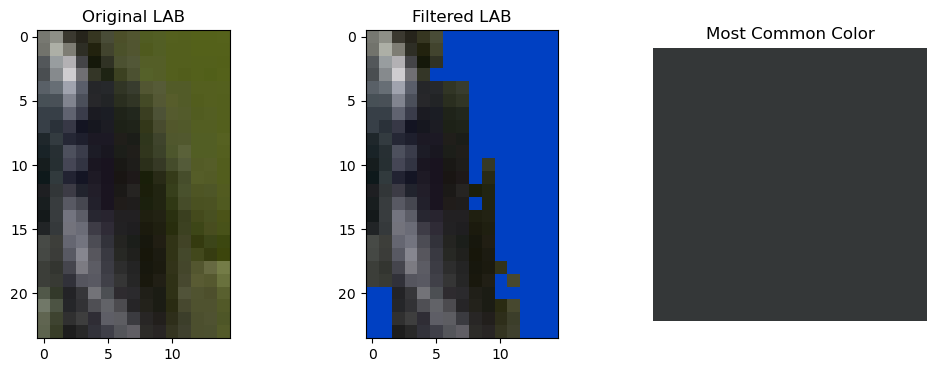

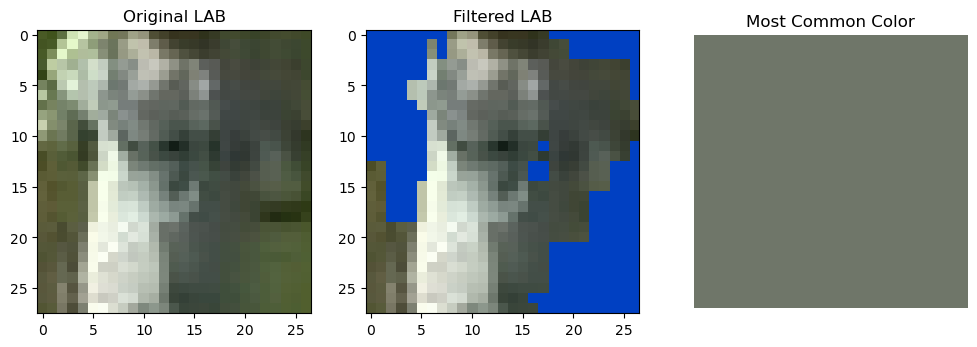

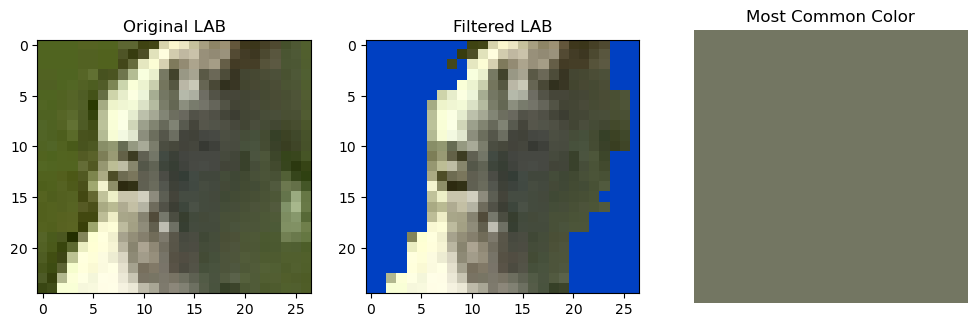

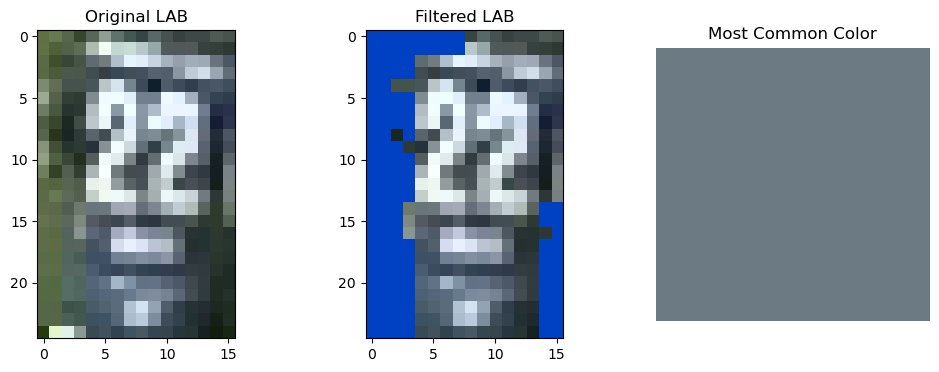

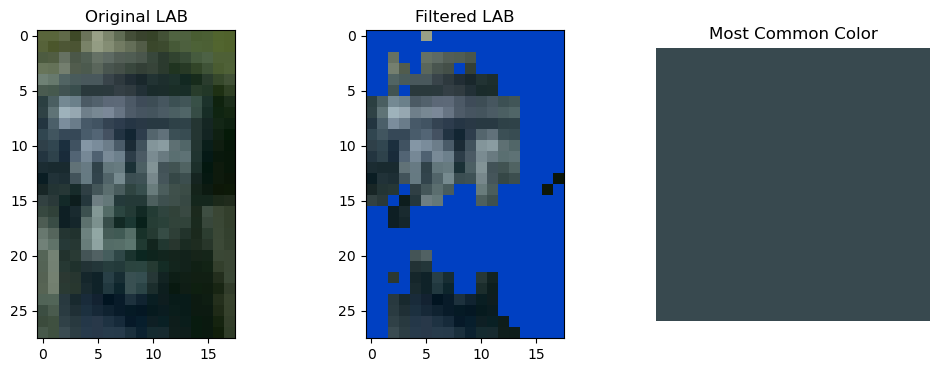

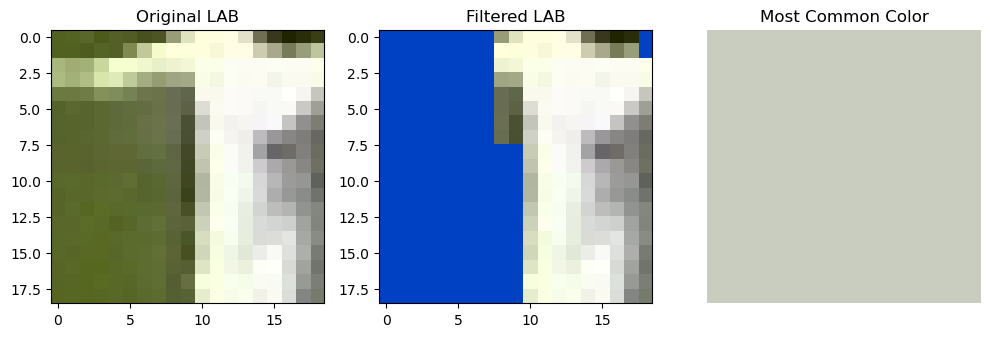

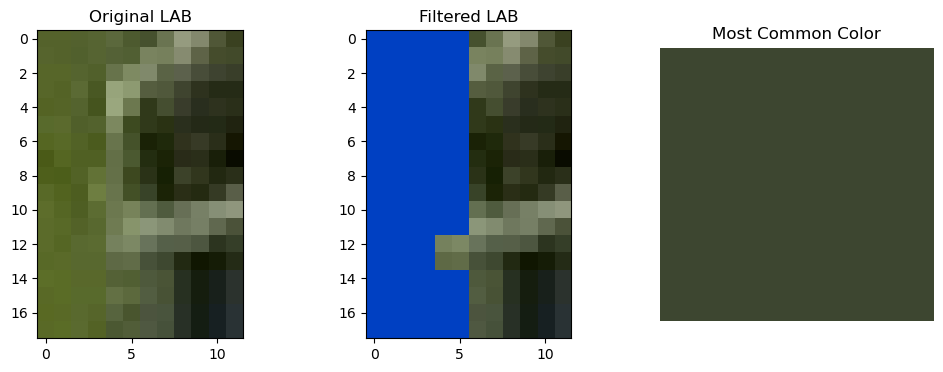

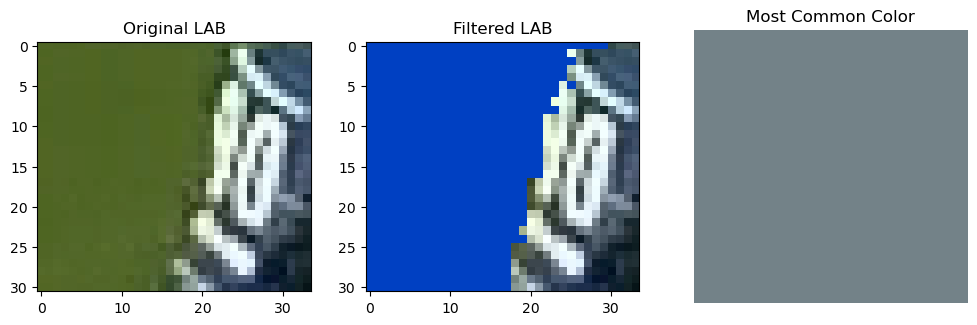

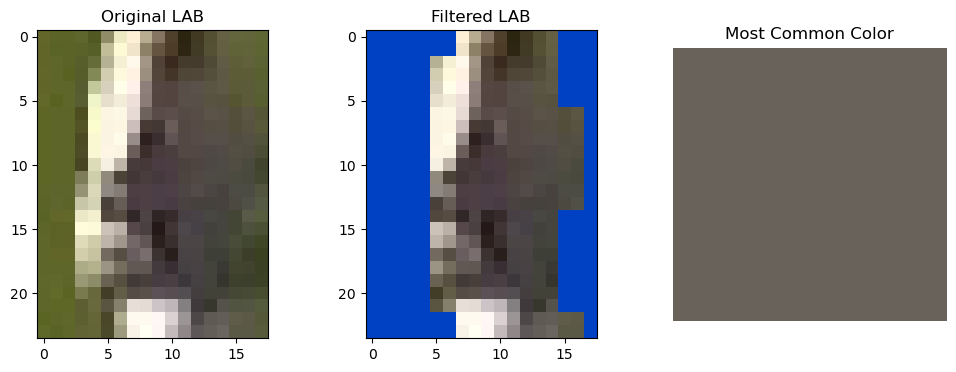

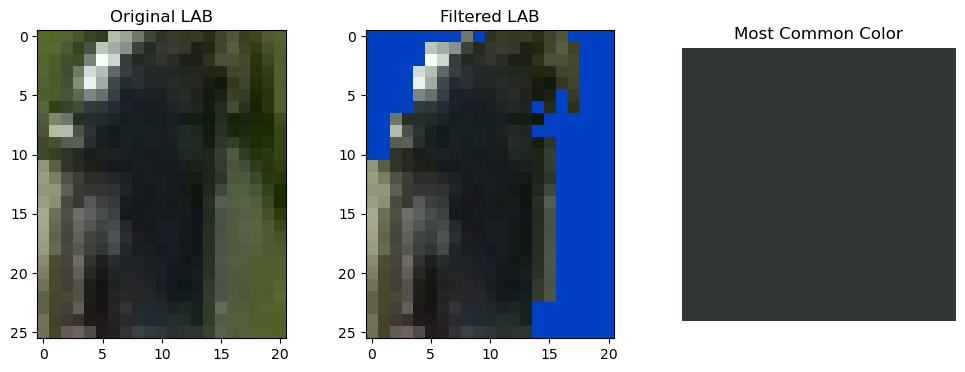

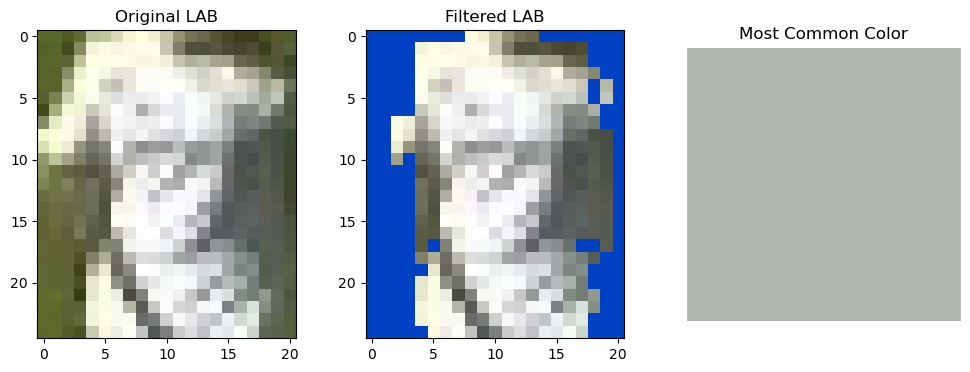

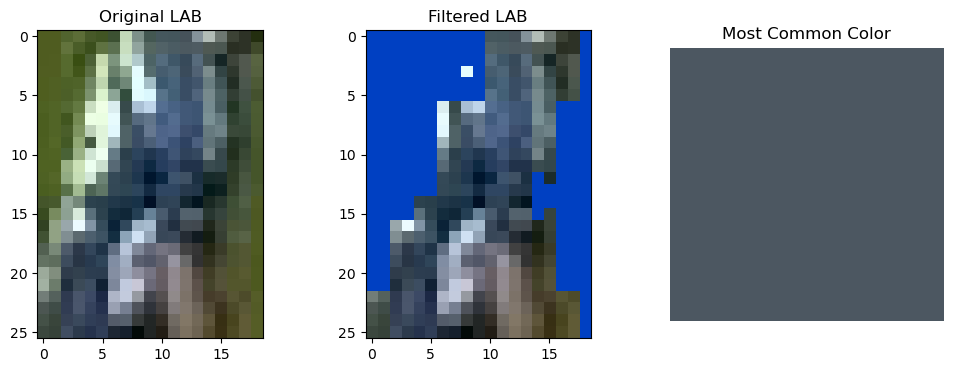

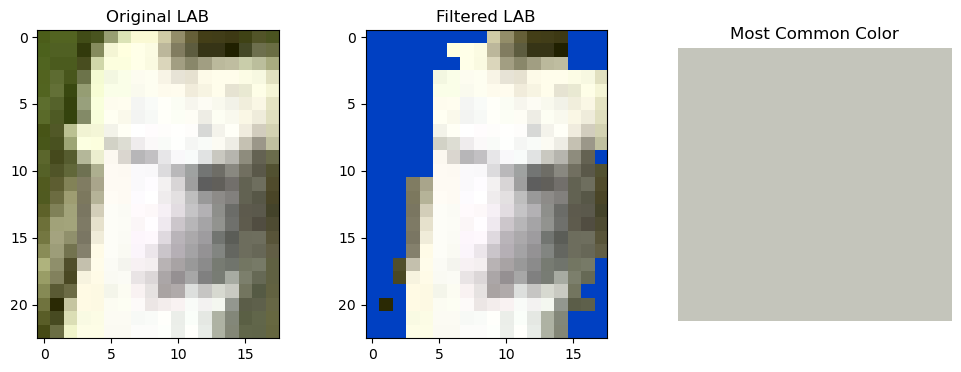

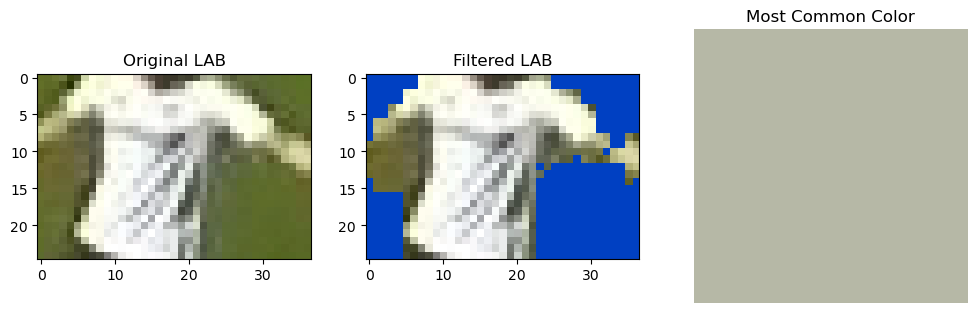

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f87a9940>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.5ms
Spe

7


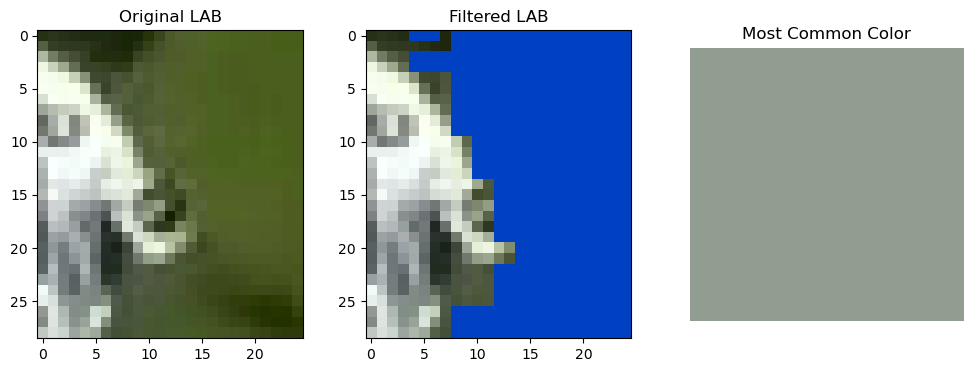

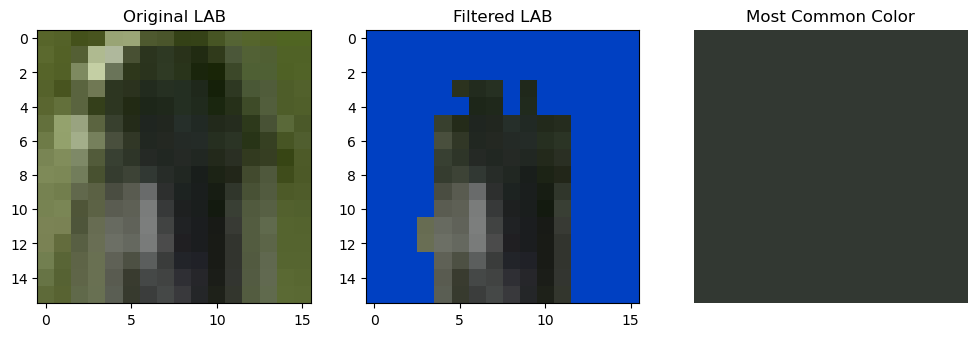

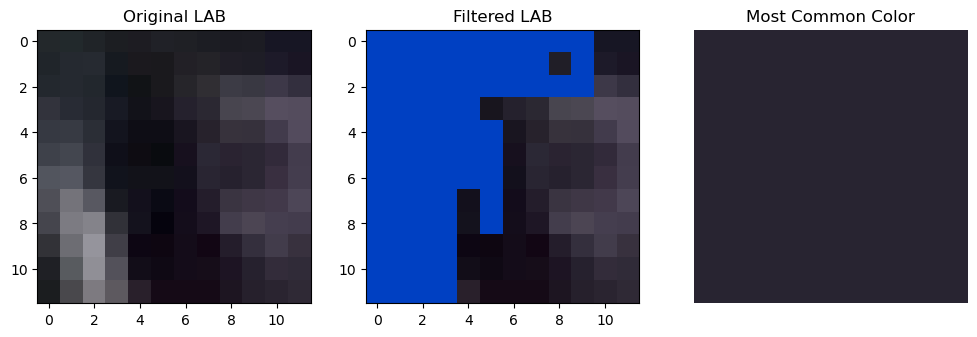

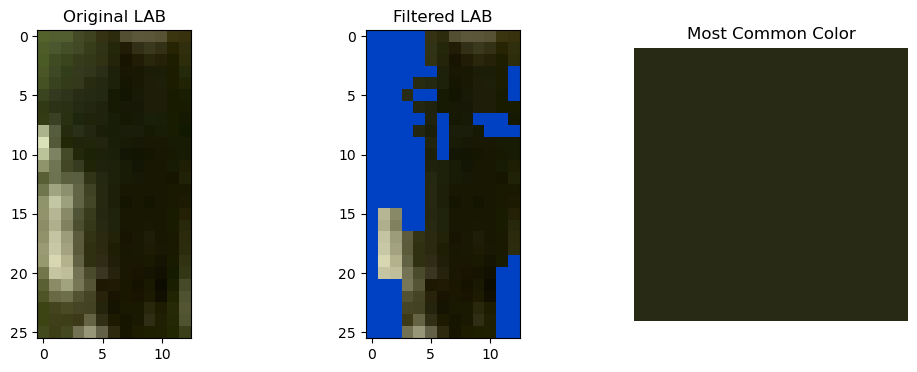

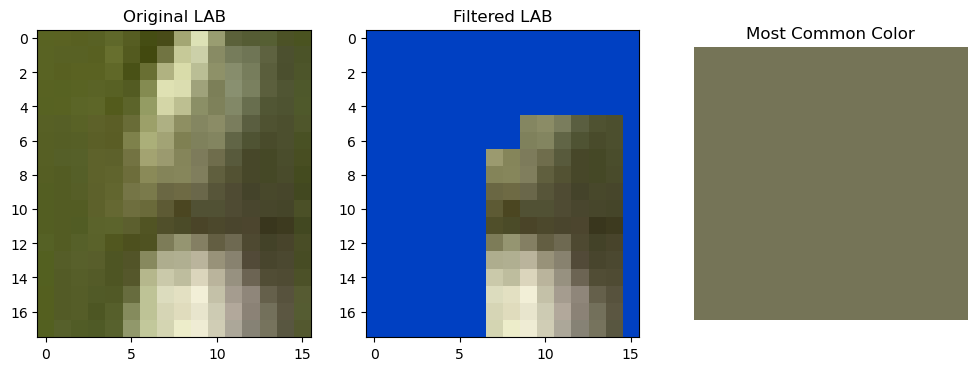

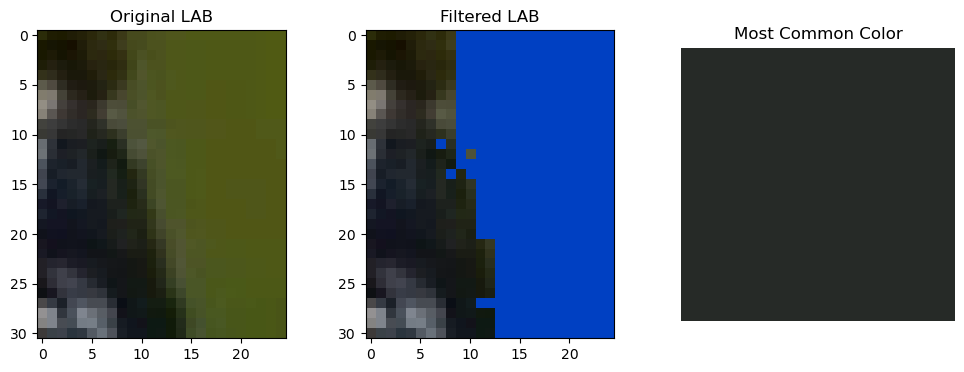

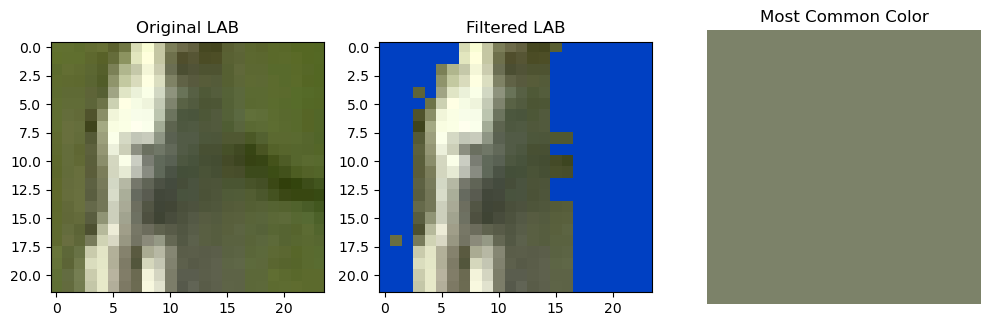

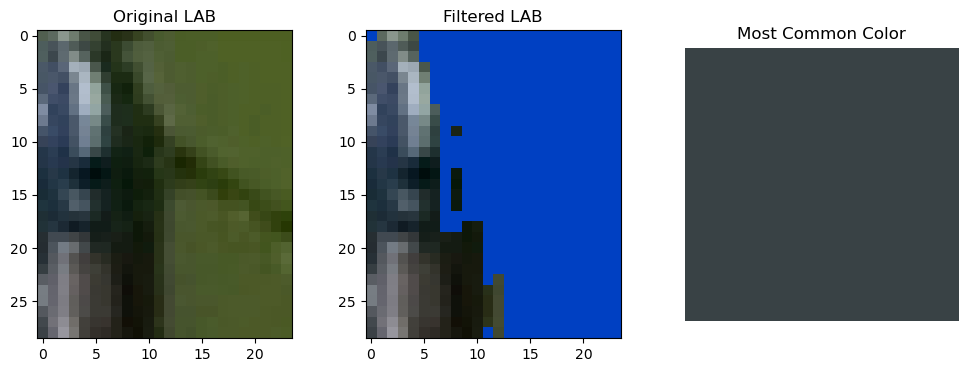

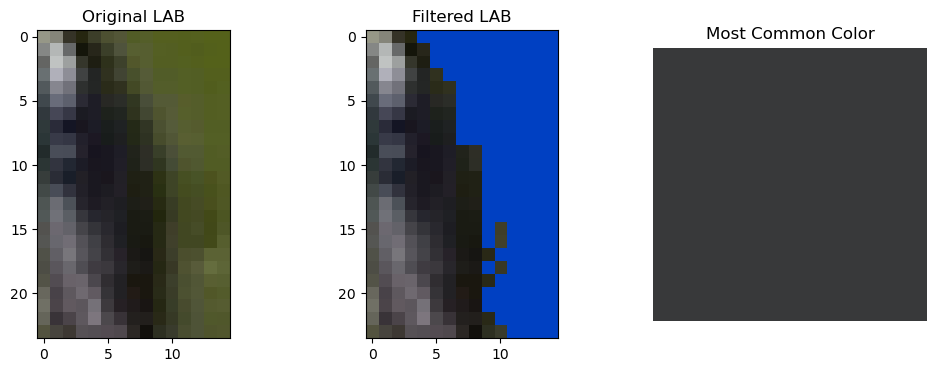

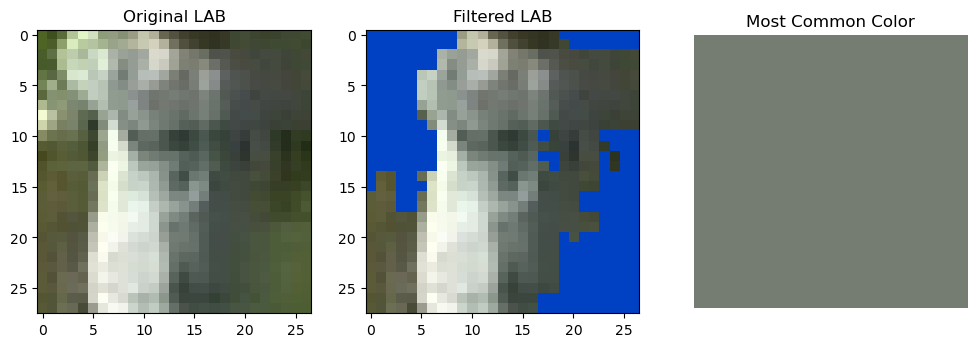

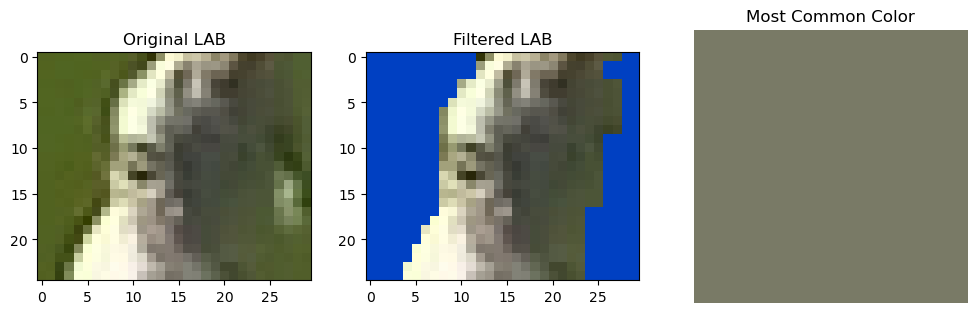

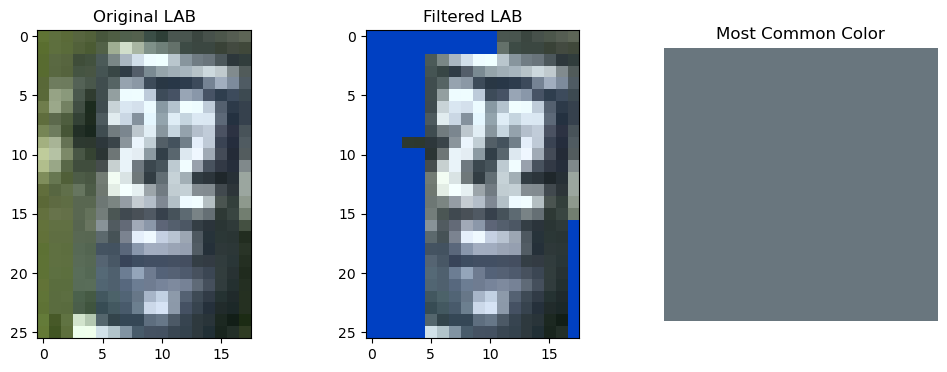

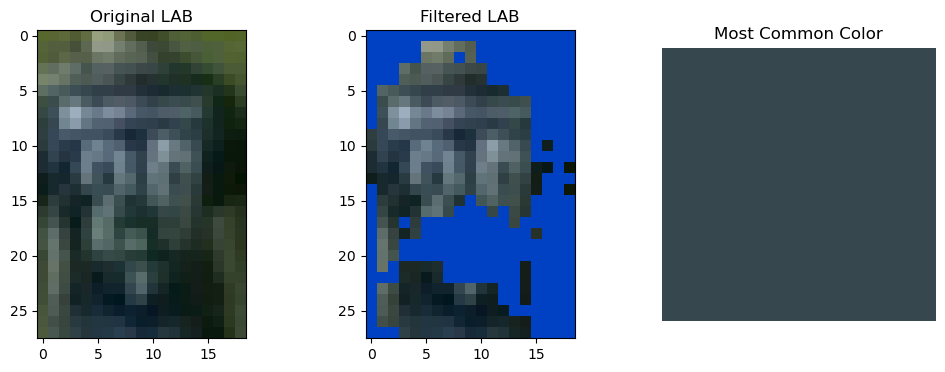

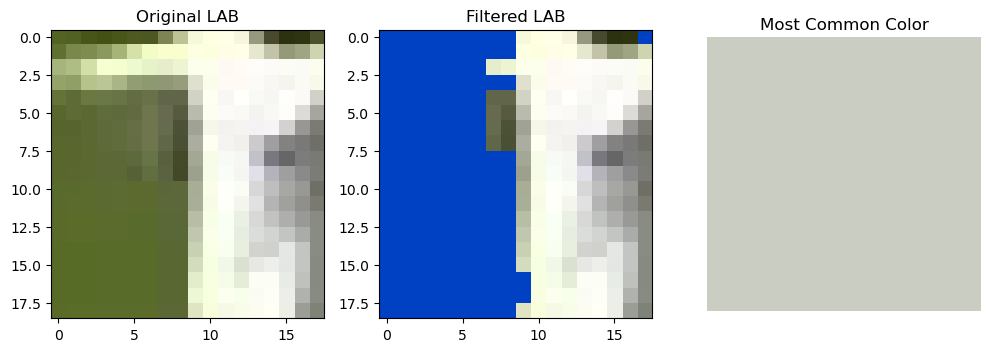

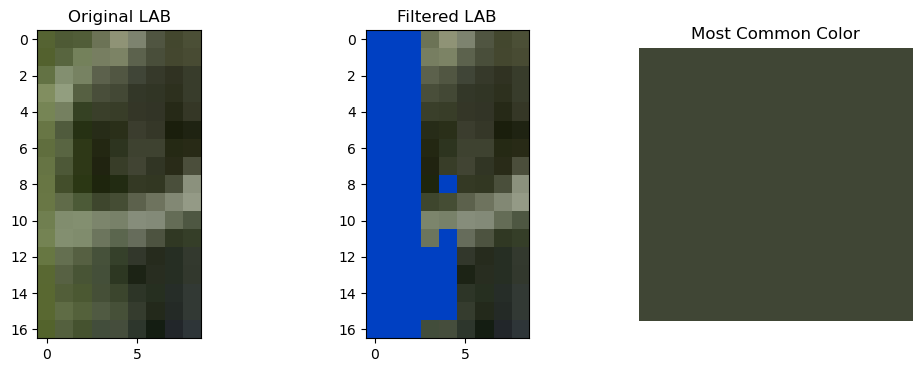

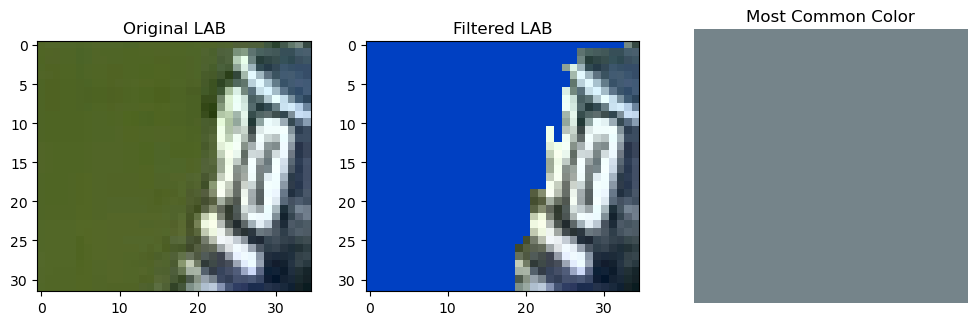

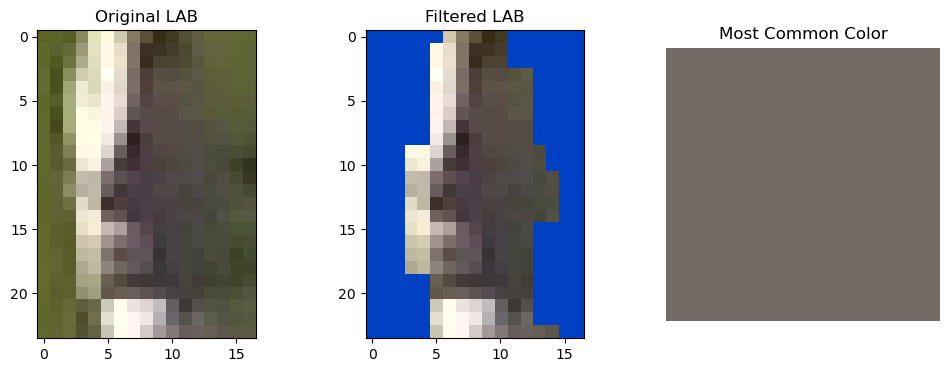

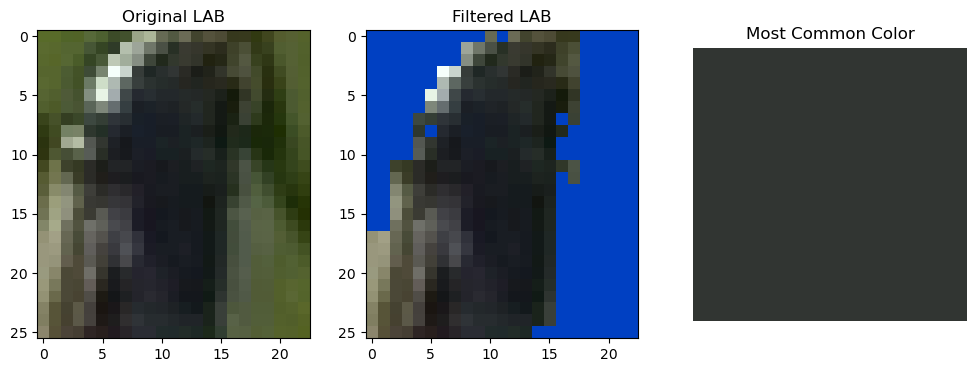

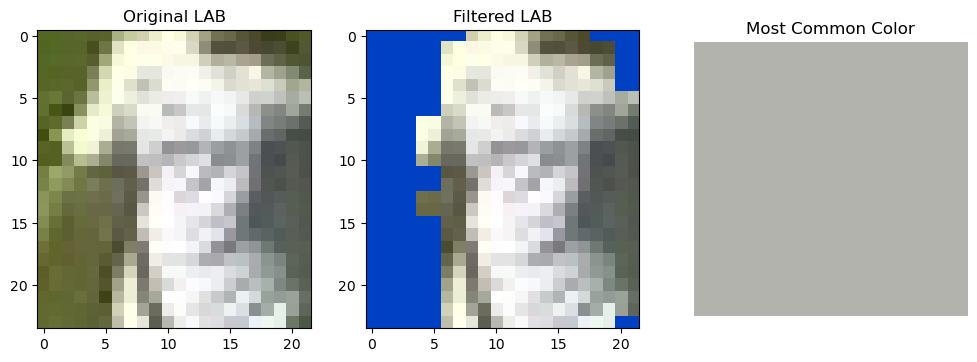

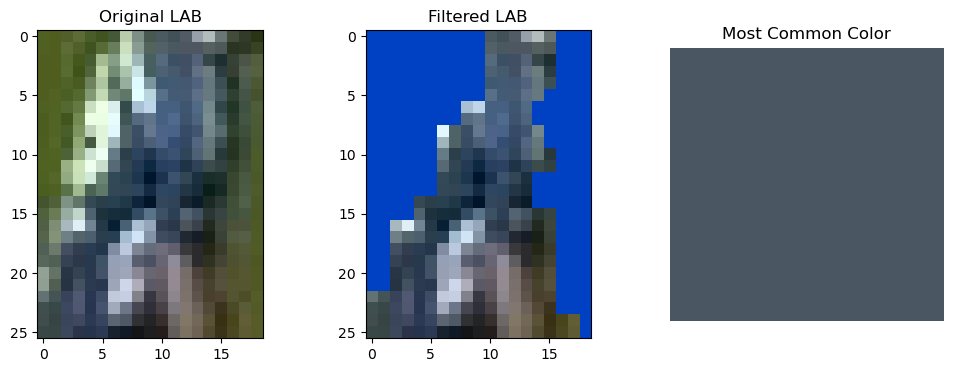

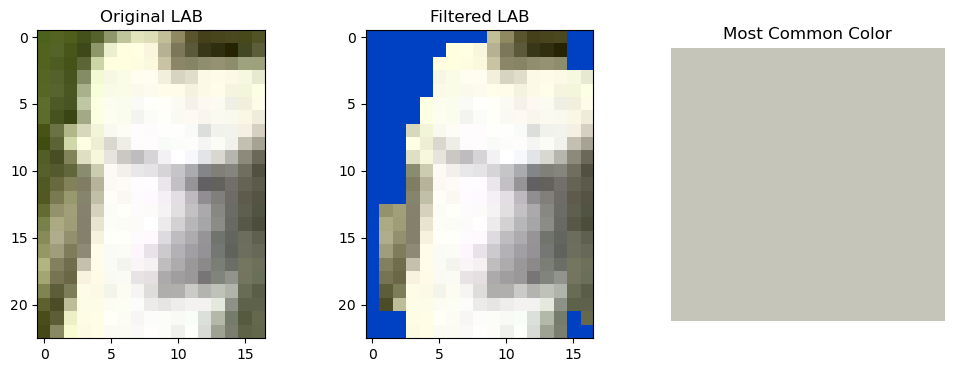

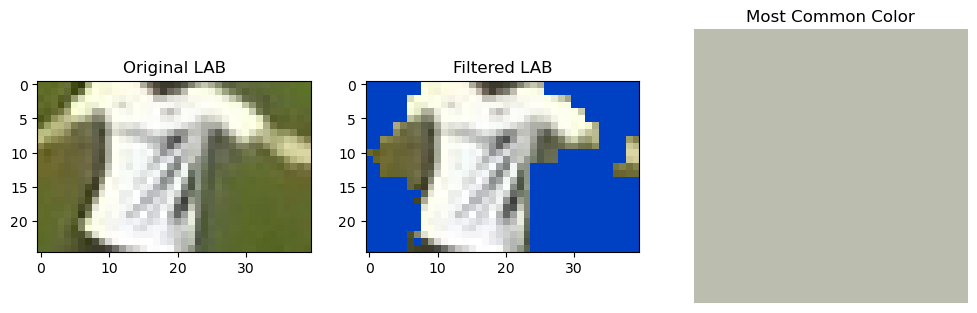

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x150250da4af0>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.4ms
Spe

8


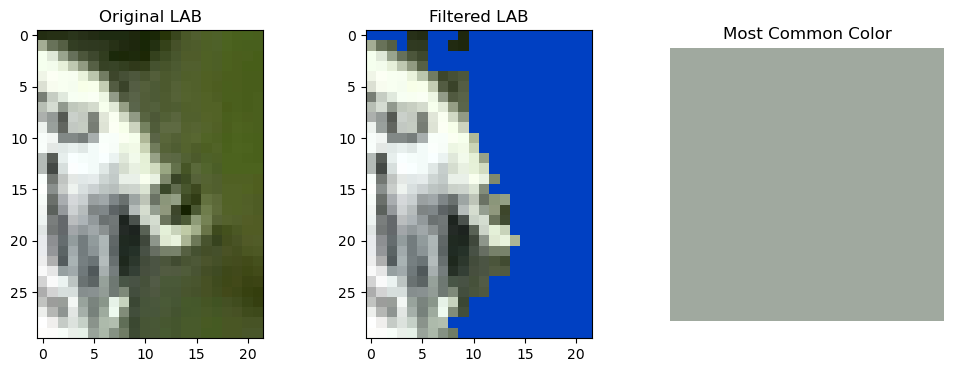

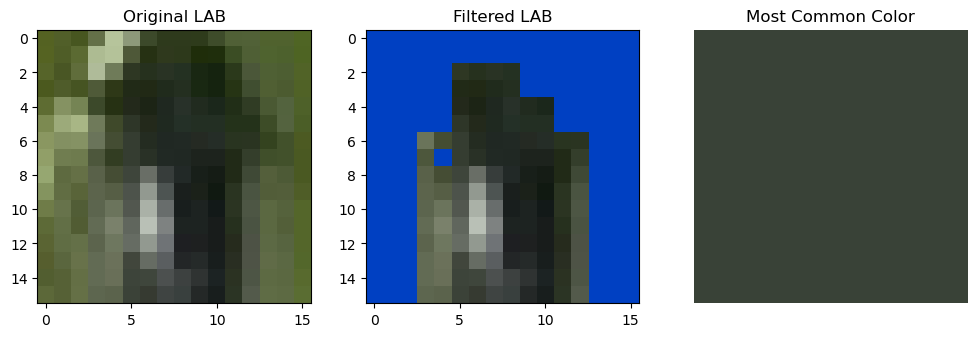

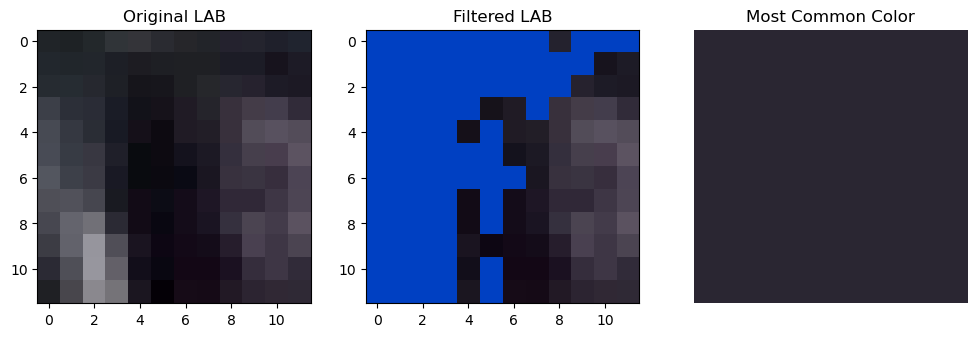

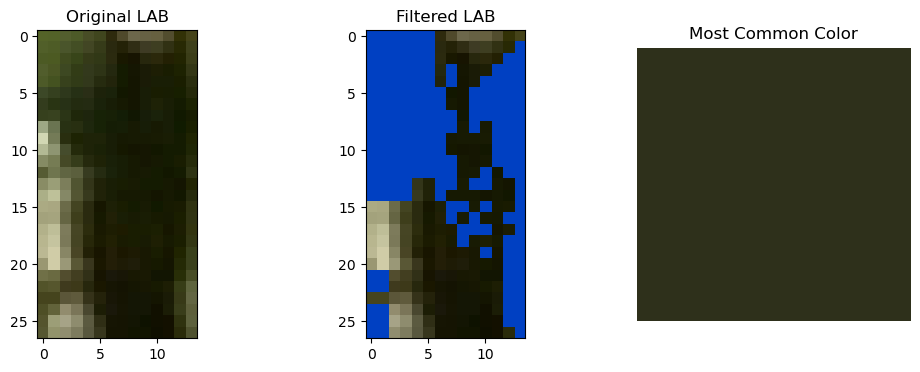

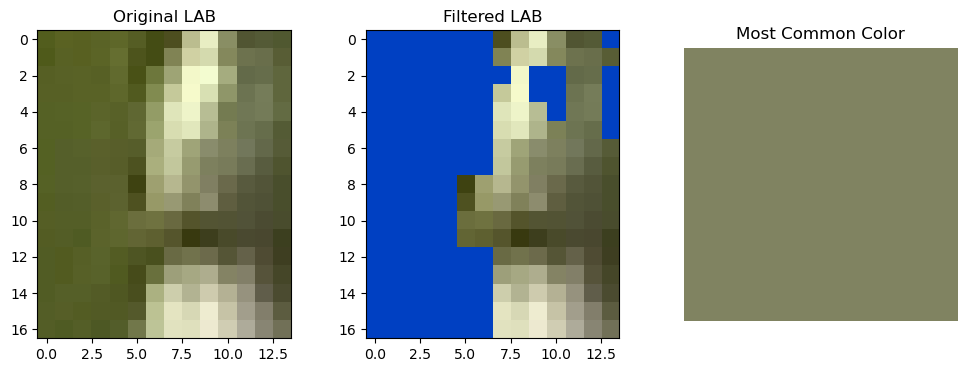

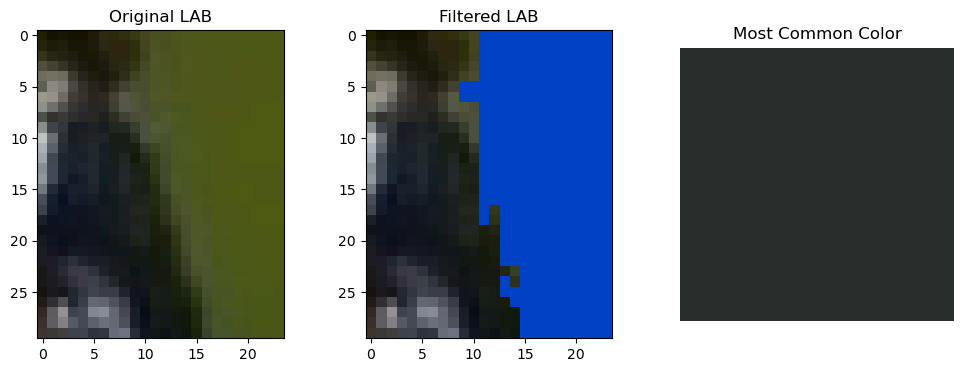

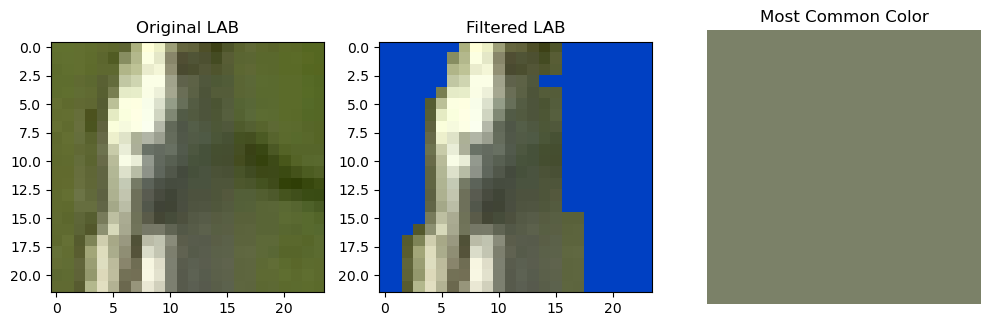

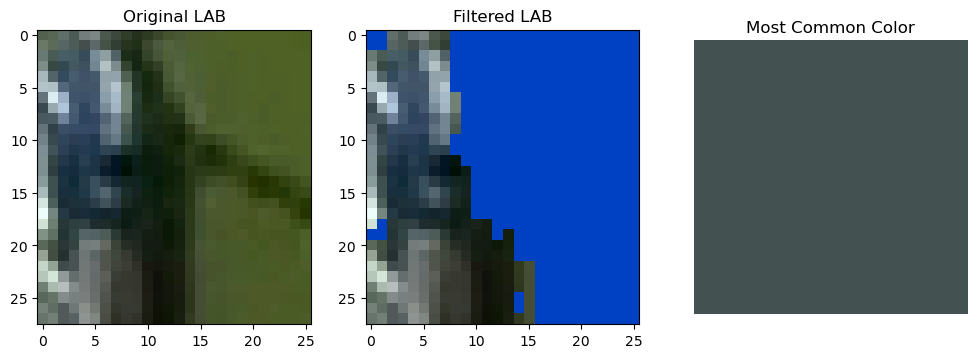

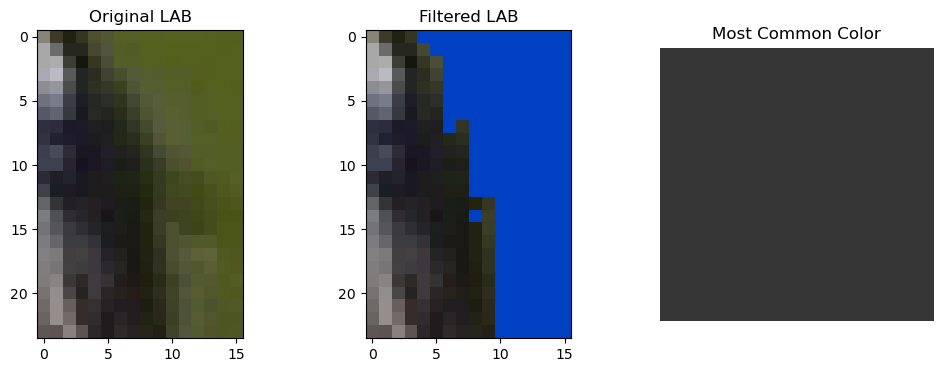

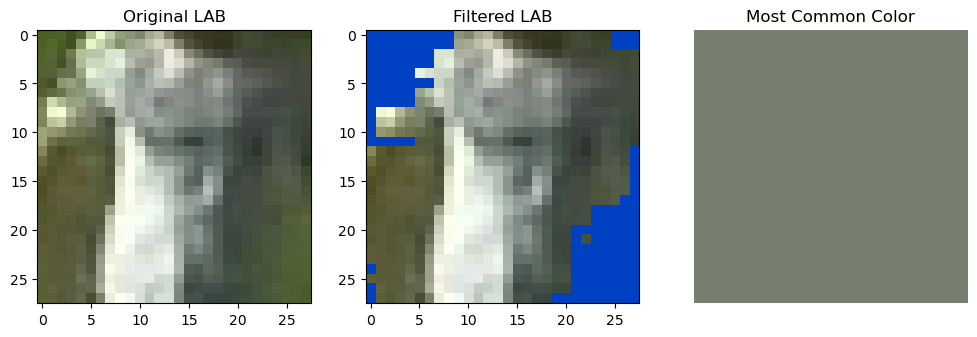

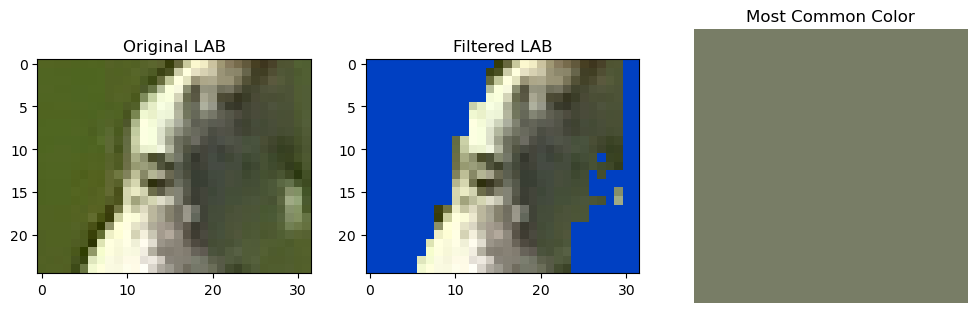

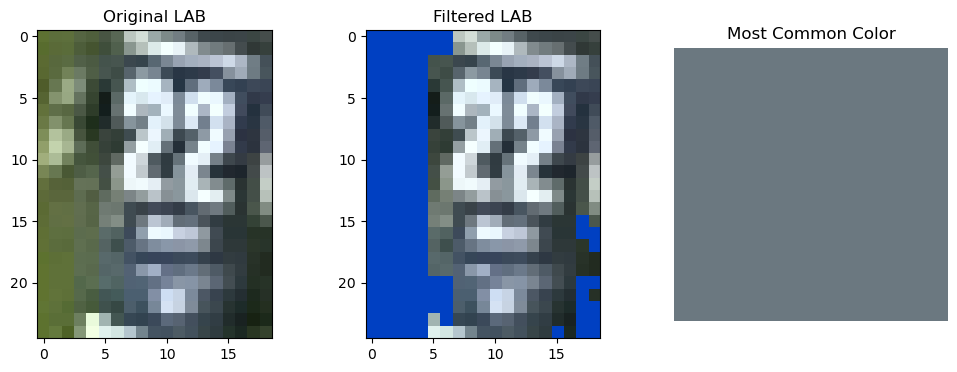

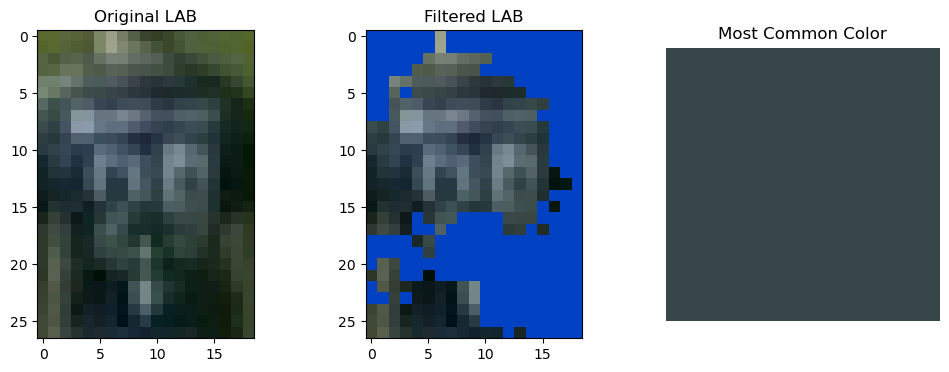

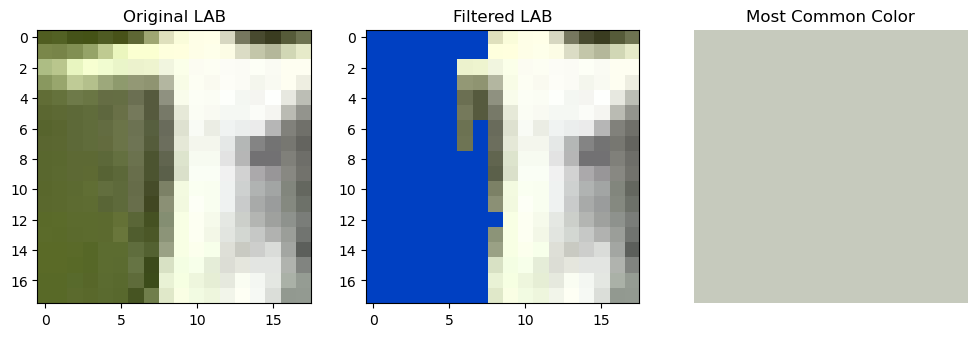

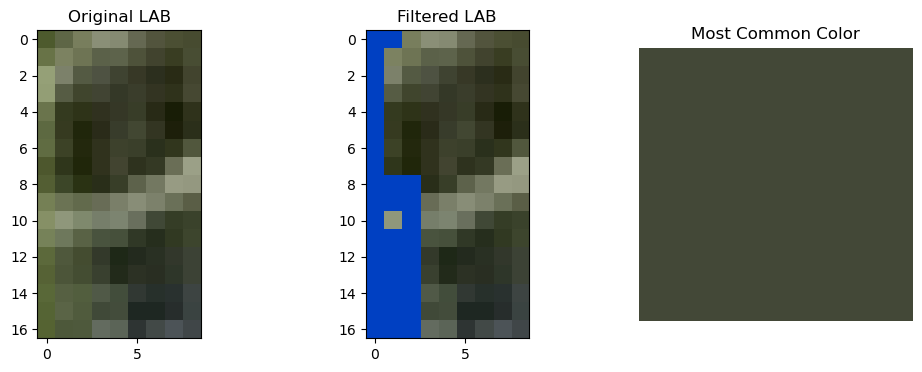

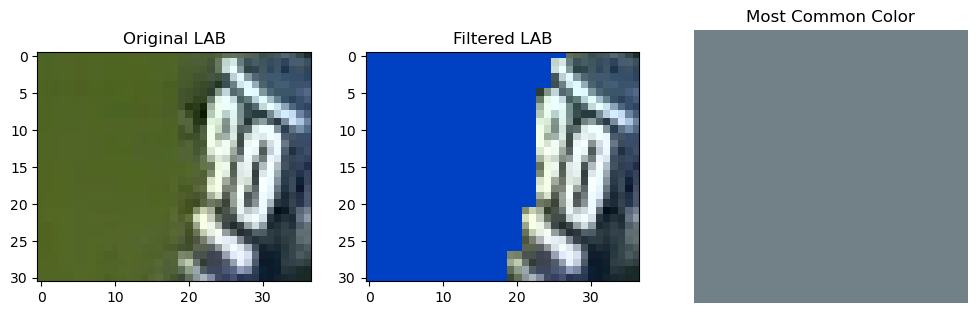

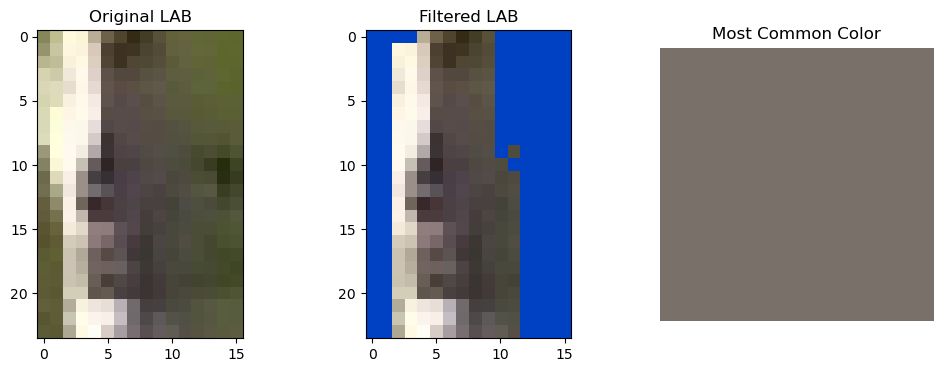

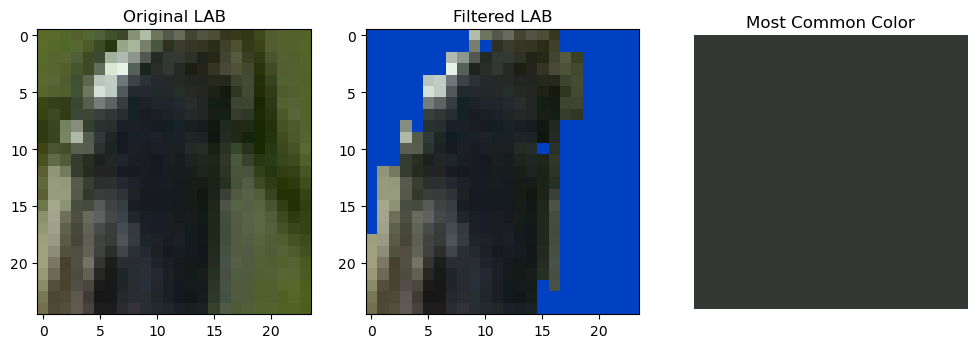

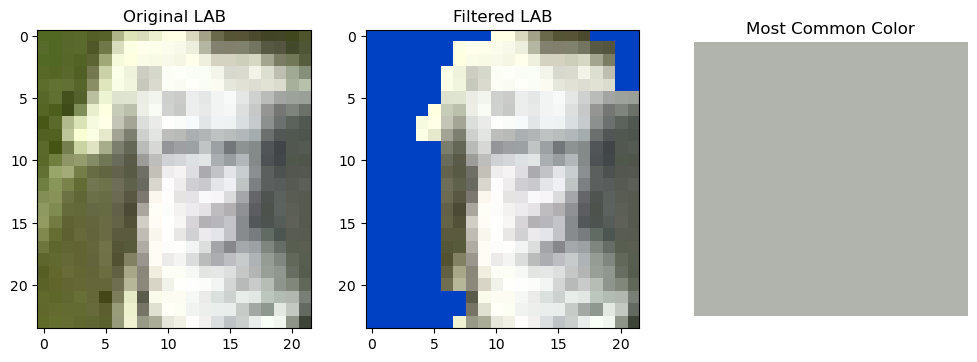

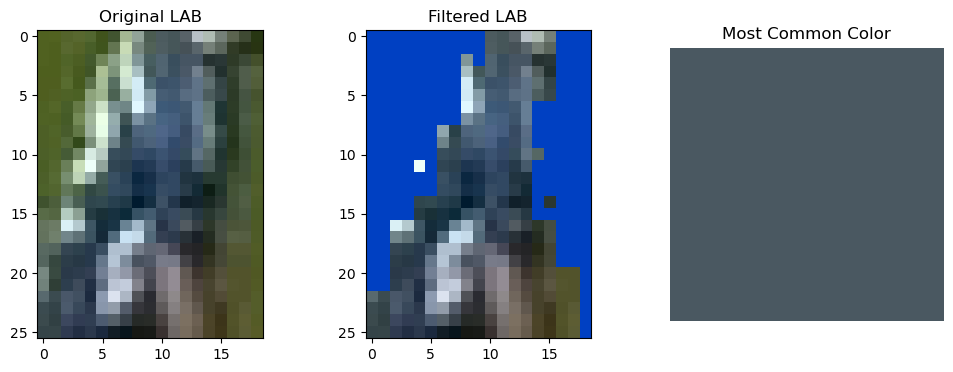

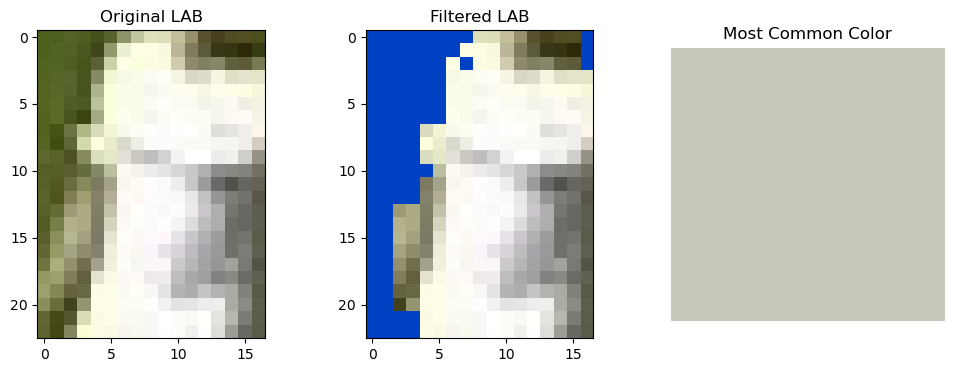

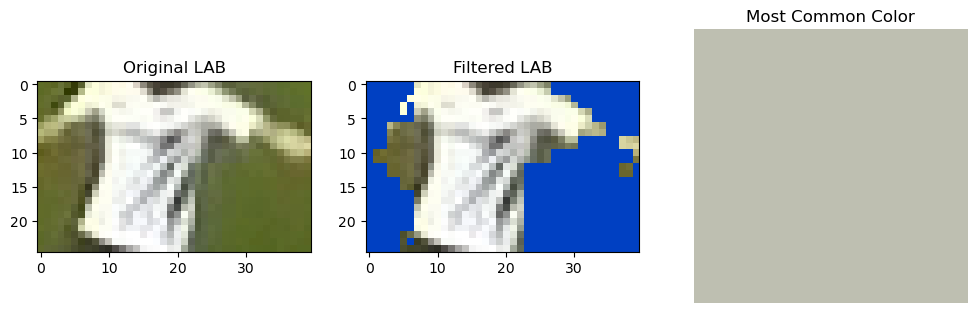

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1502693fa940>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.5ms
Spe

9


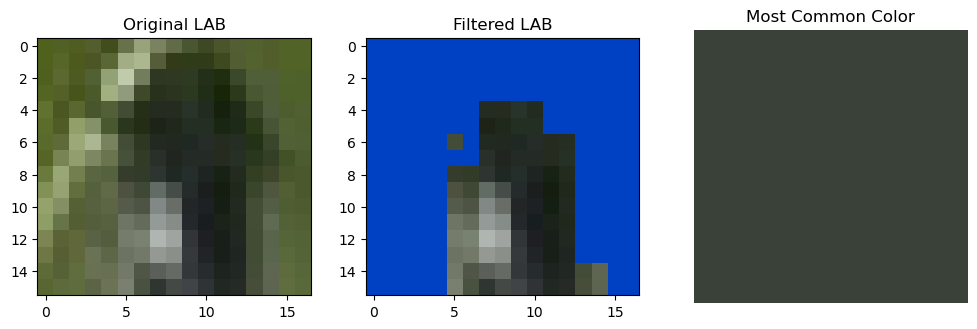

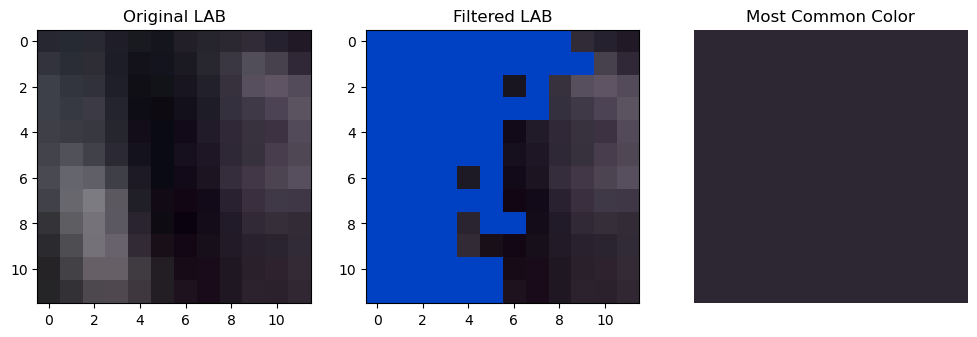

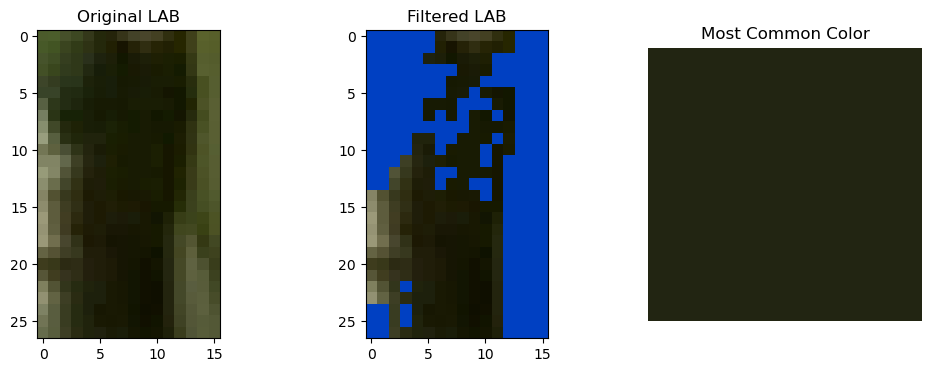

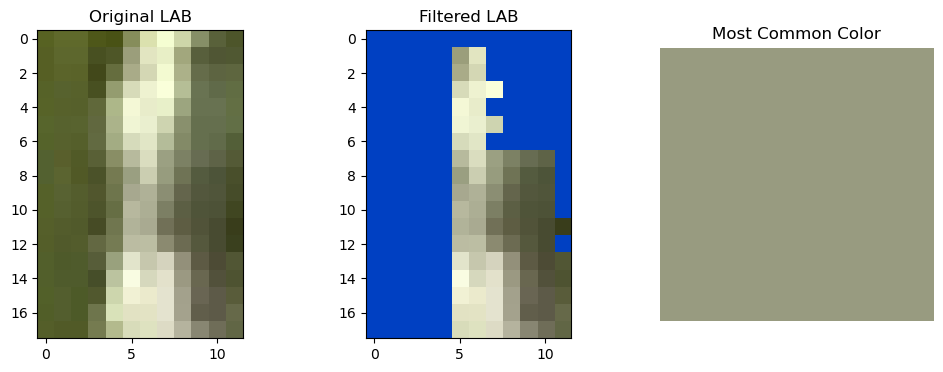

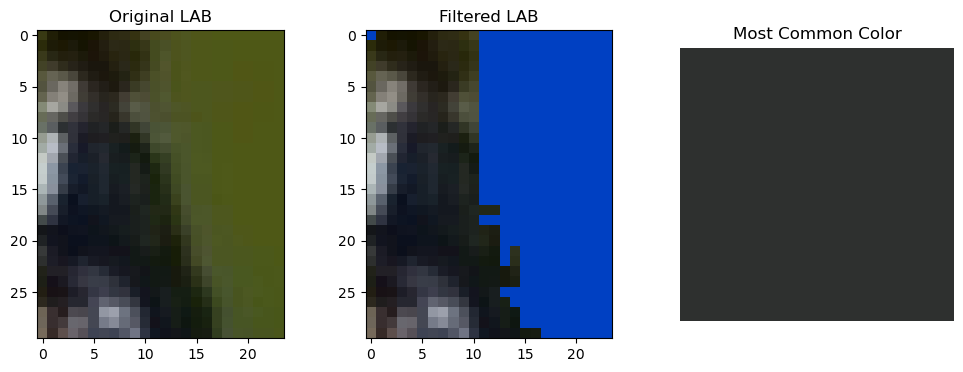

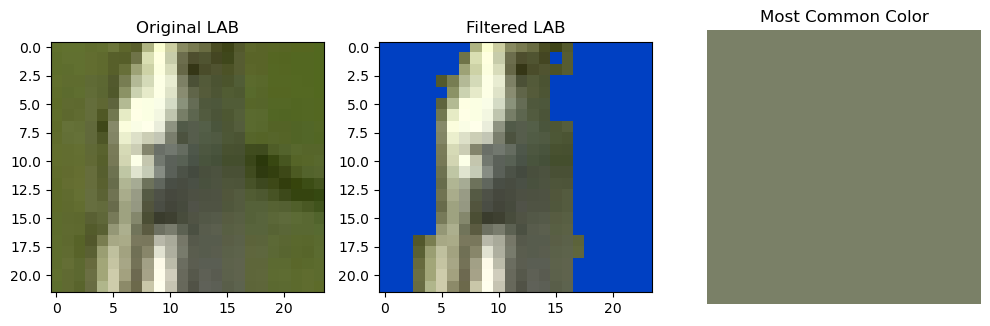

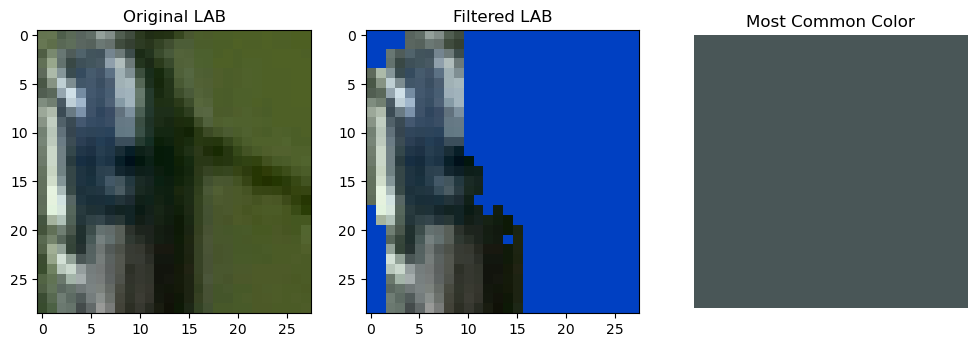

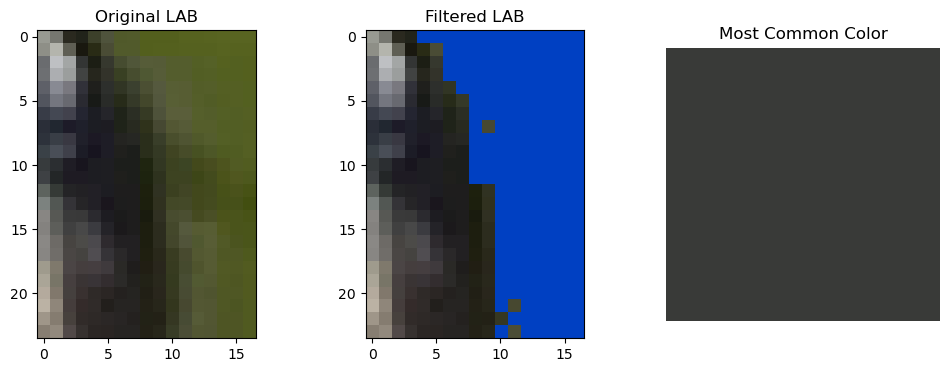

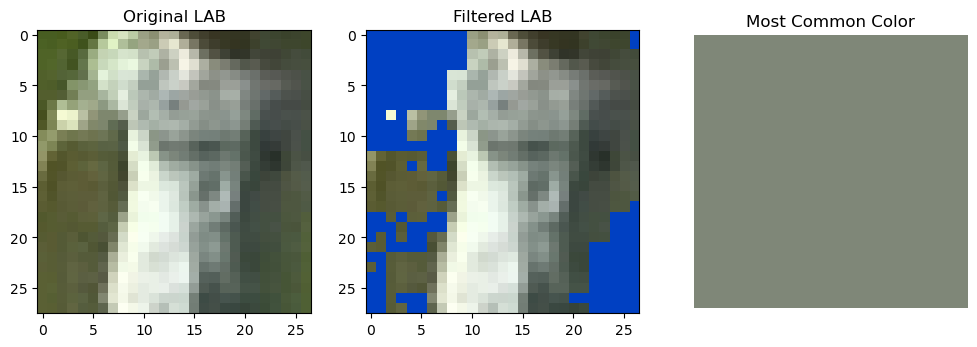

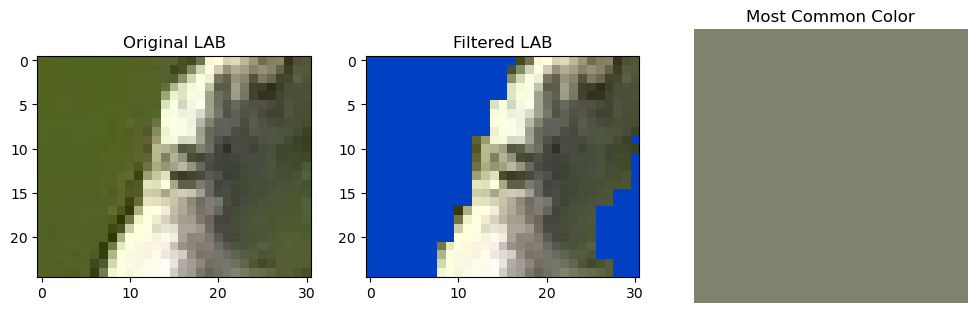

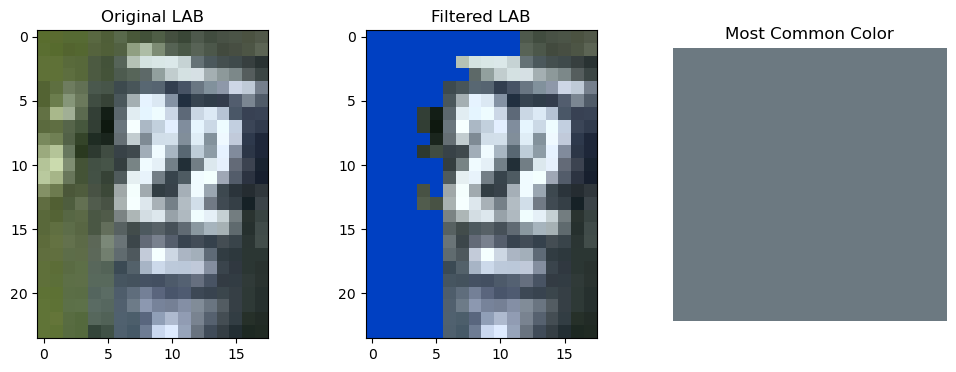

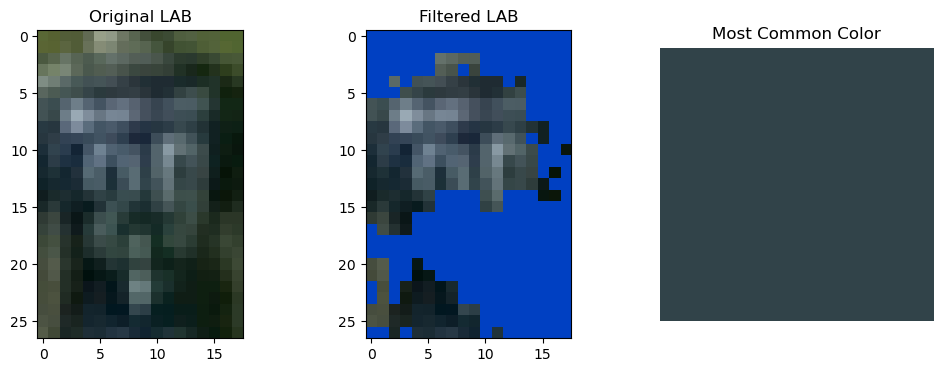

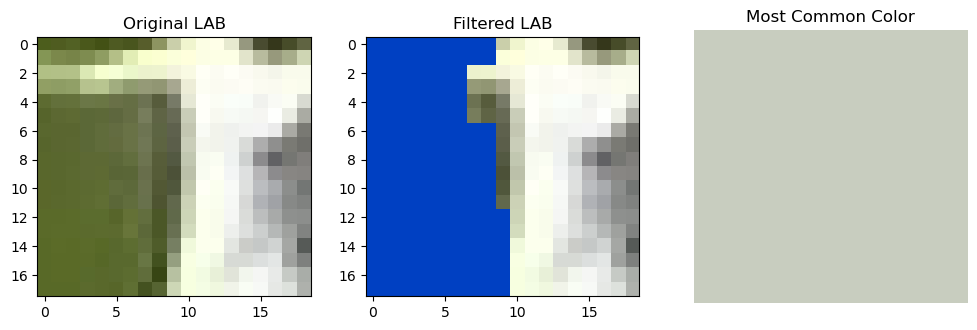

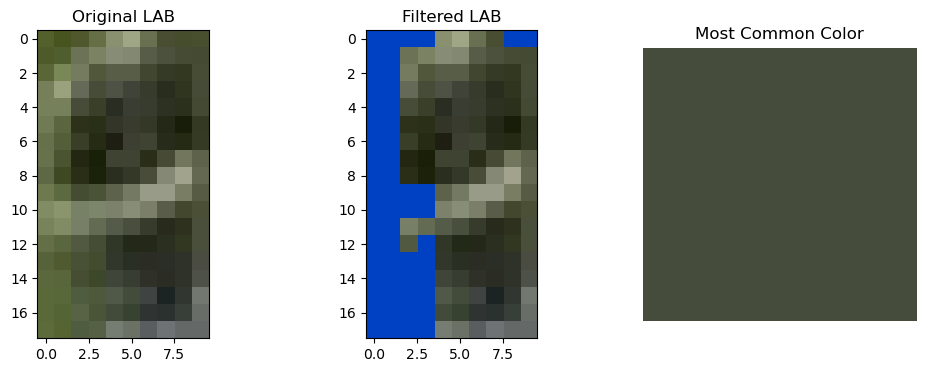

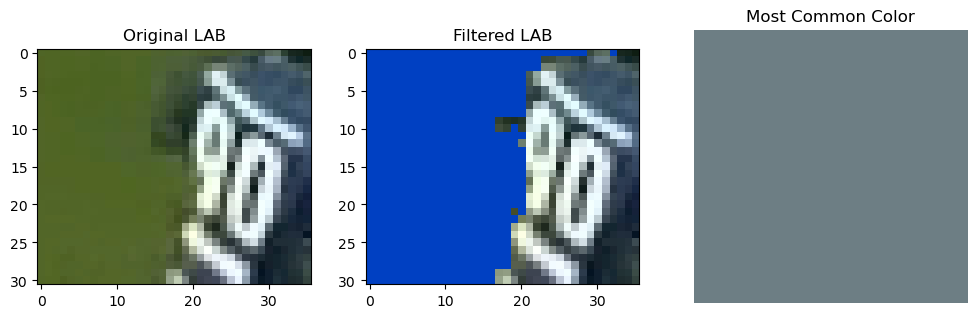

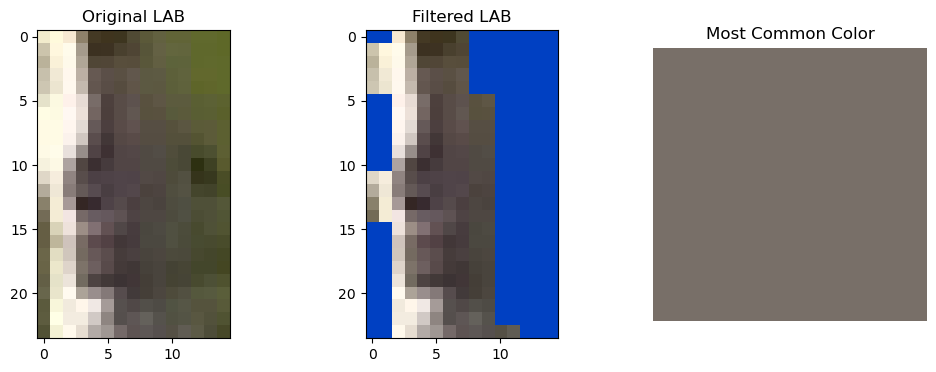

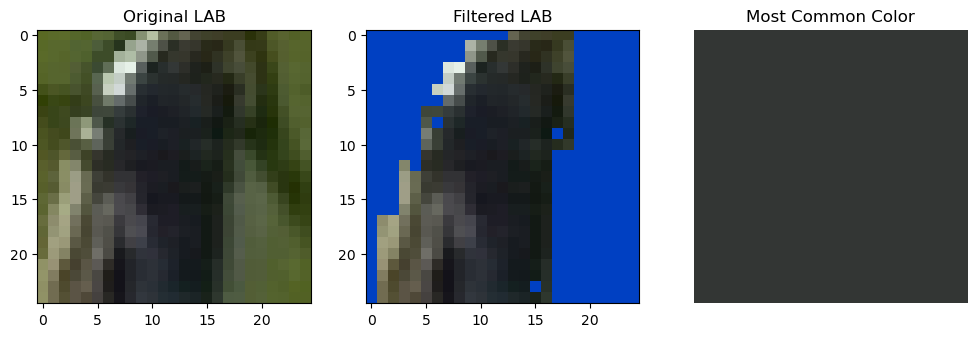

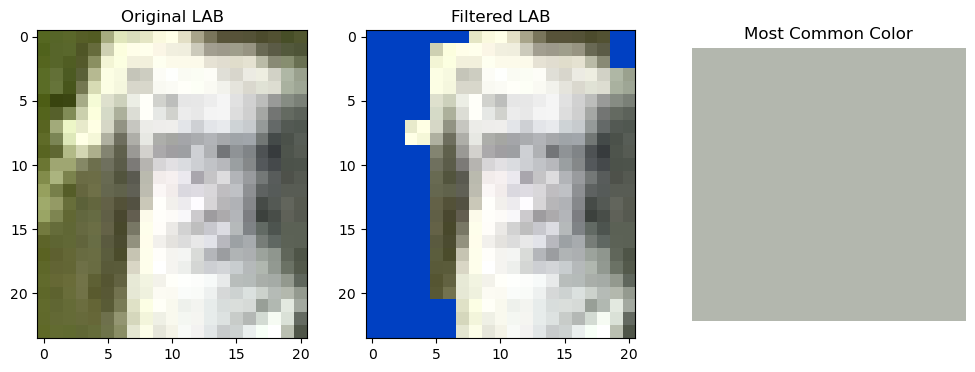

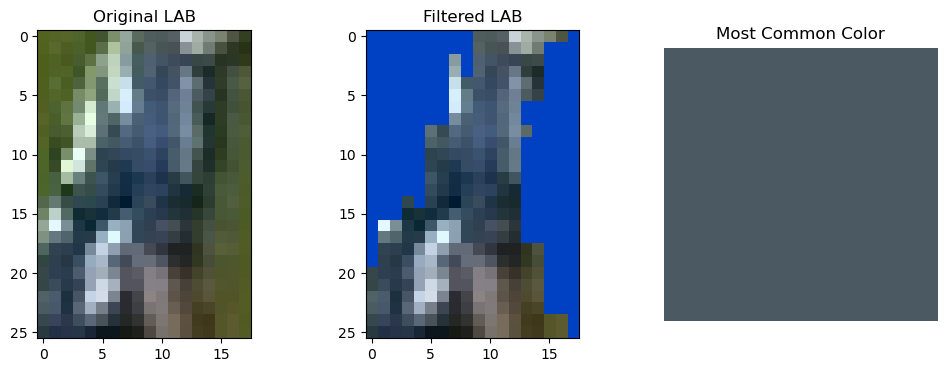

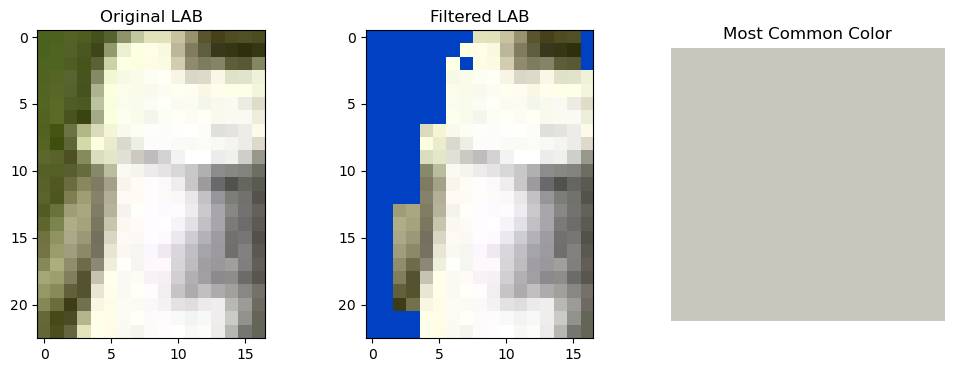

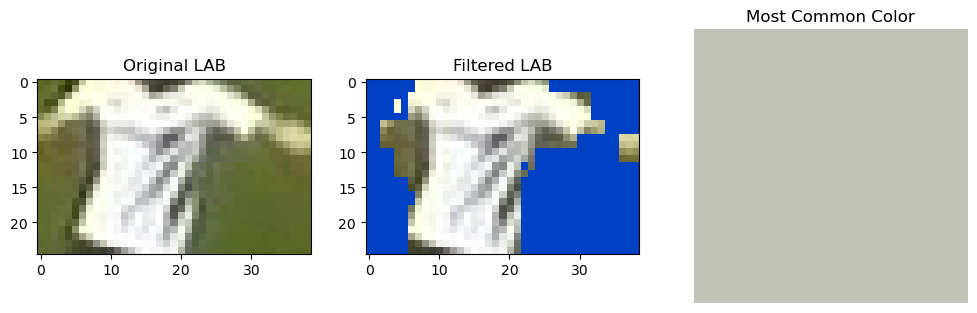

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f8baad30>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.4ms
Spe

10


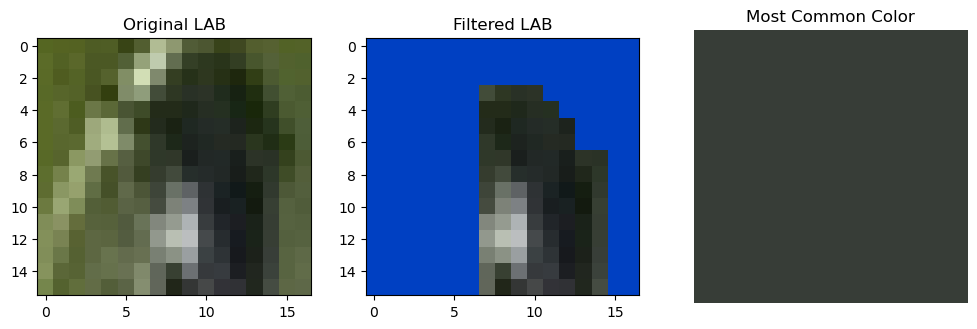

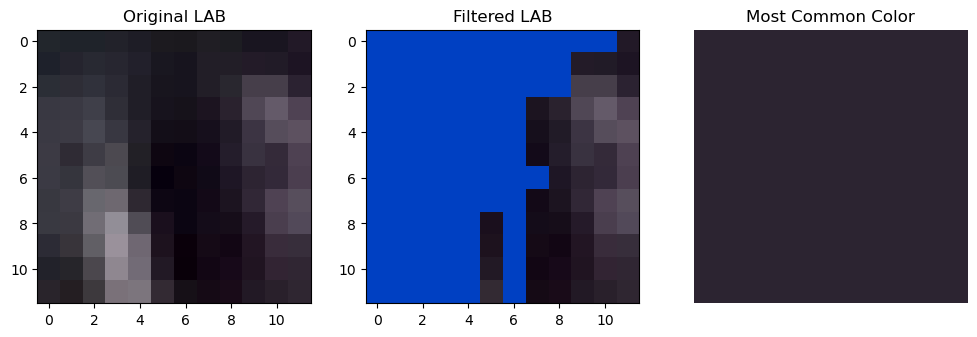

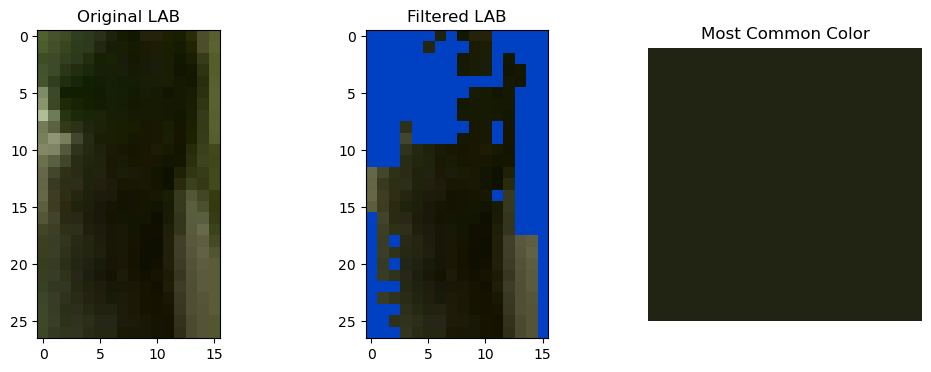

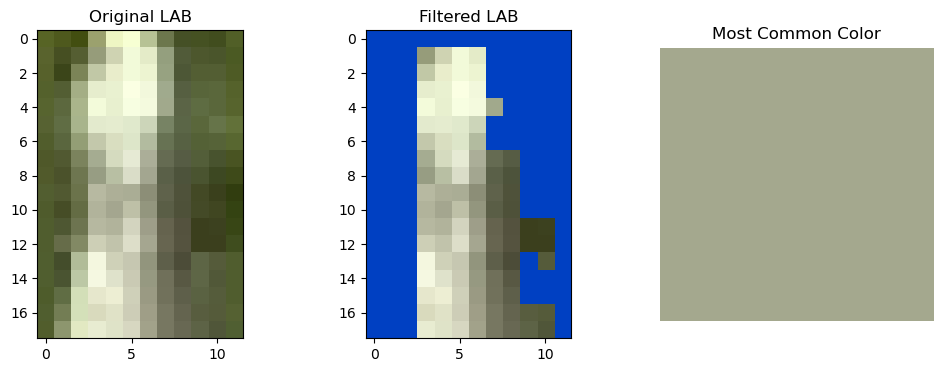

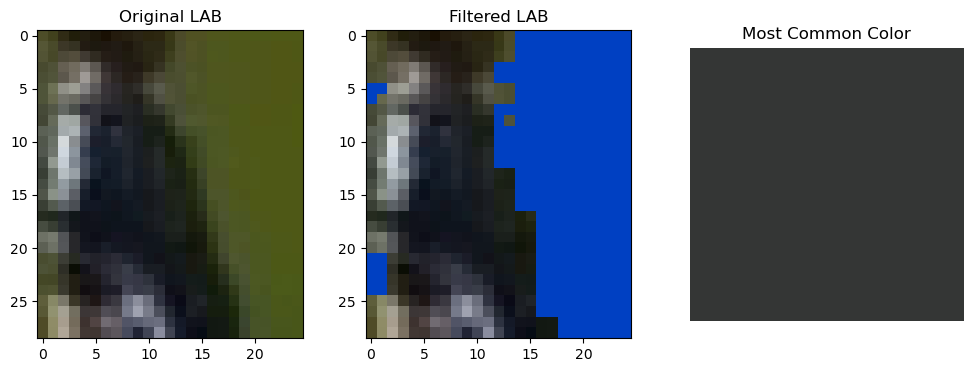

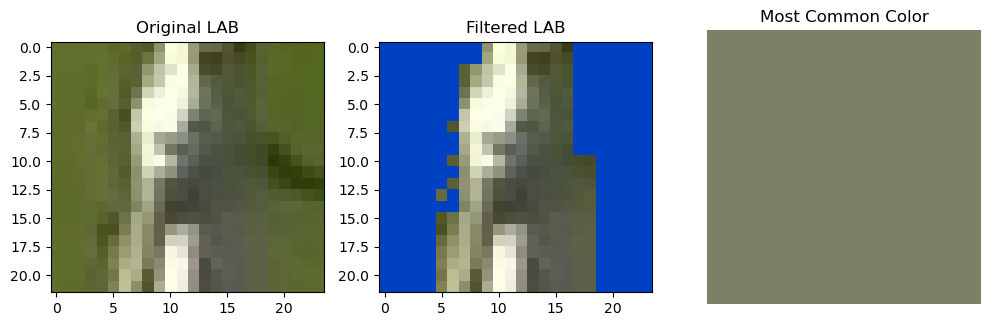

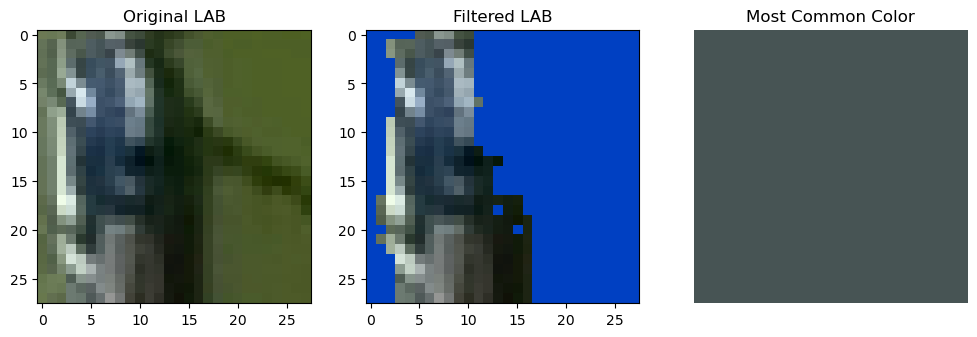

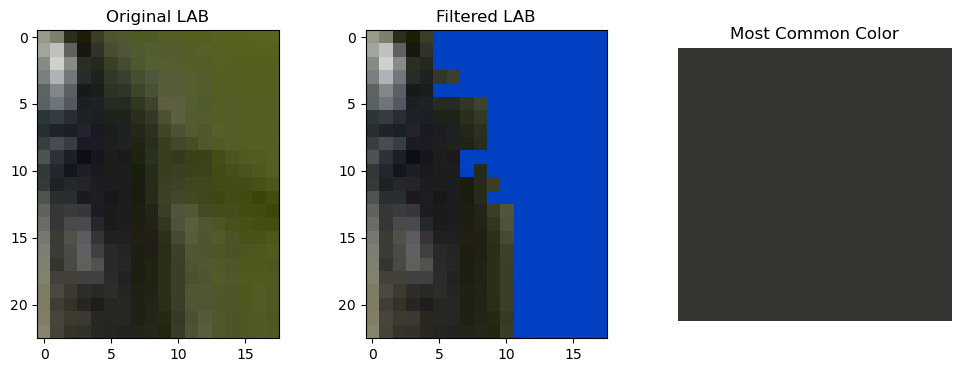

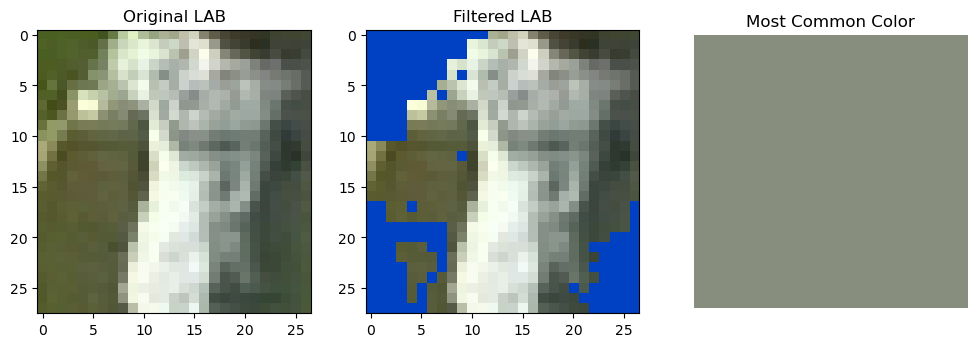

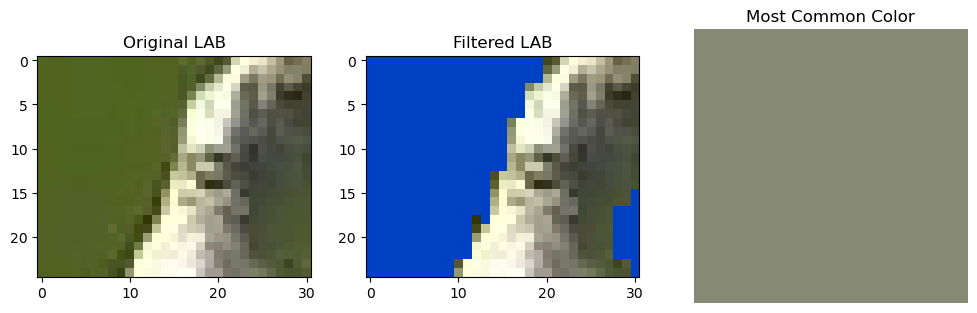

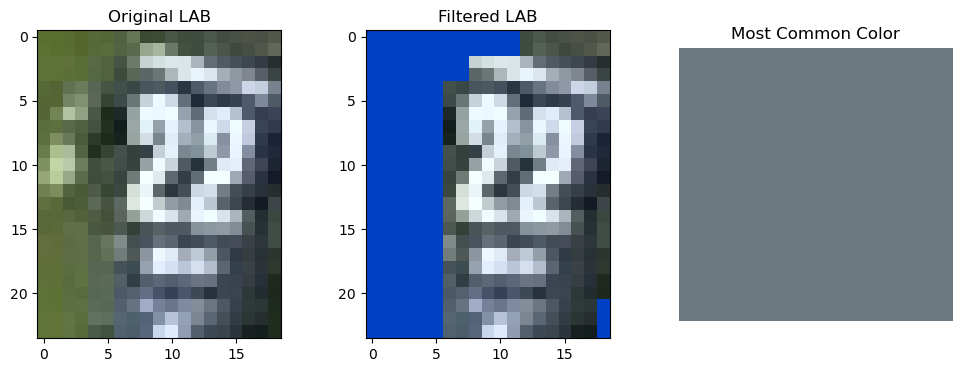

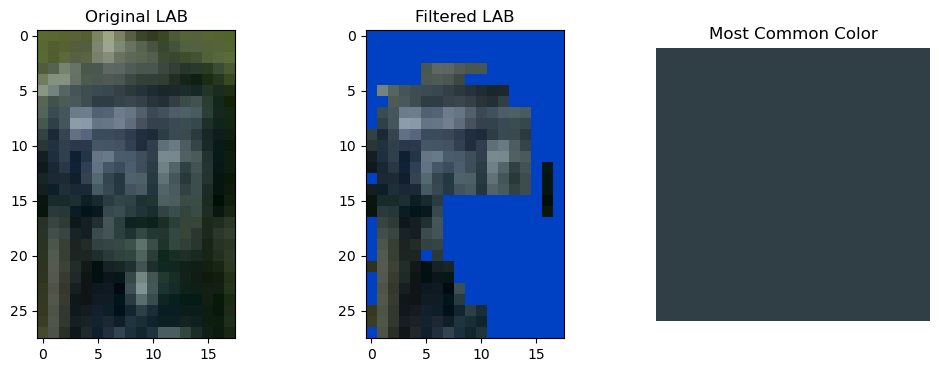

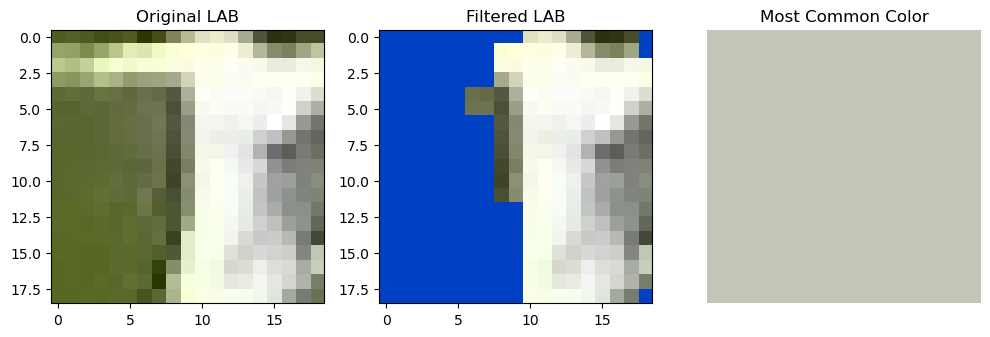

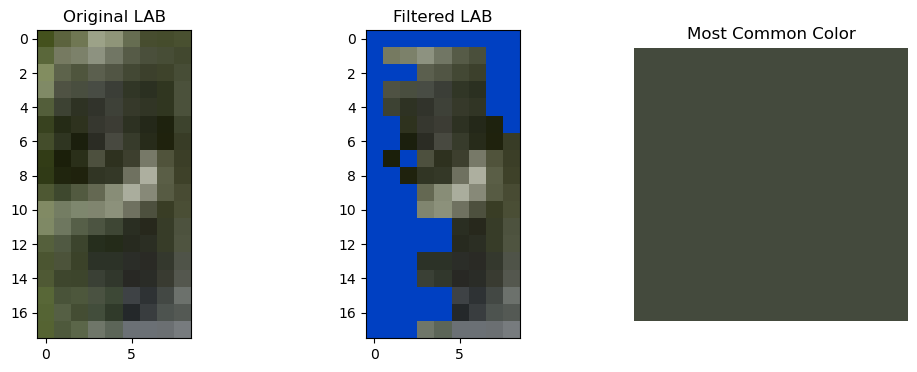

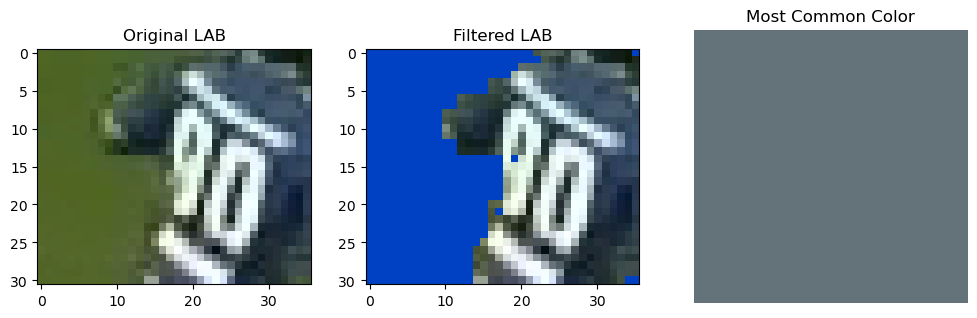

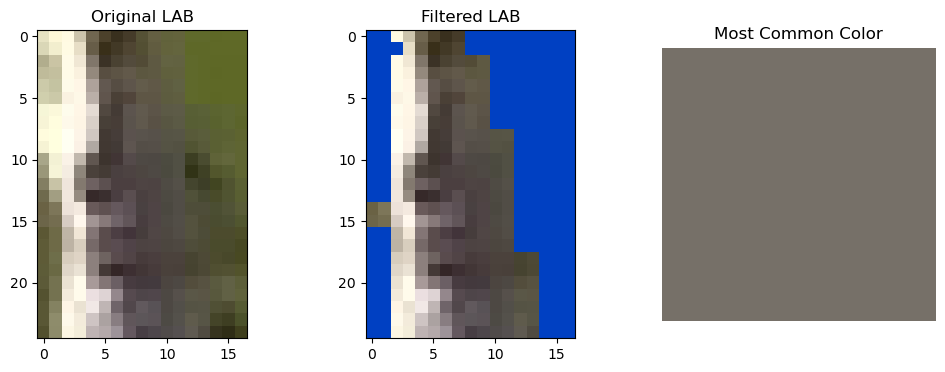

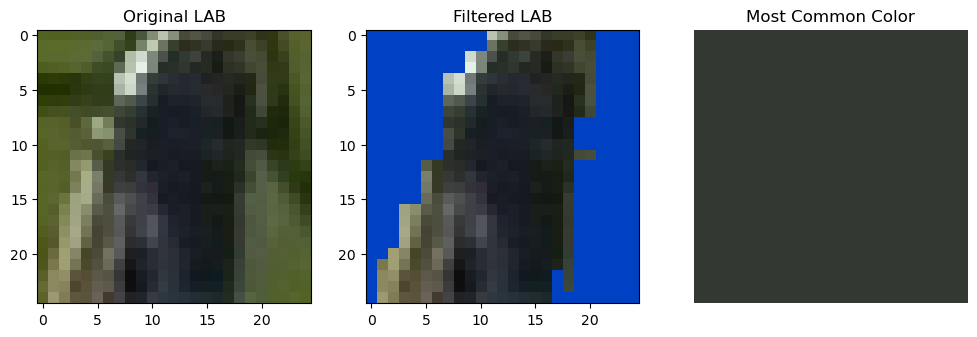

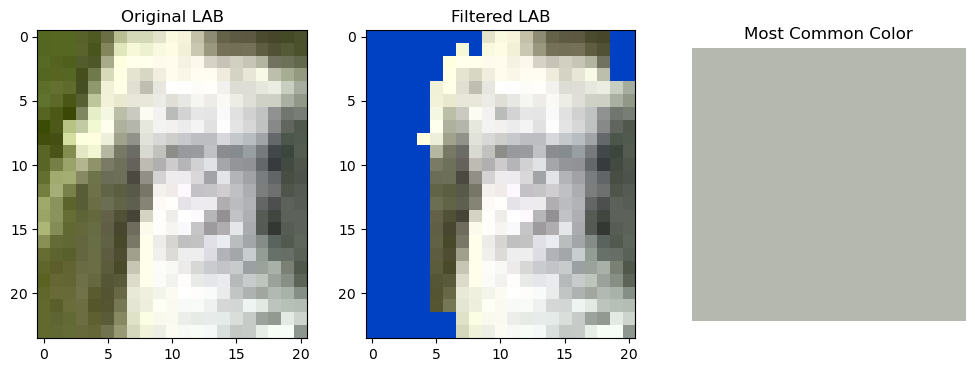

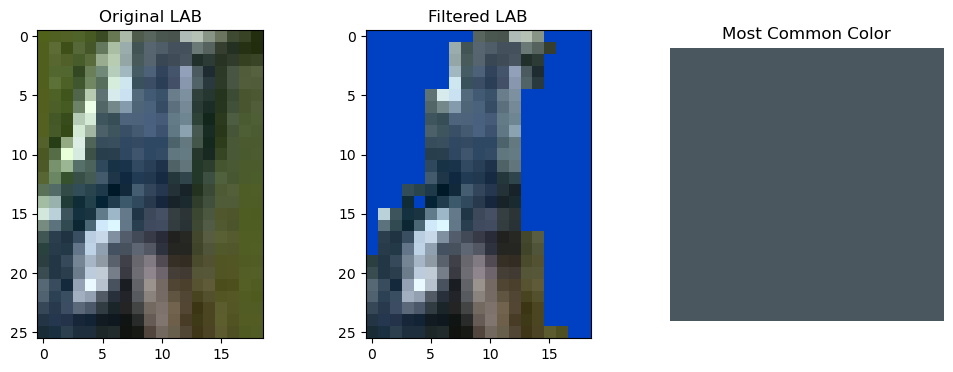

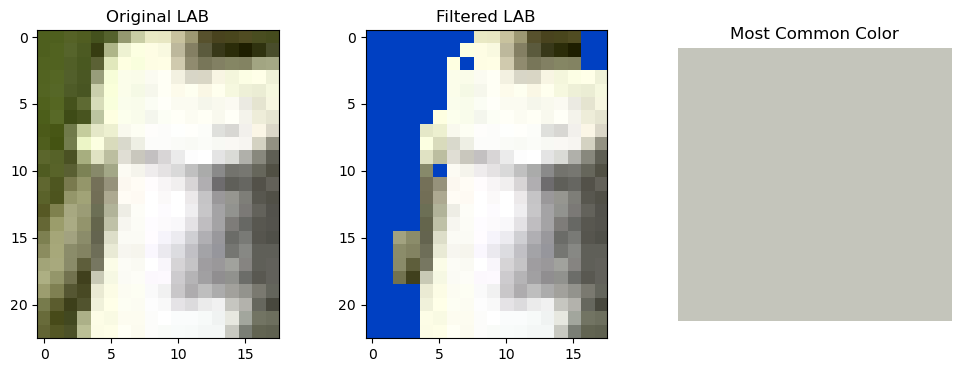

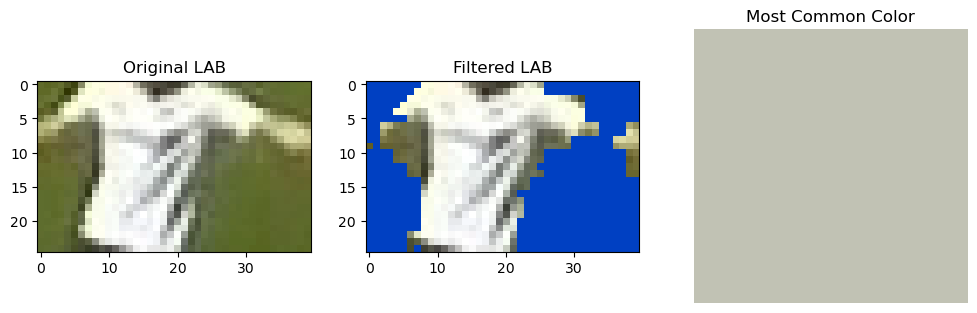

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f8baad30>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.5ms
Spe

11


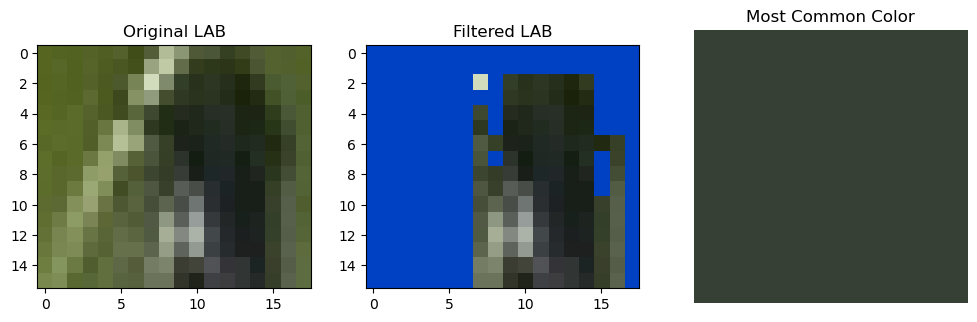

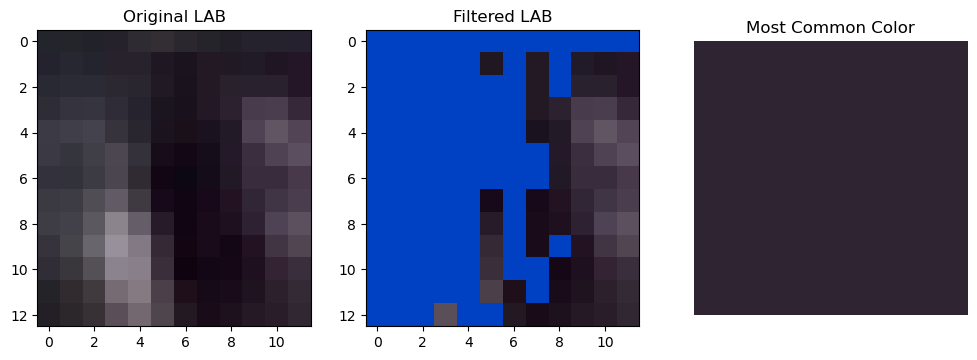

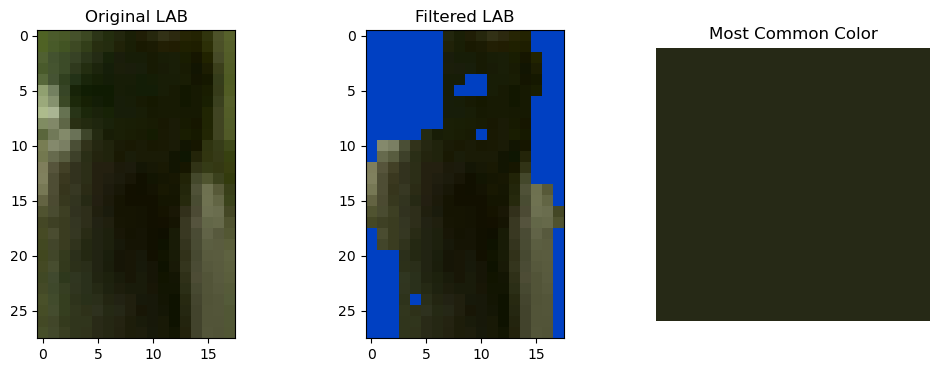

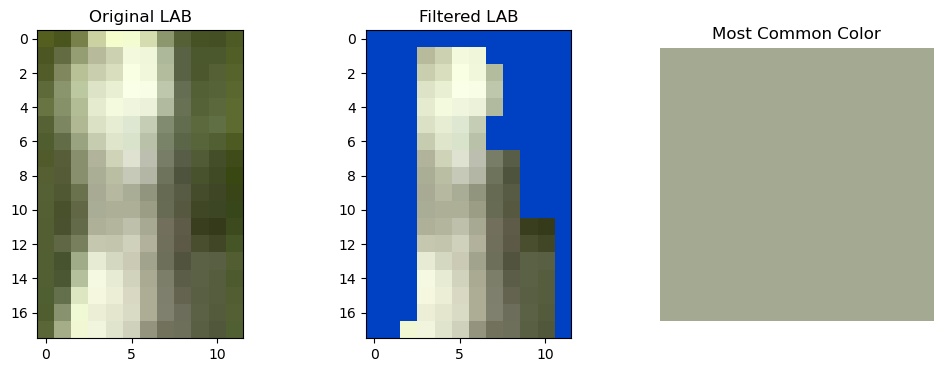

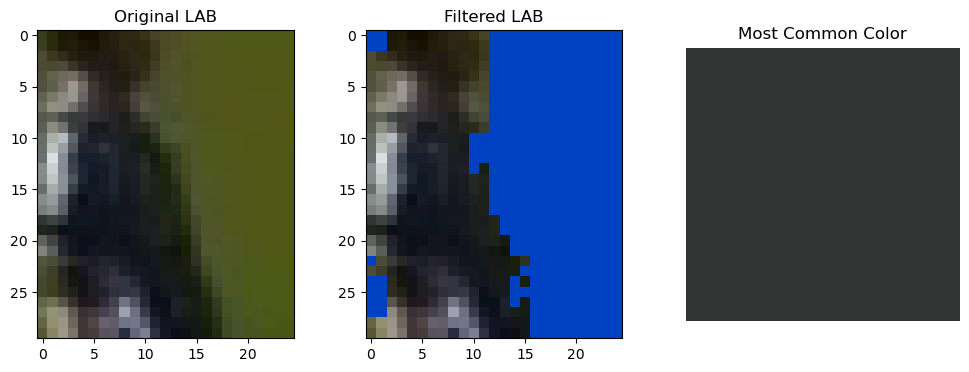

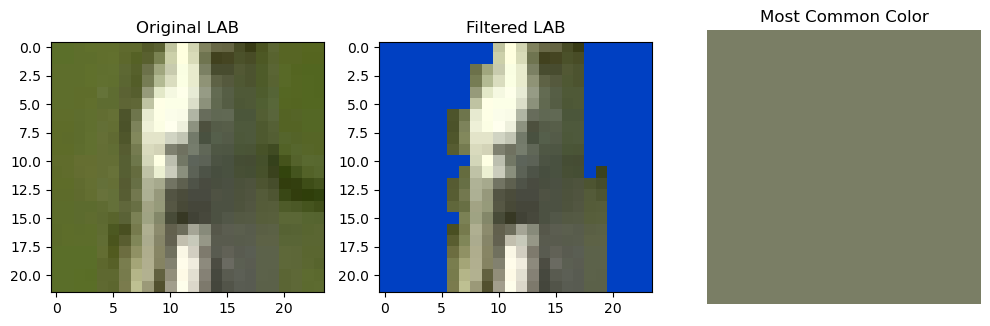

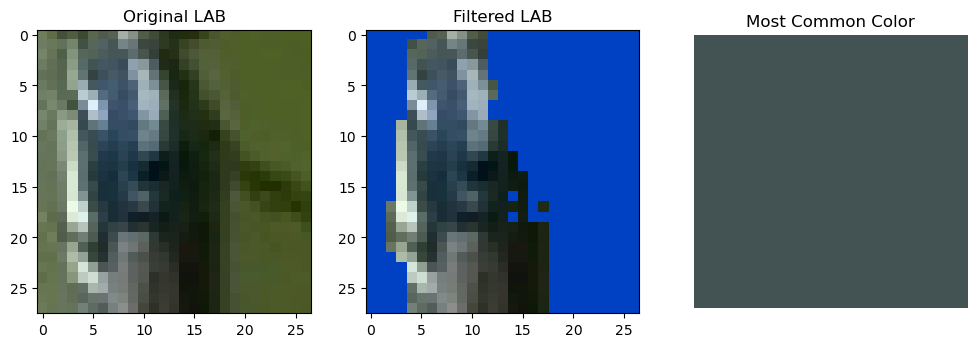

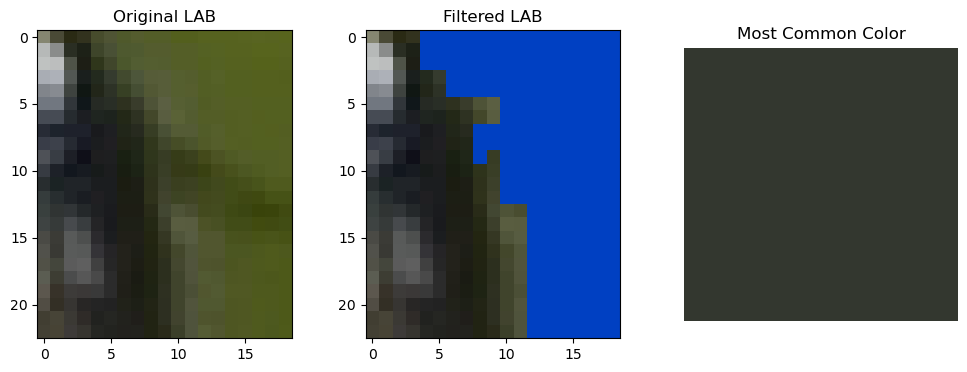

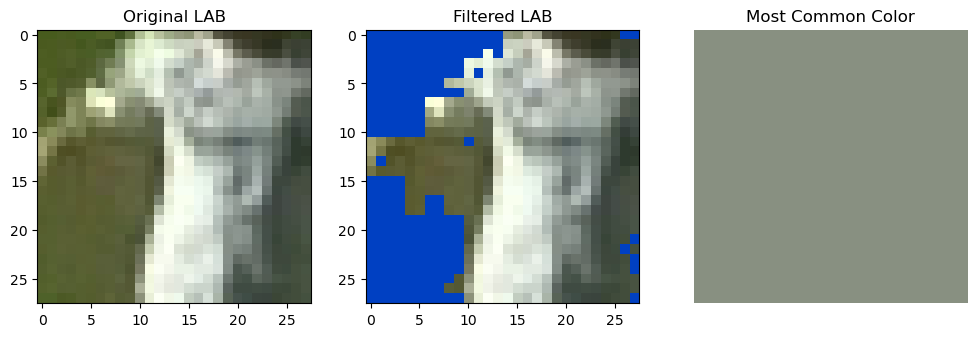

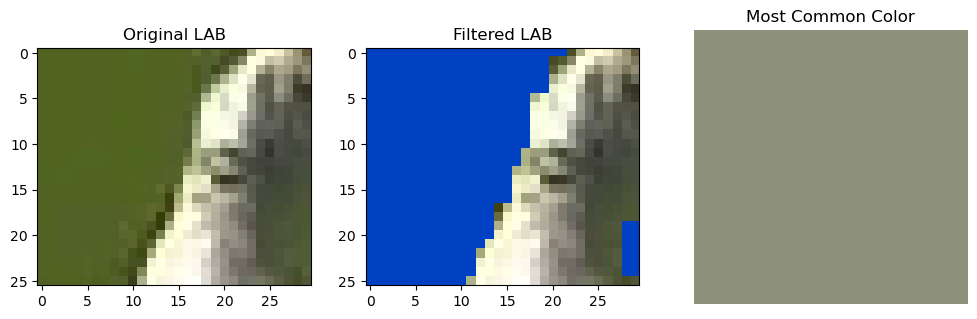

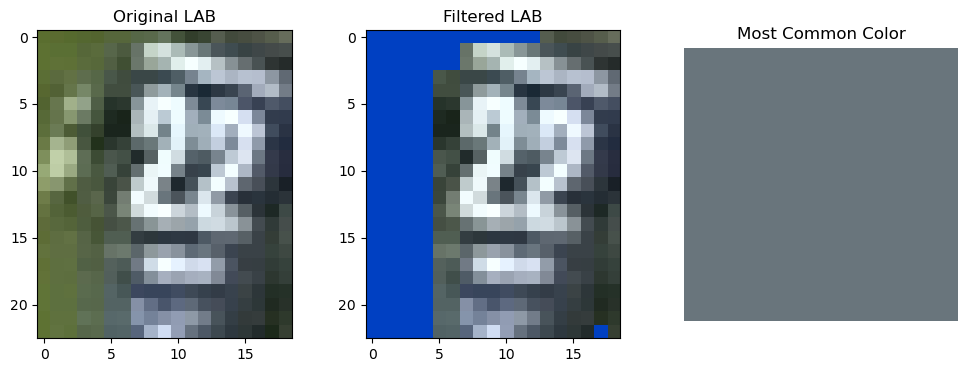

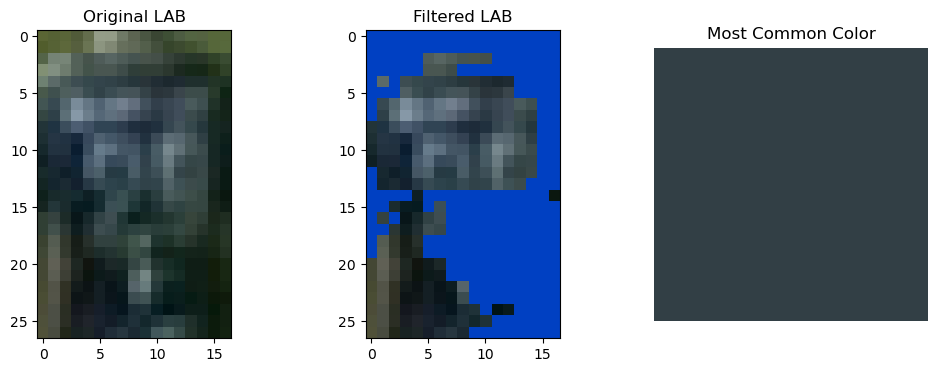

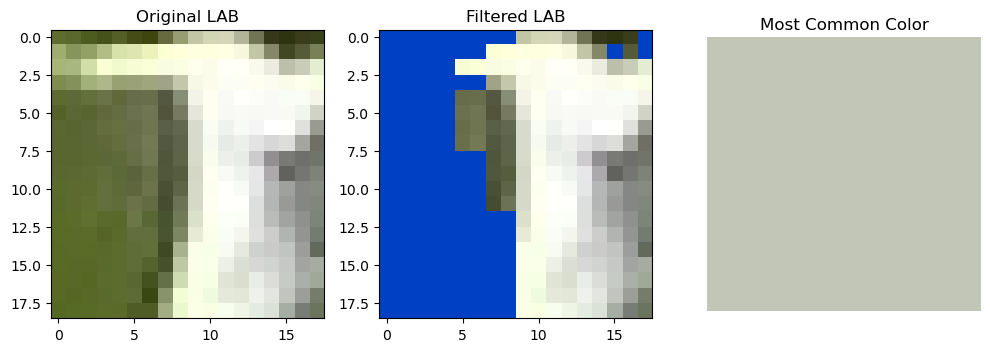

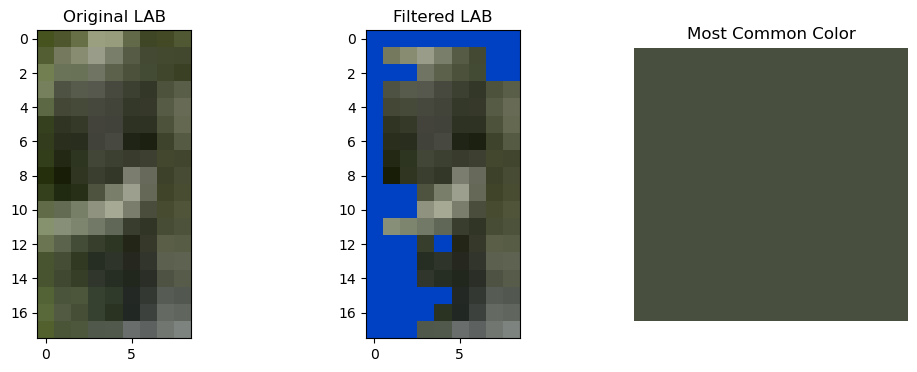

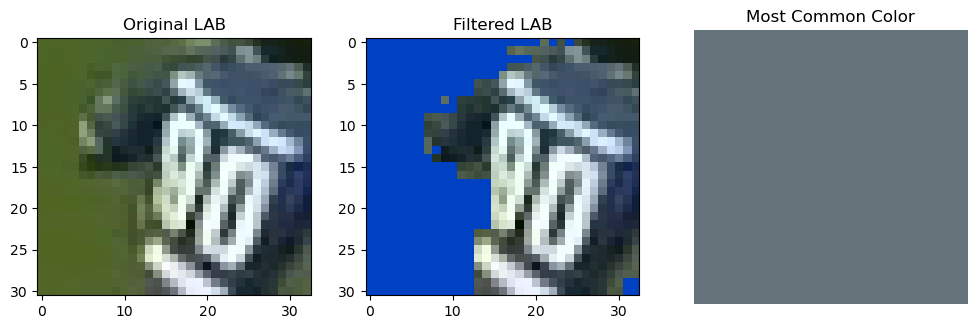

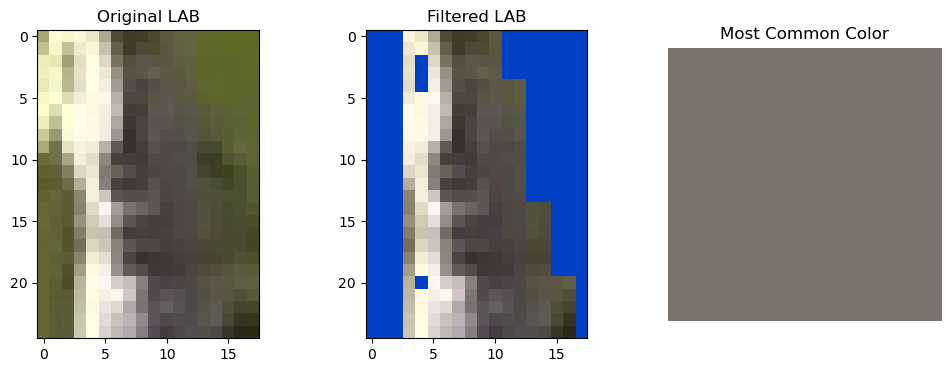

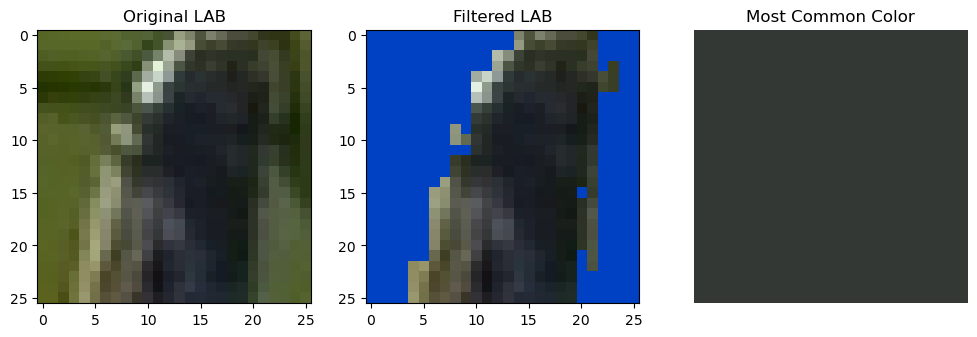

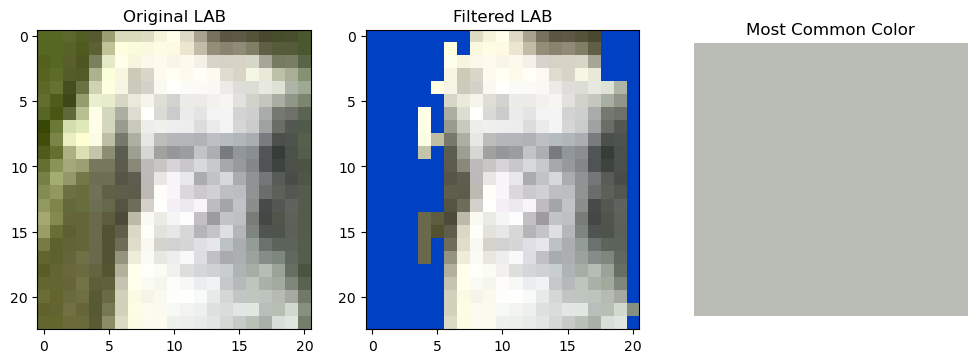

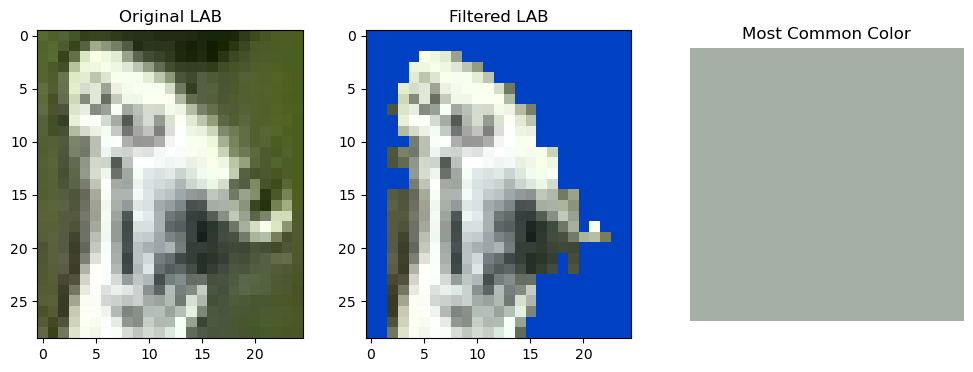

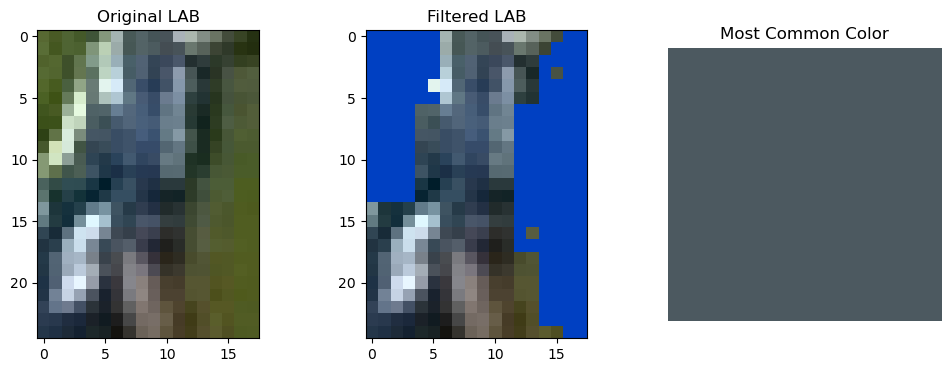

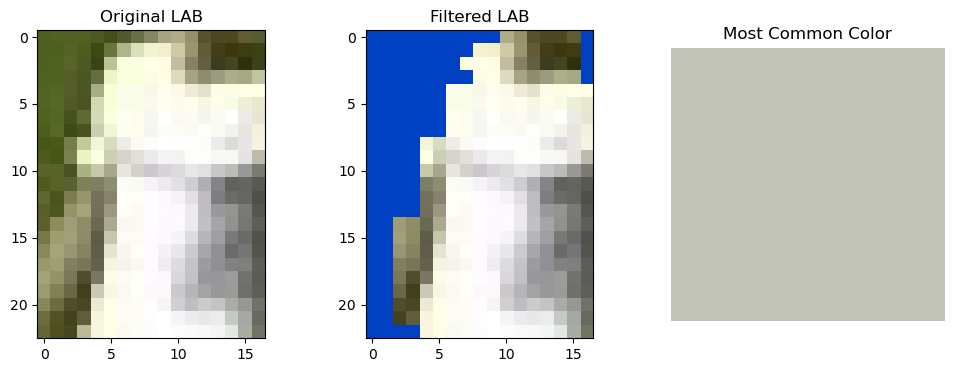

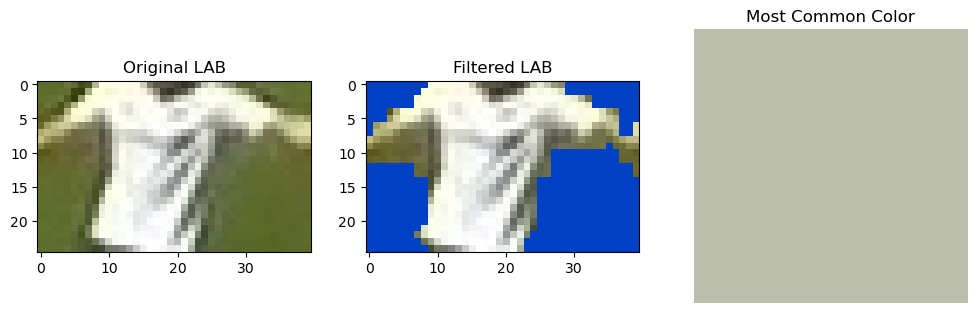

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f8baad30>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.5ms
Spe

12


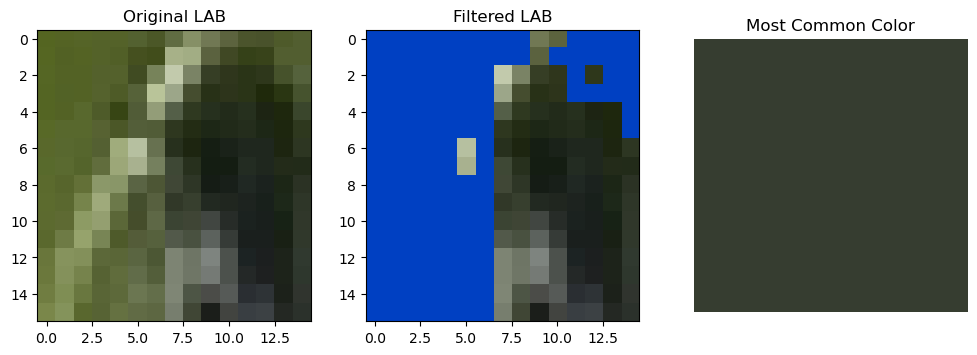

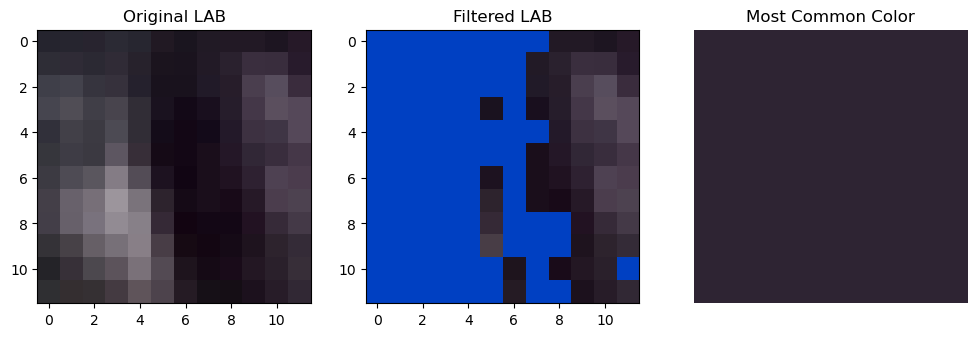

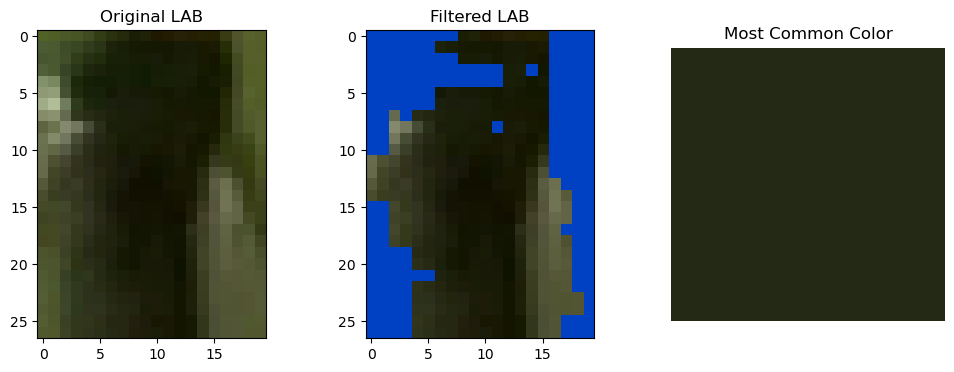

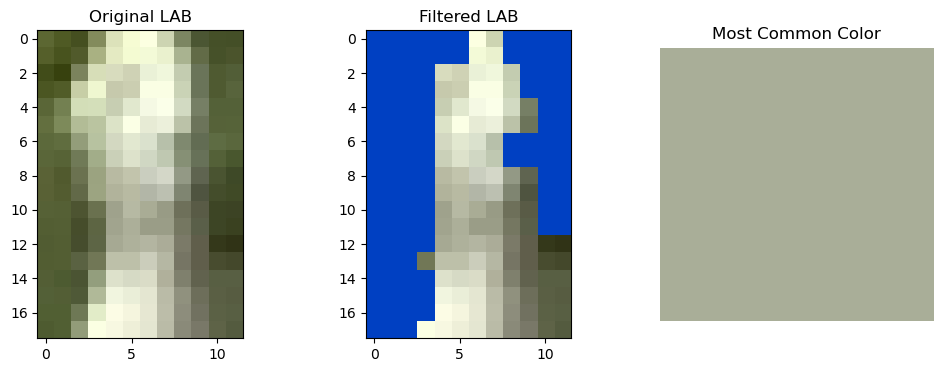

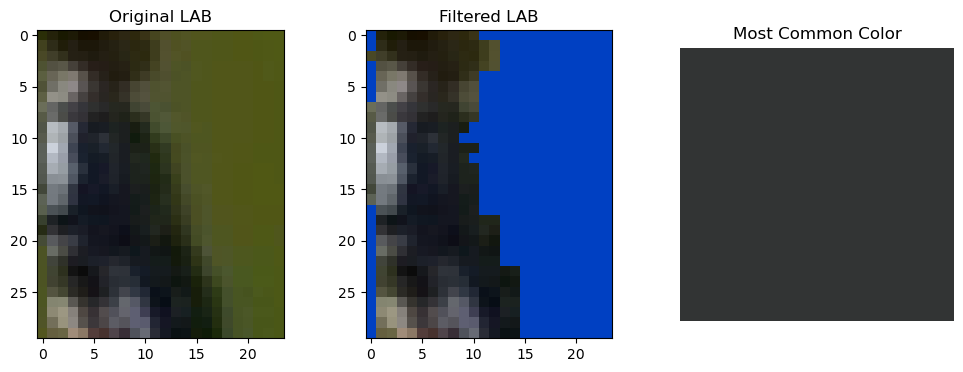

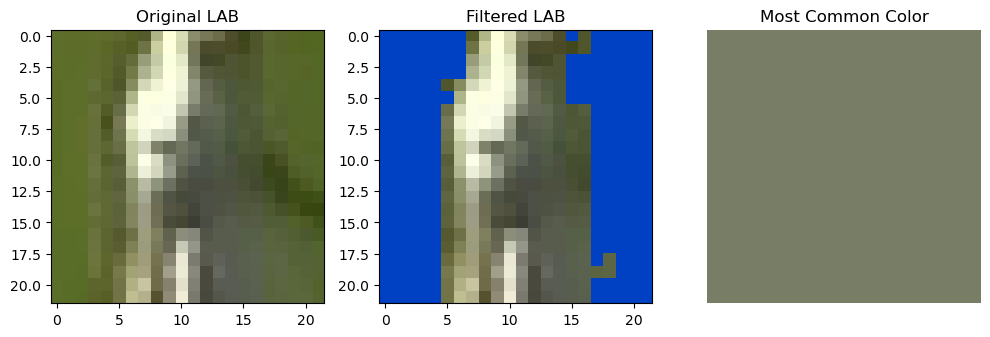

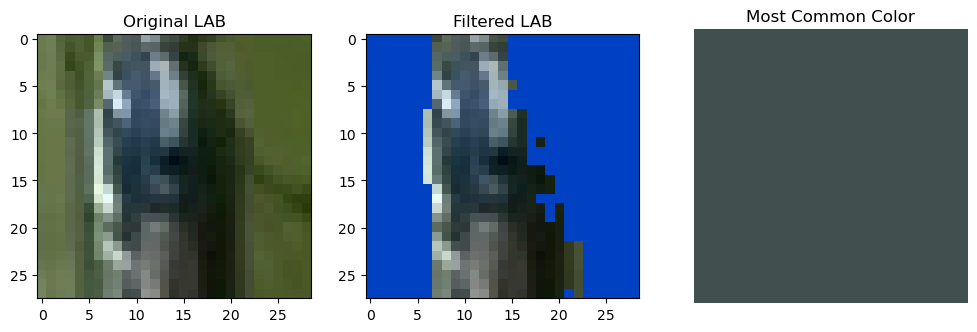

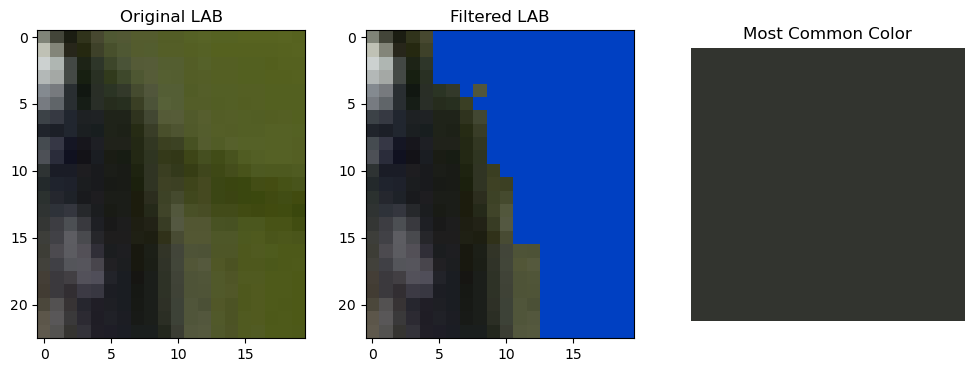

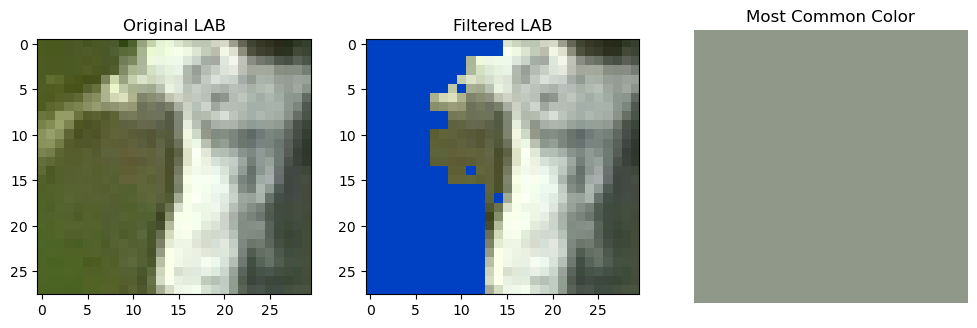

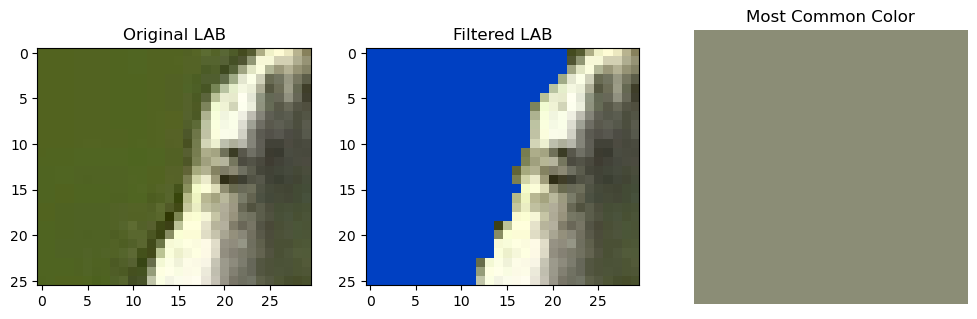

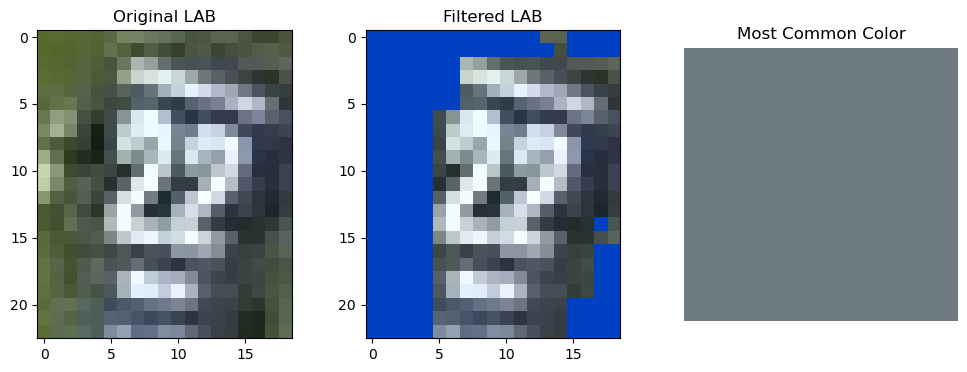

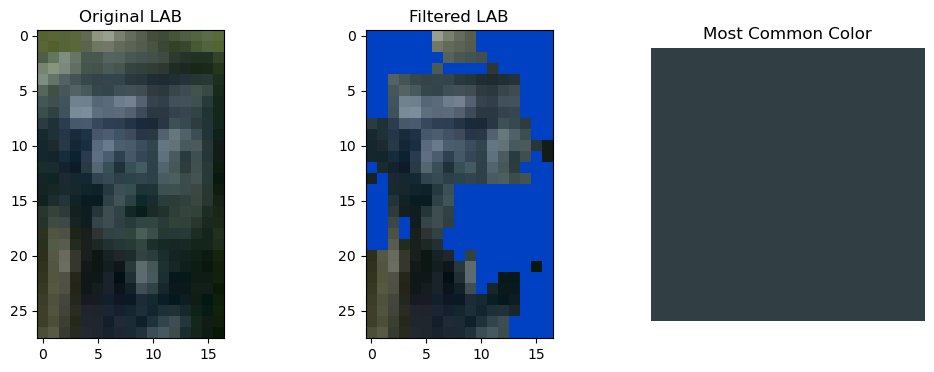

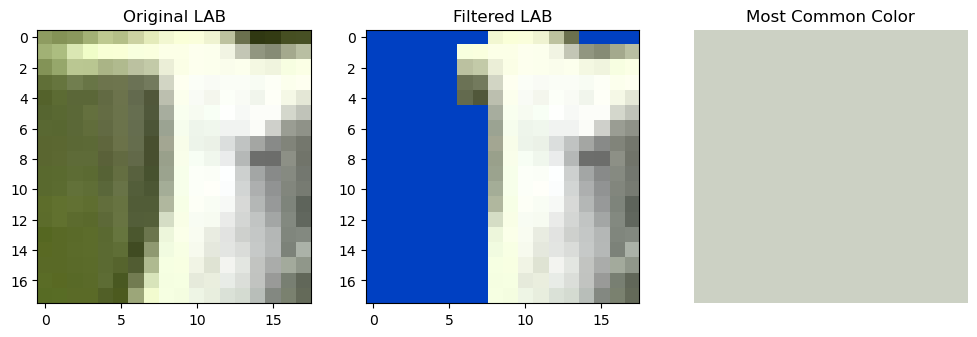

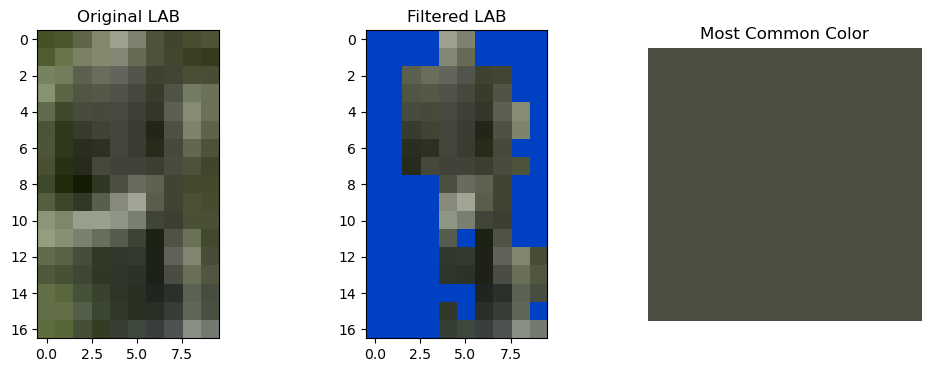

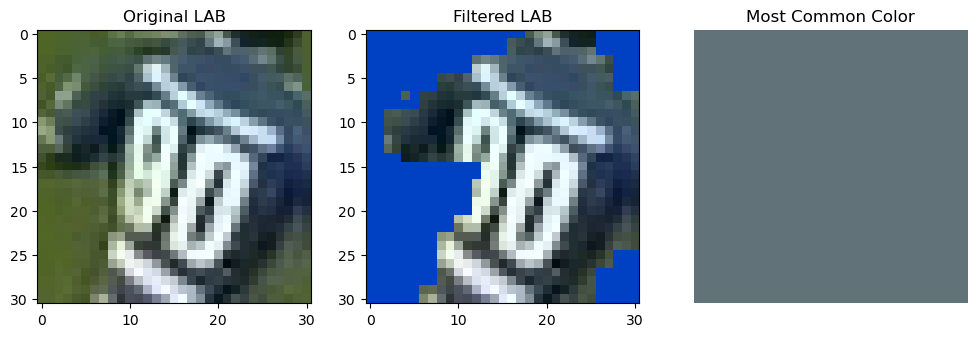

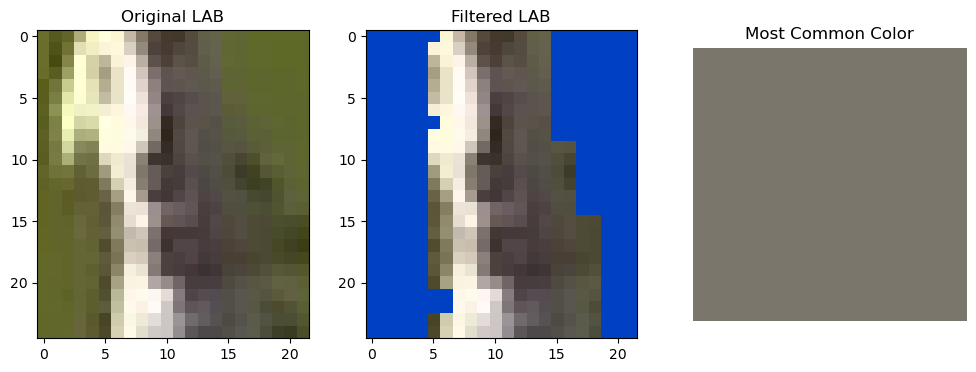

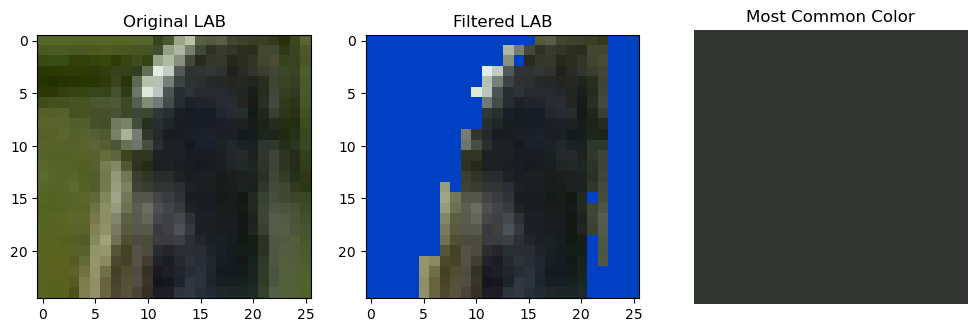

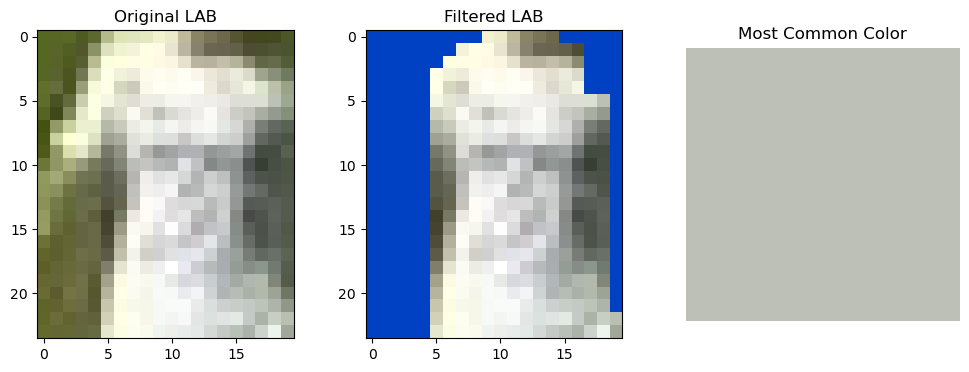

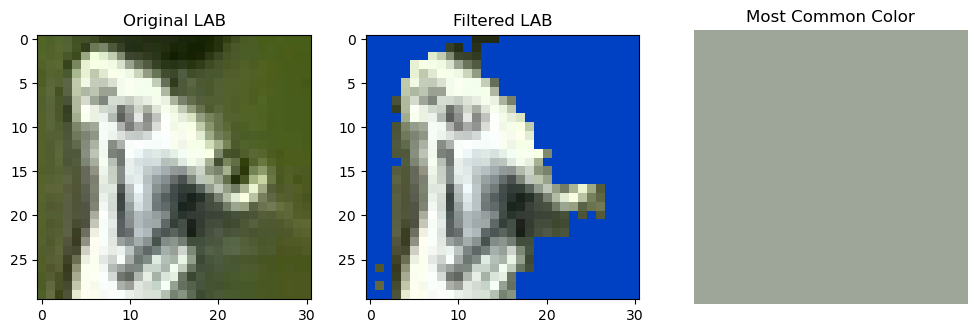

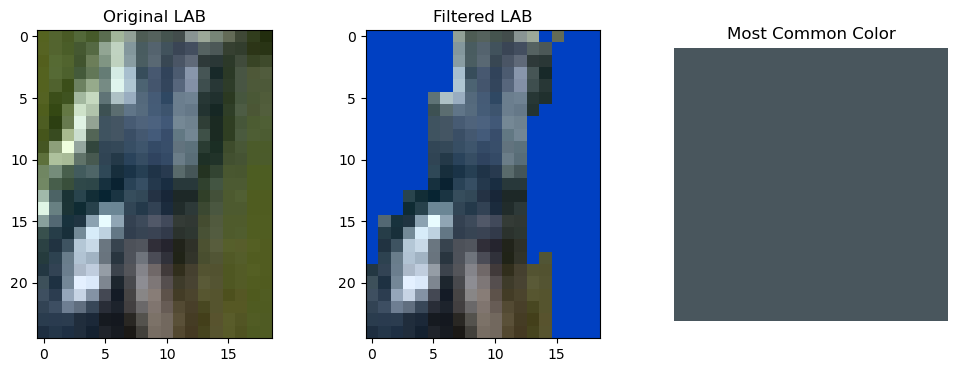

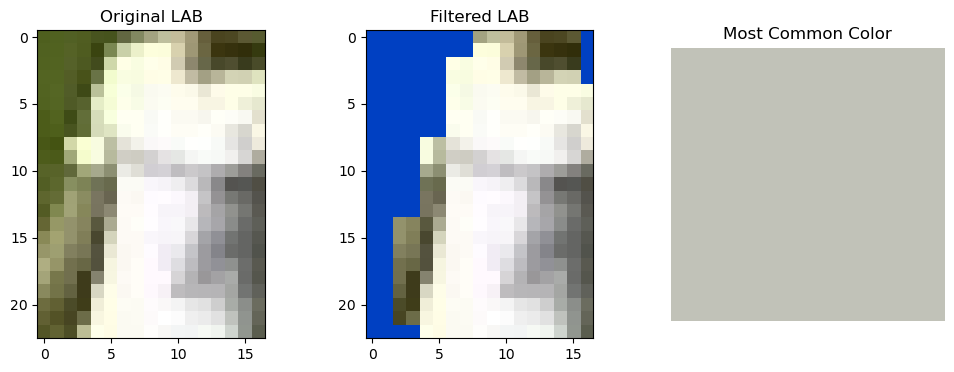

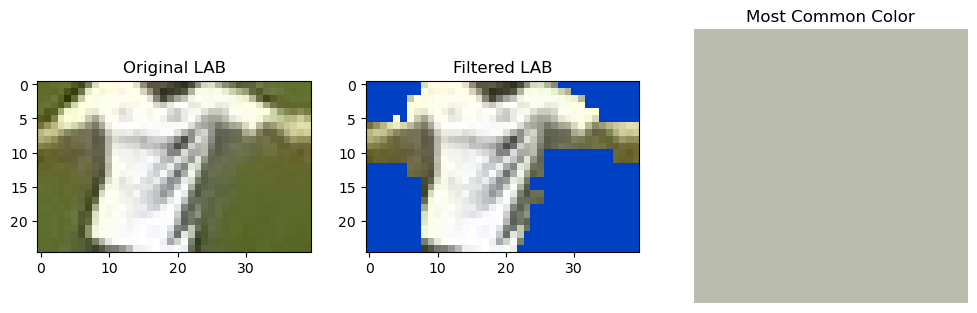

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1501f8baad30>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.4ms
Spe

13


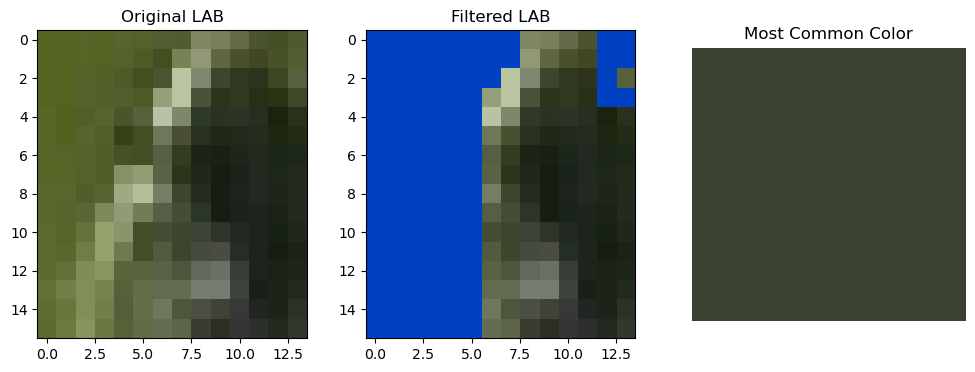

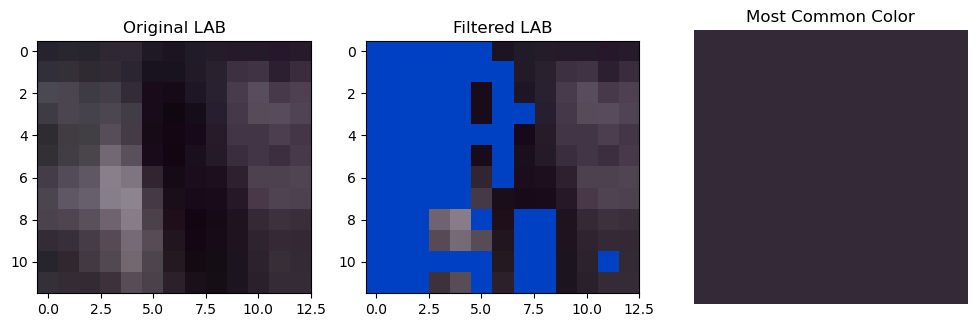

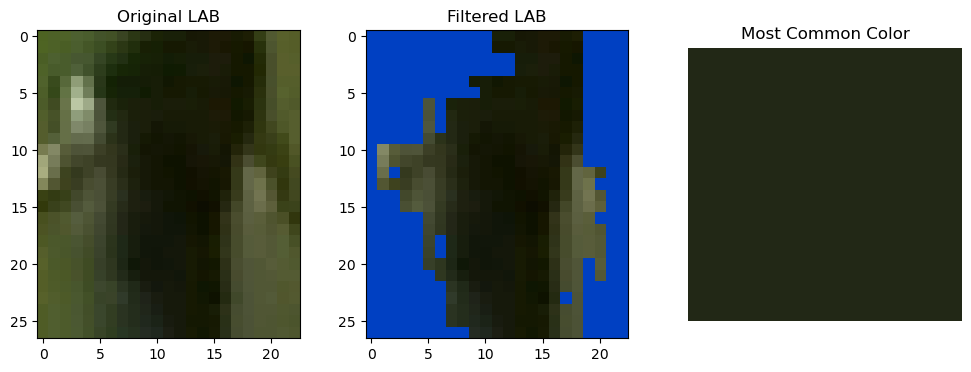

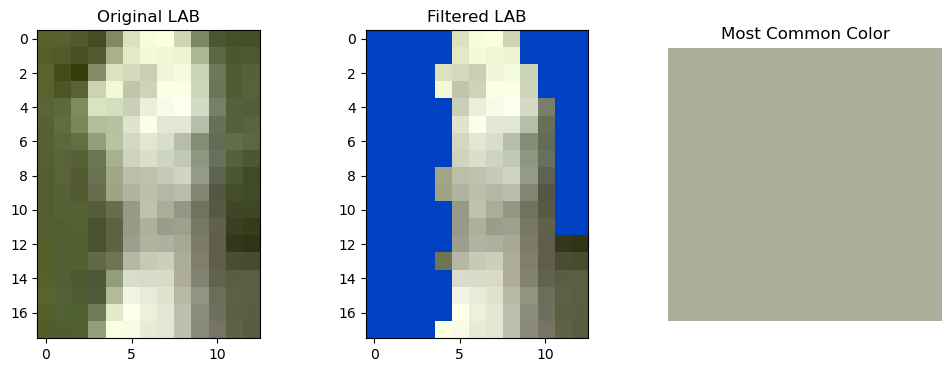

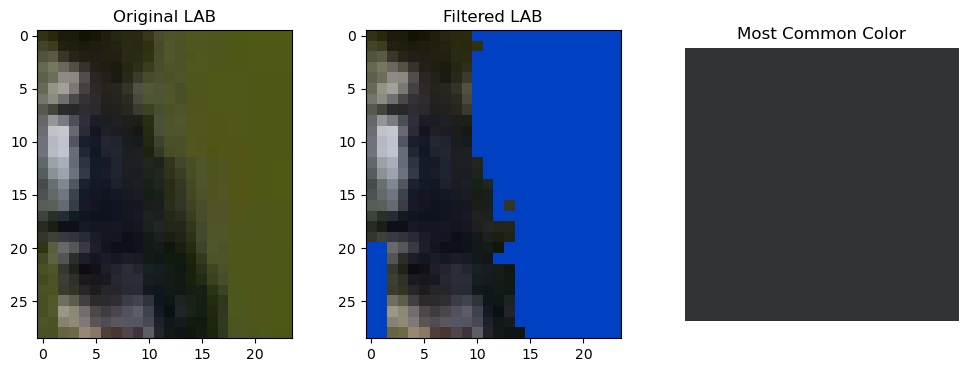

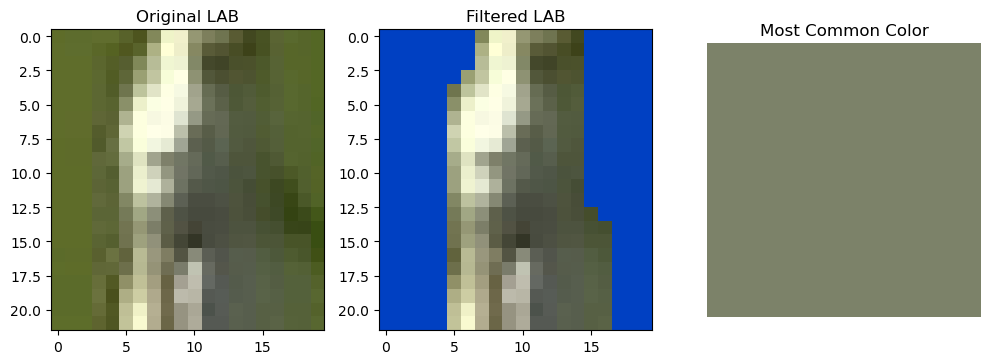

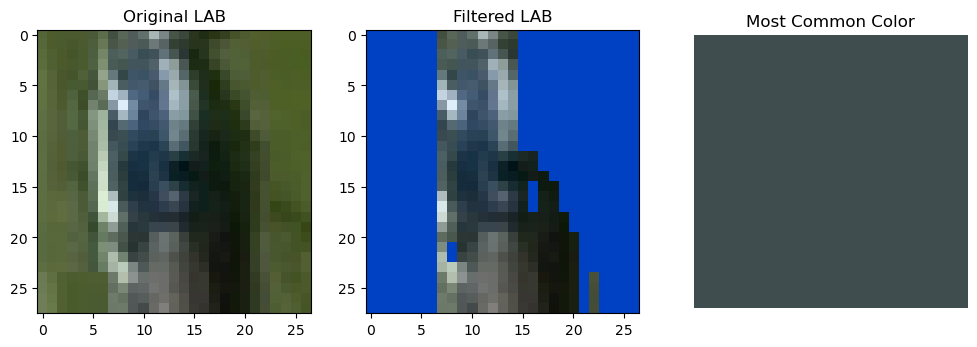

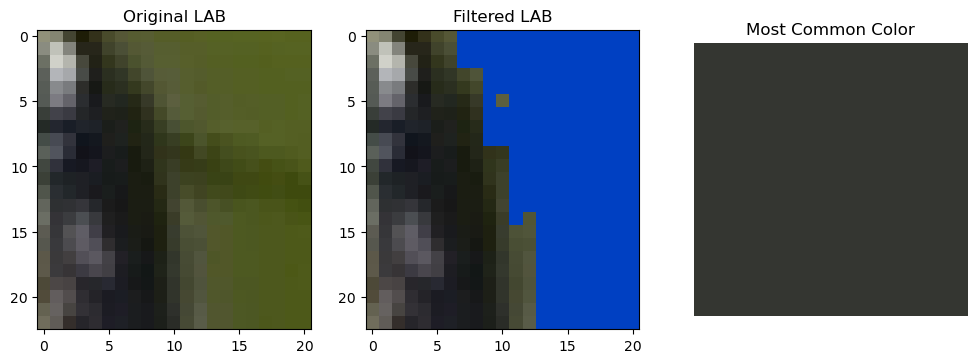

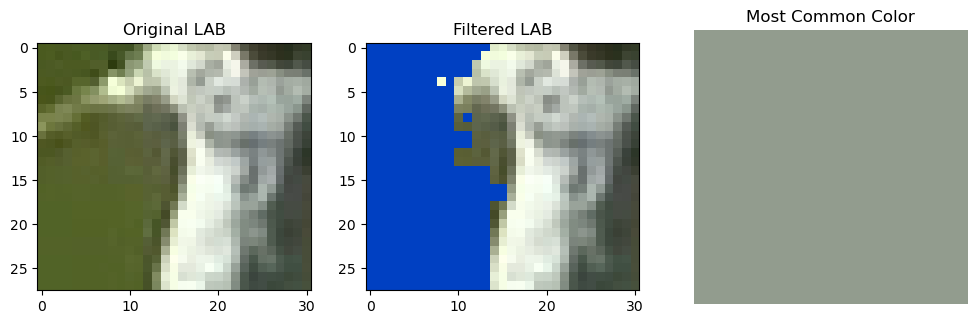

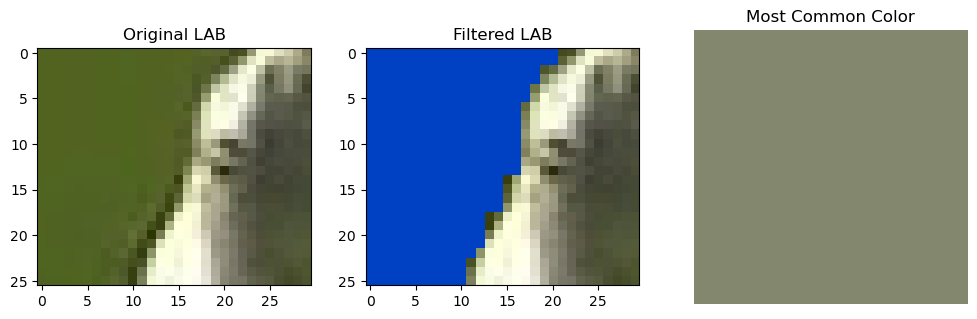

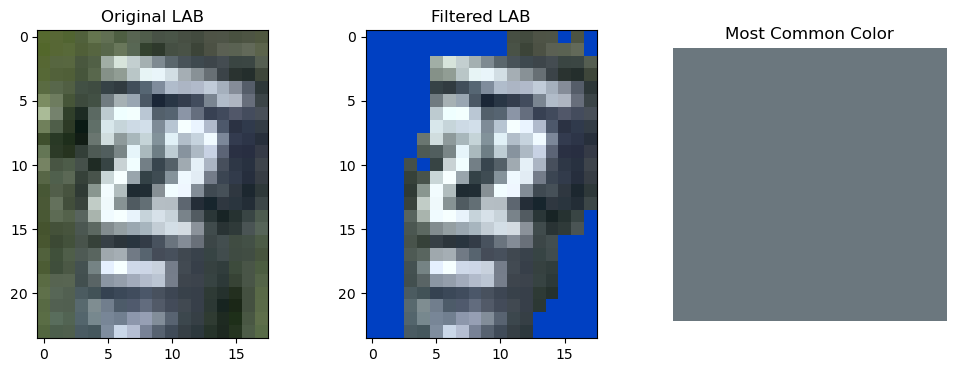

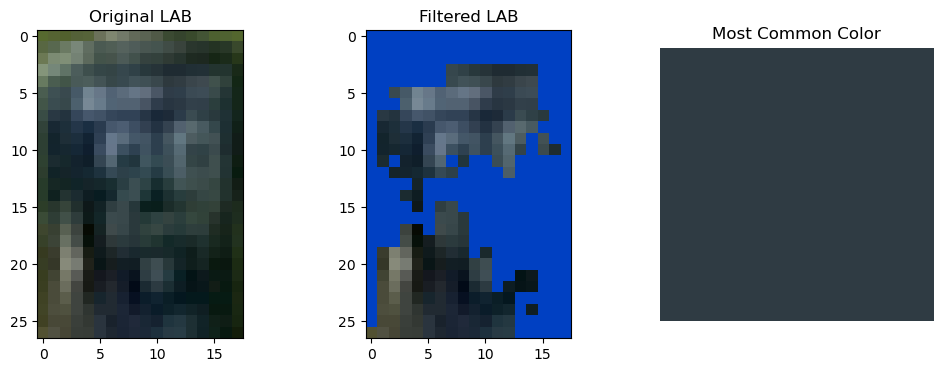

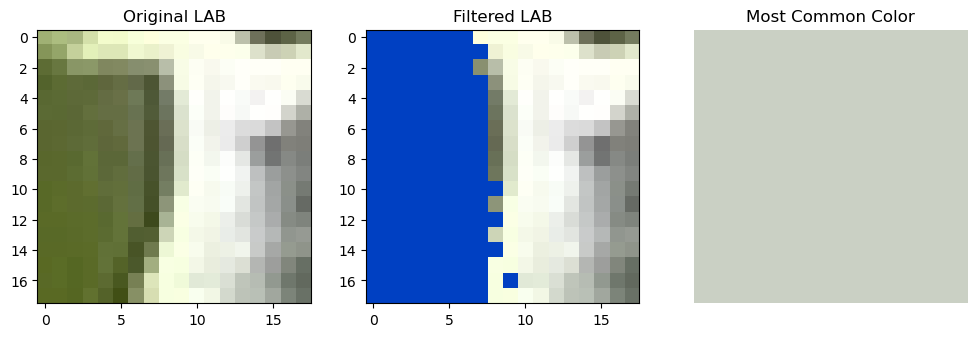

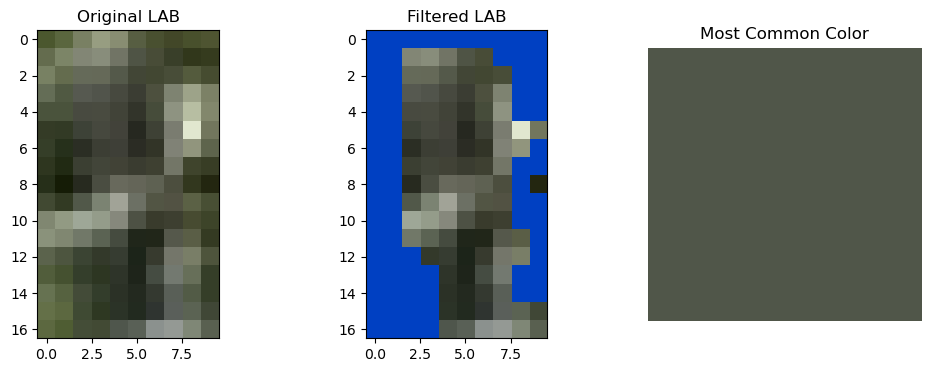

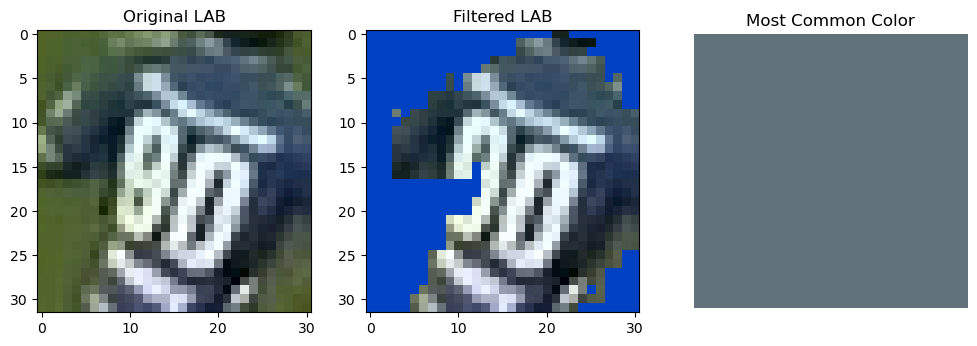

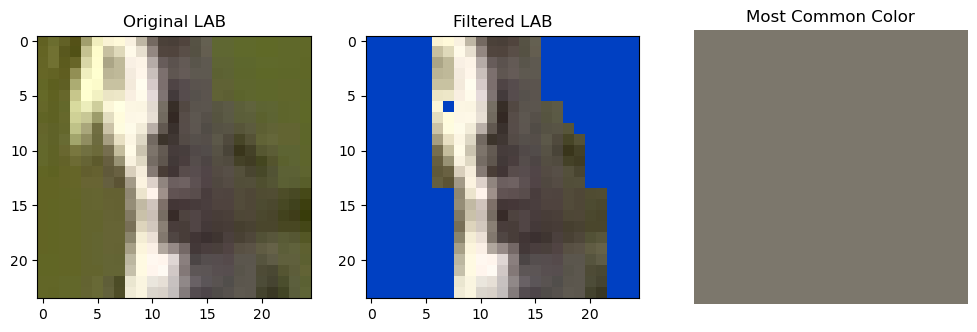

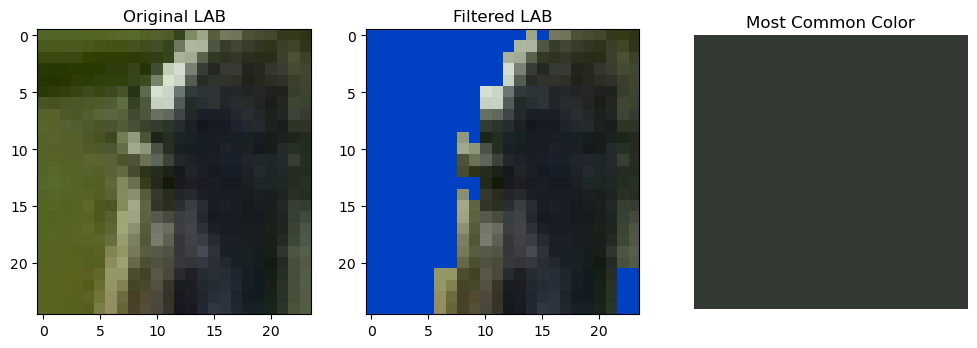

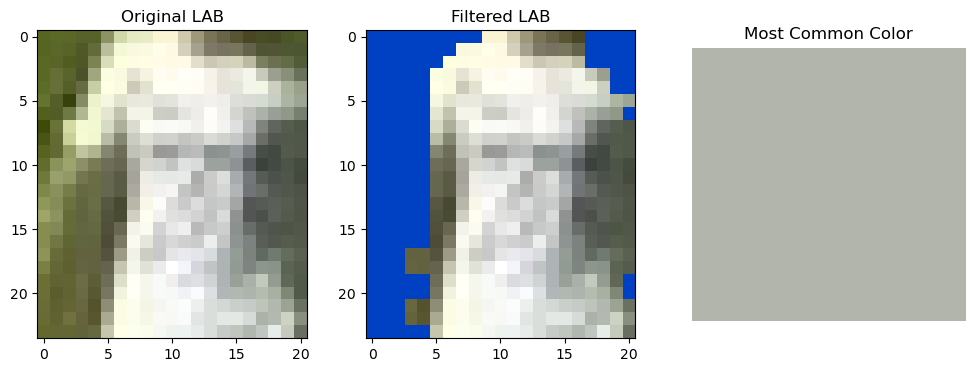

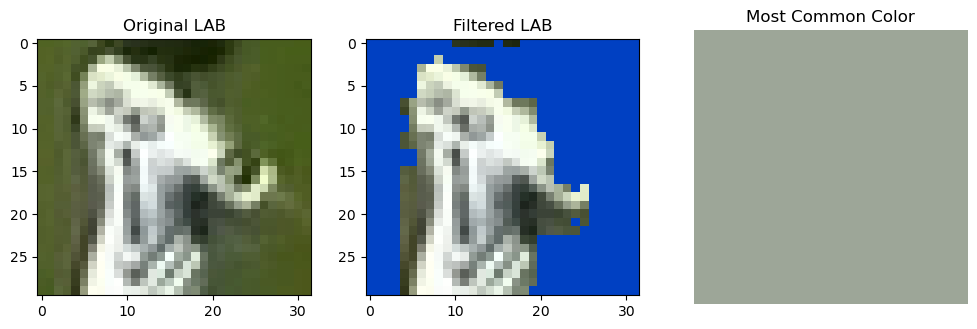

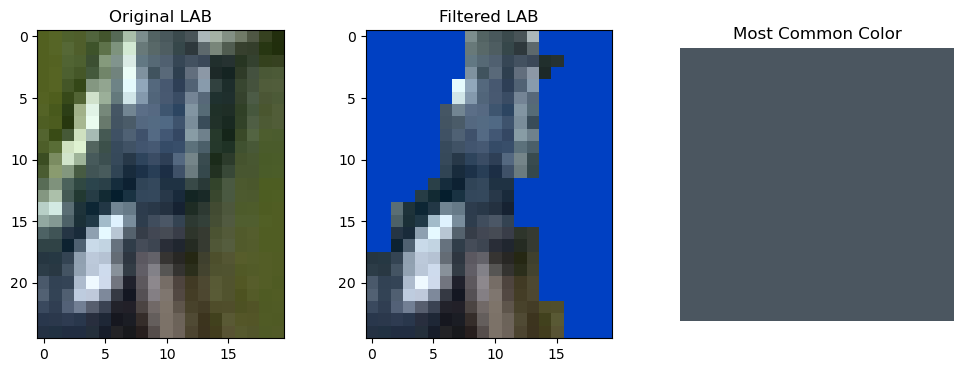

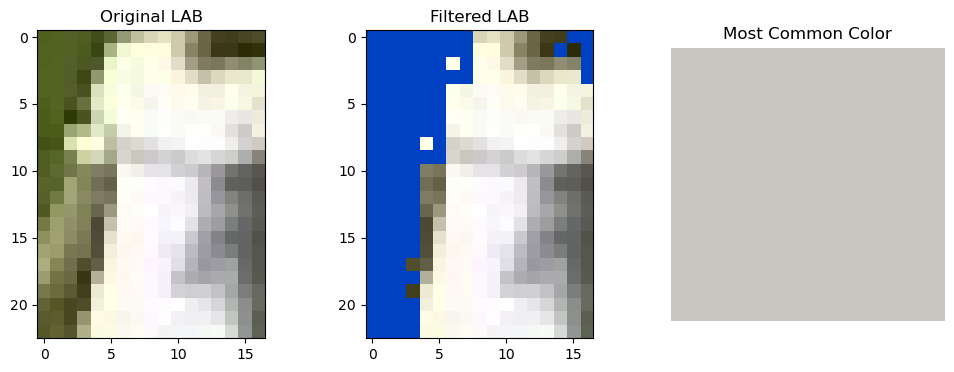

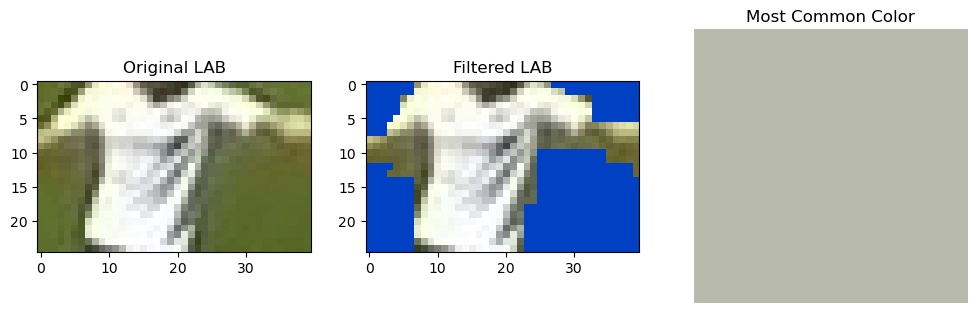

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x150269525820>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.4ms
Spe

14


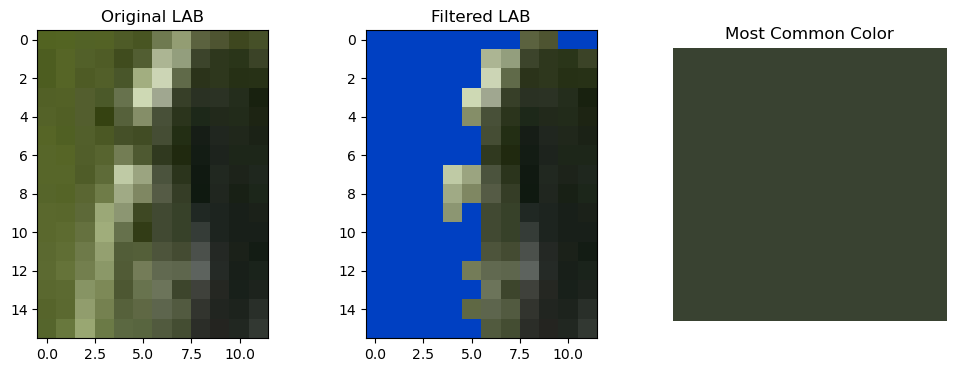

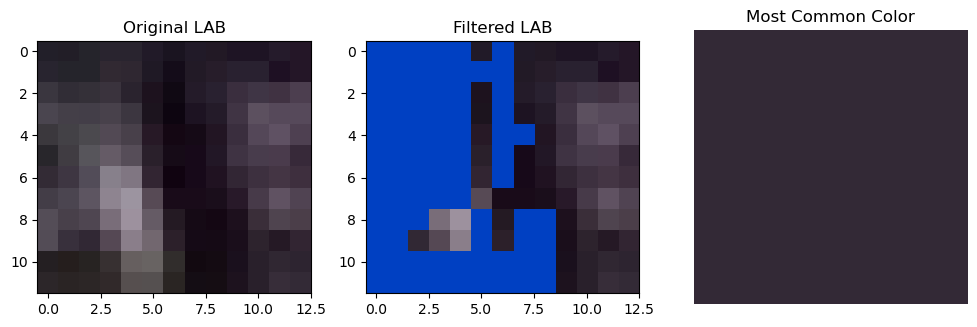

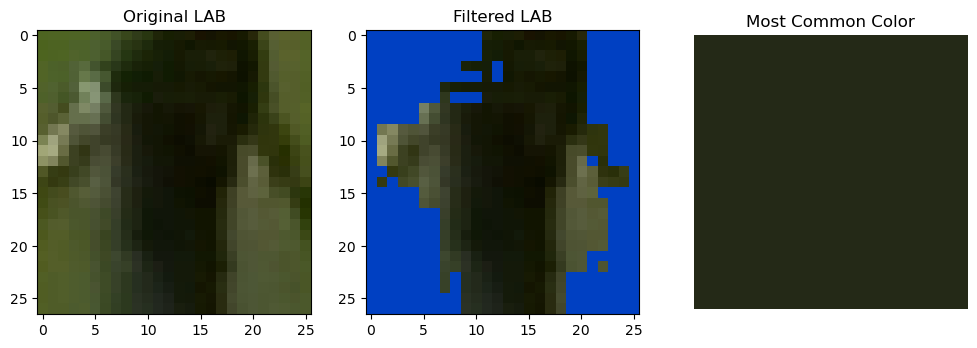

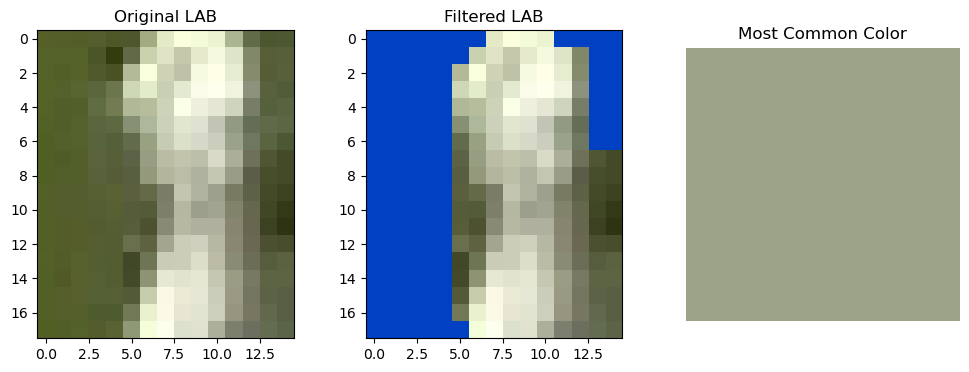

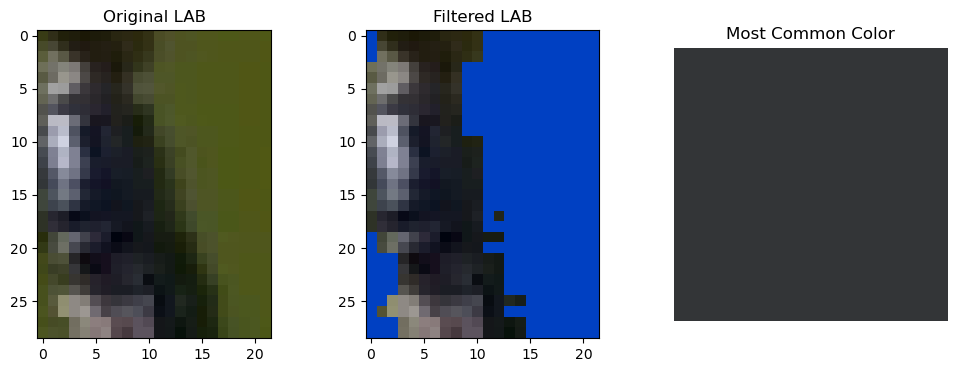

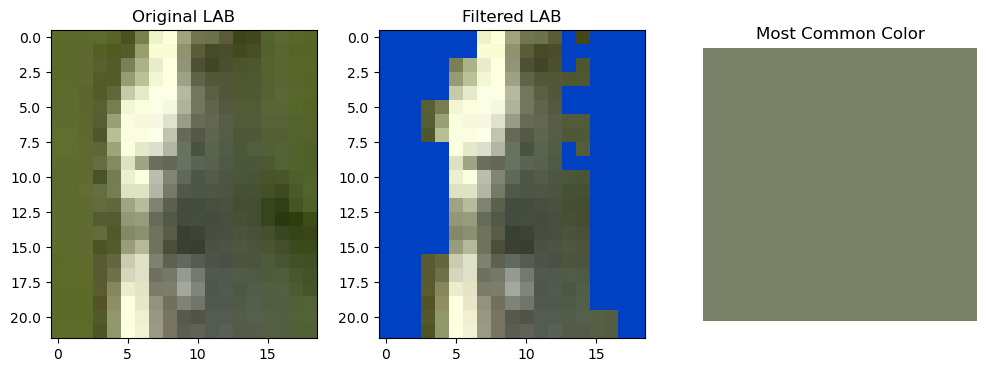

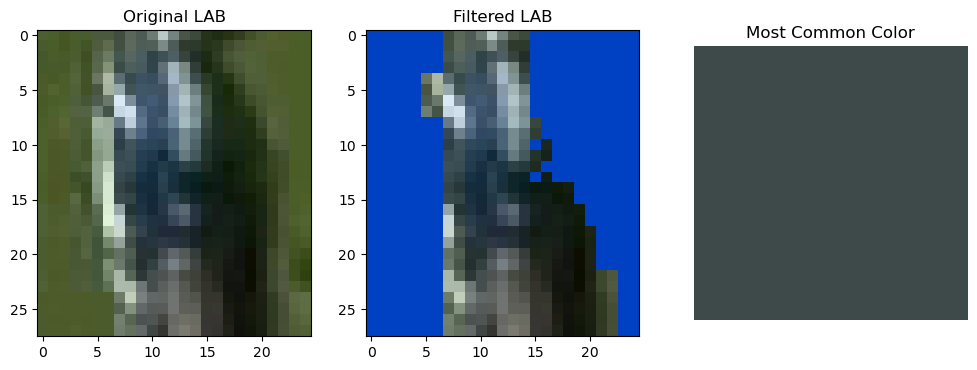

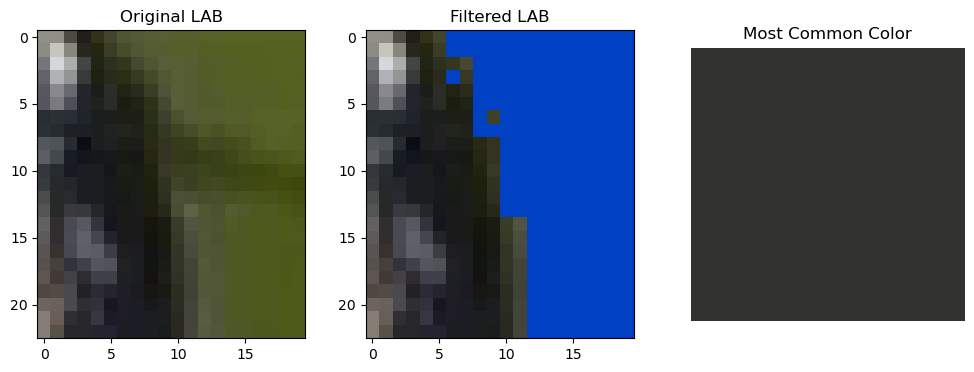

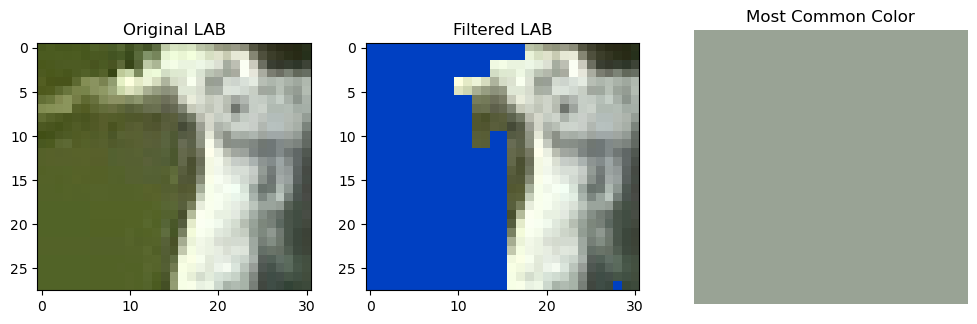

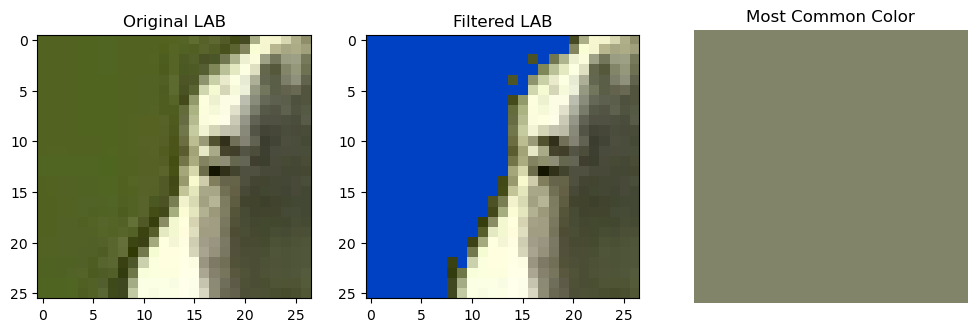

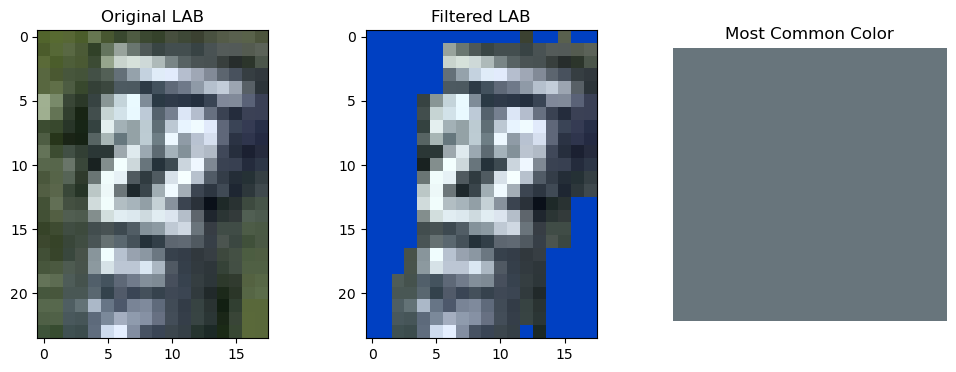

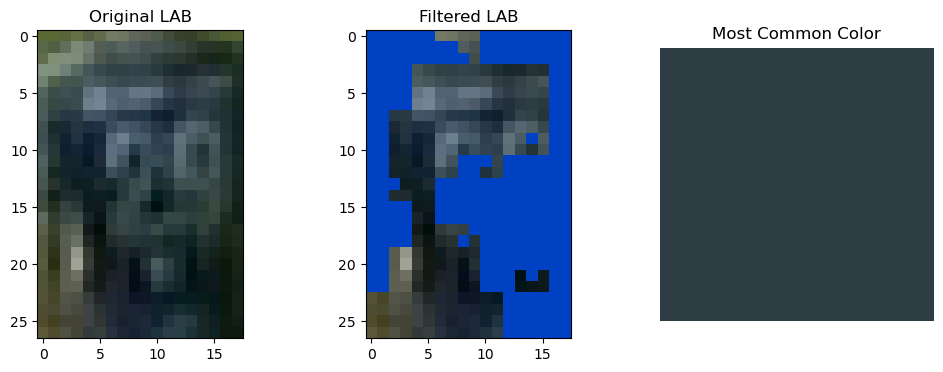

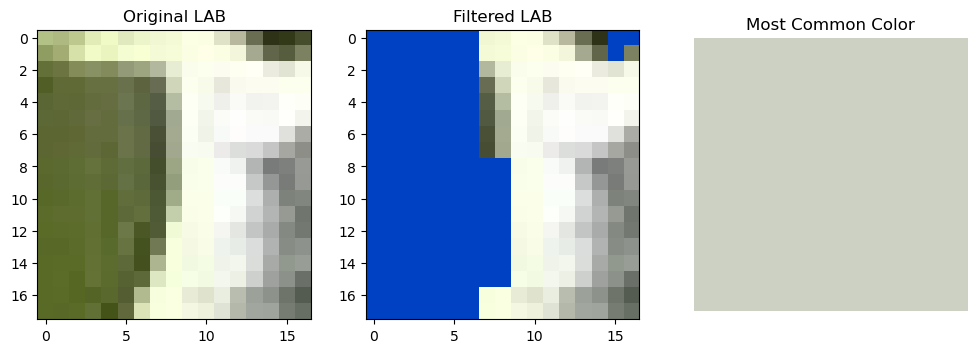

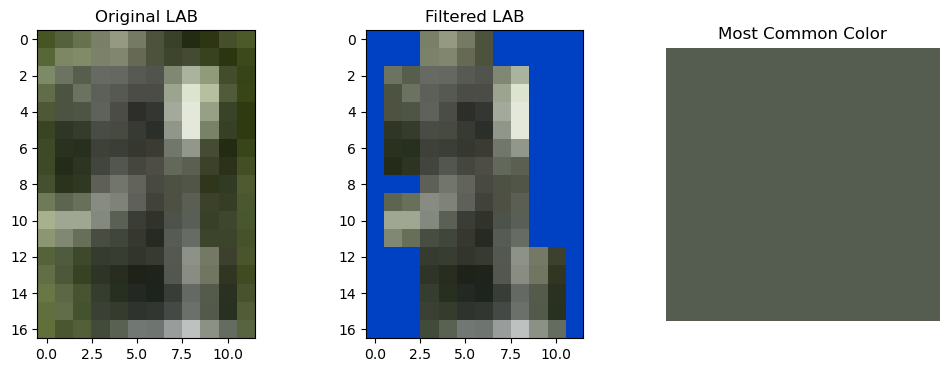

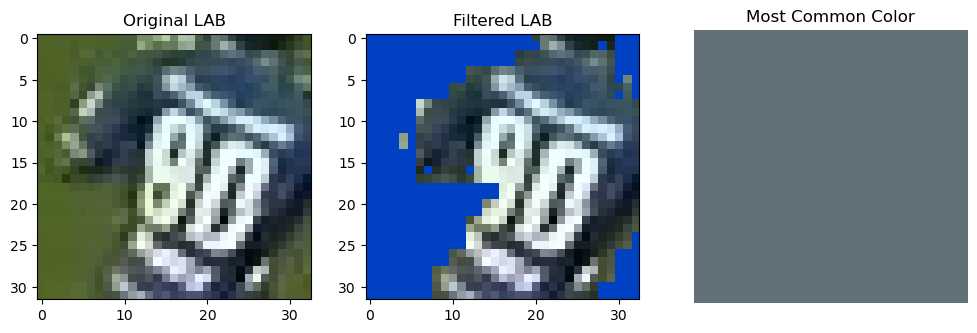

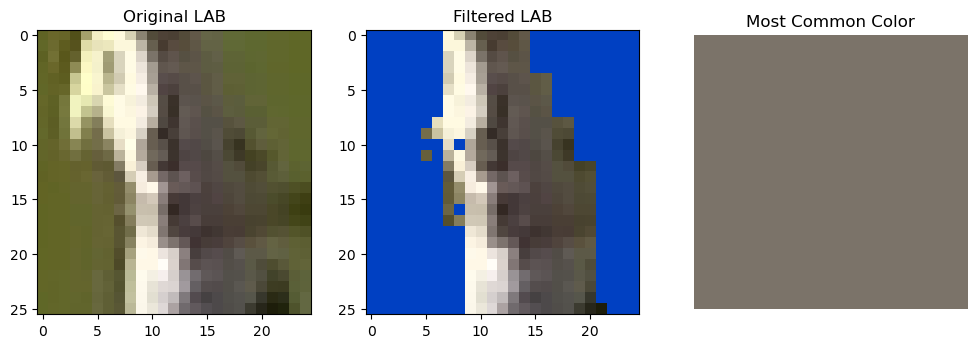

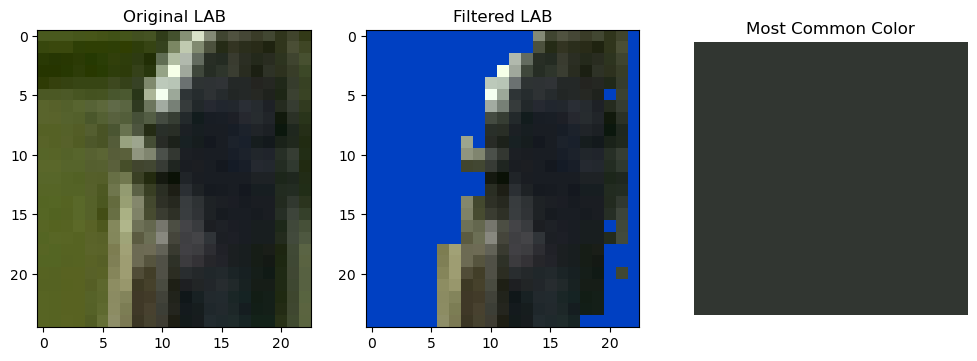

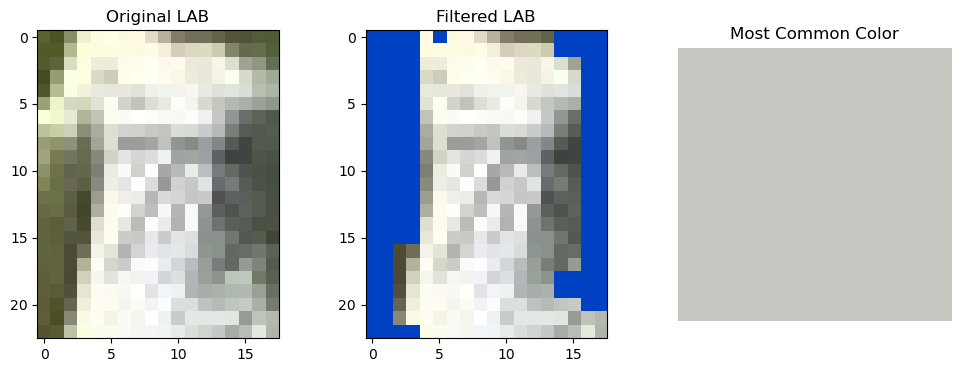

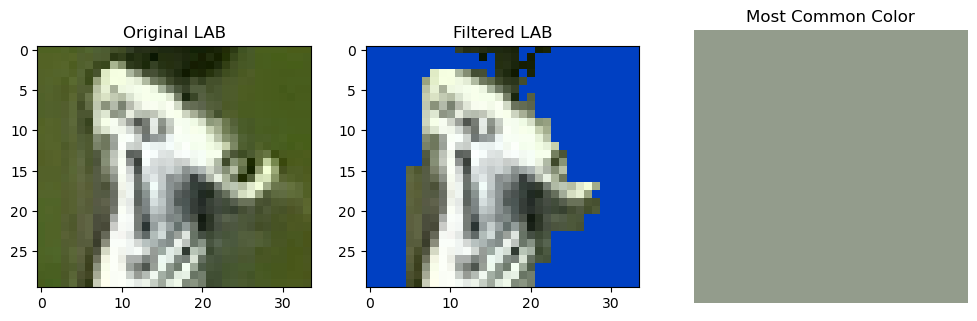

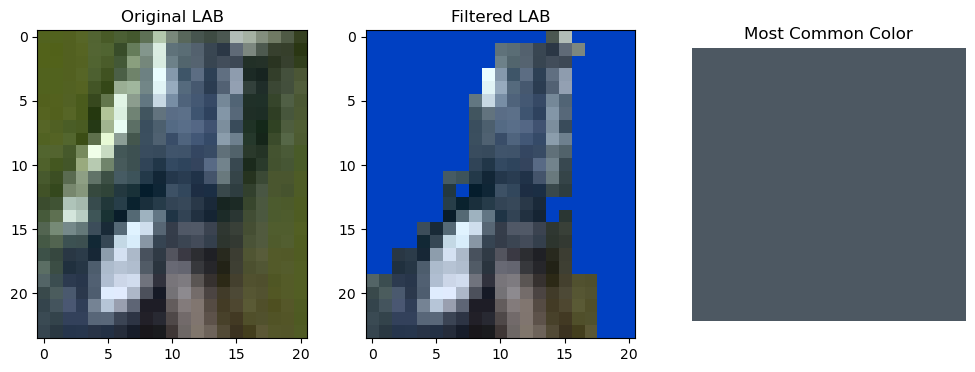

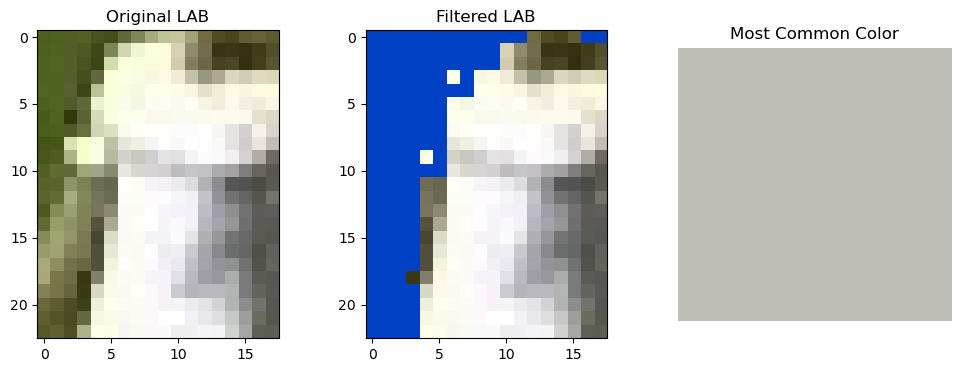

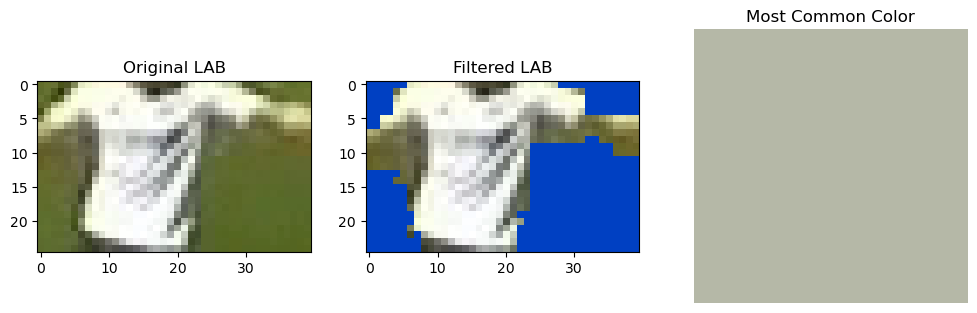

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1502696c0f70>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.4ms
Spe

15


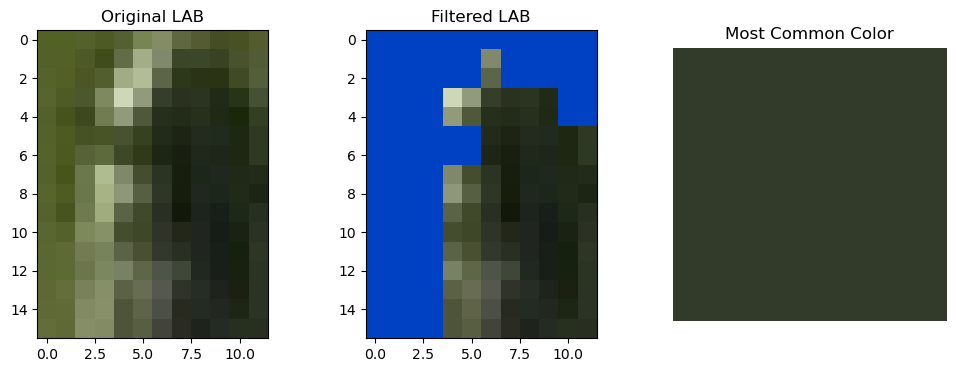

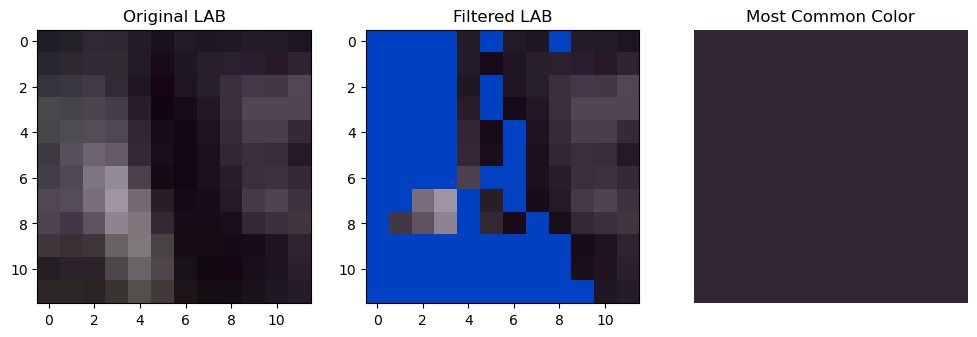

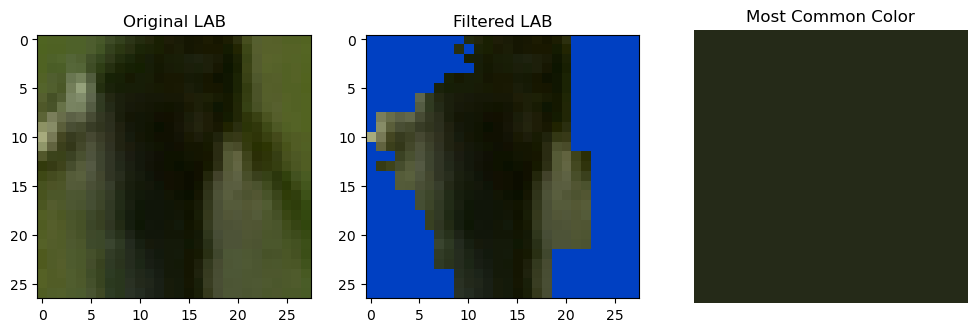

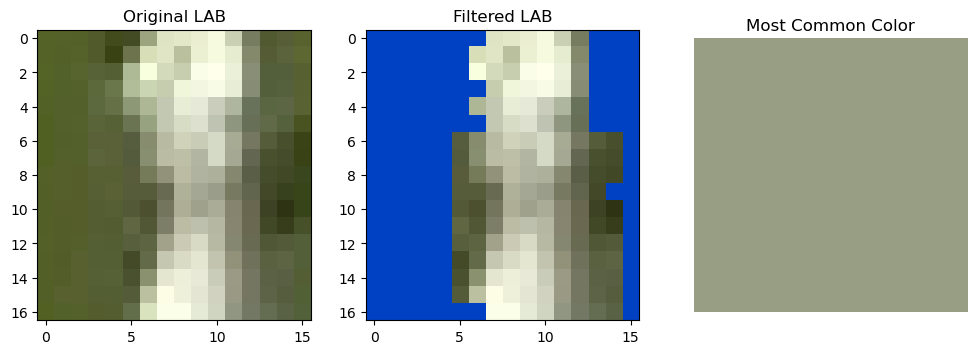

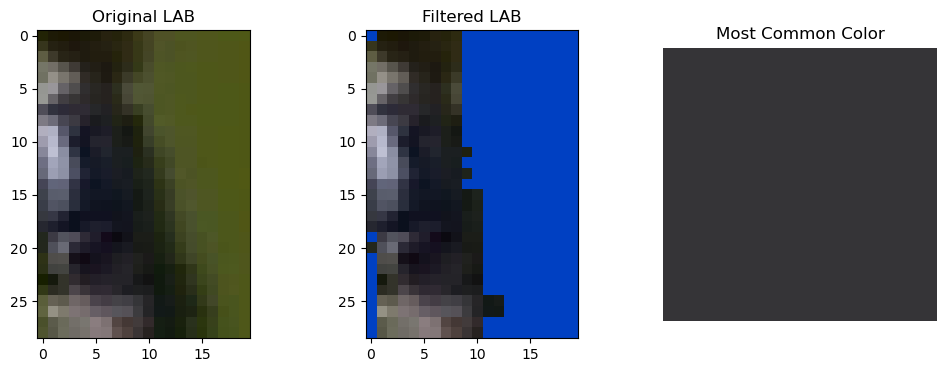

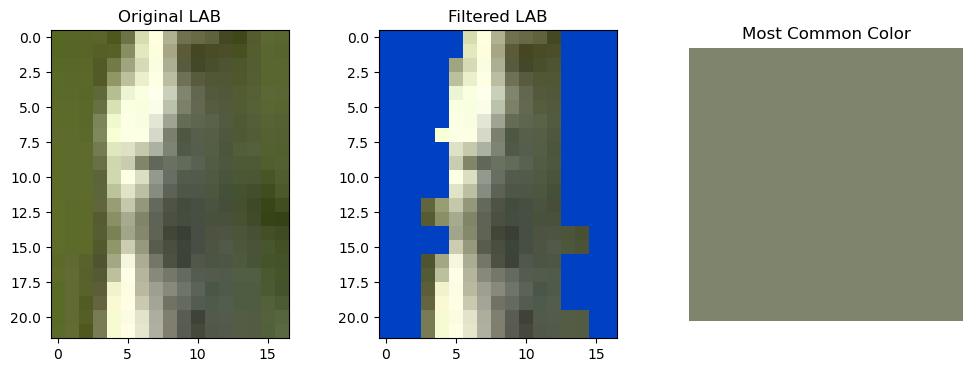

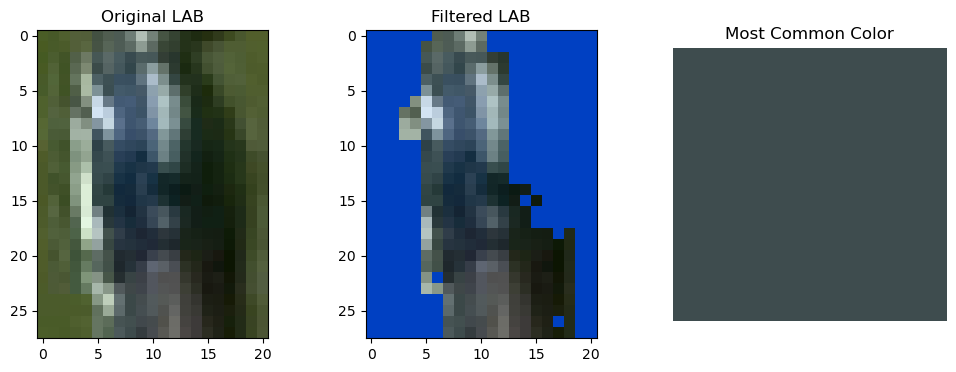

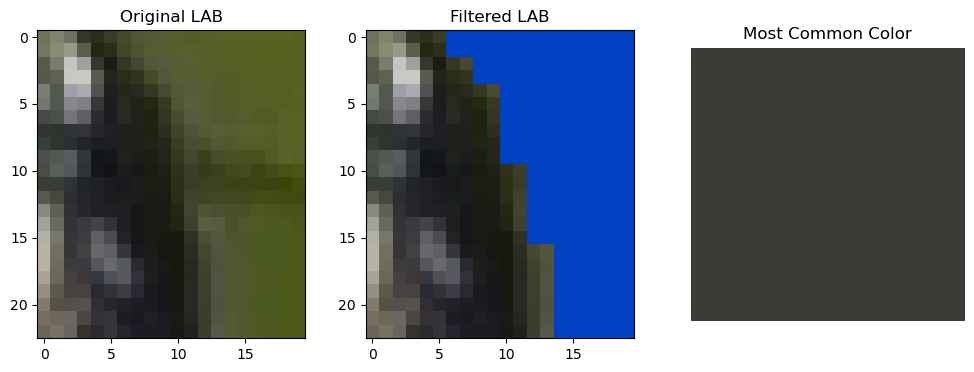

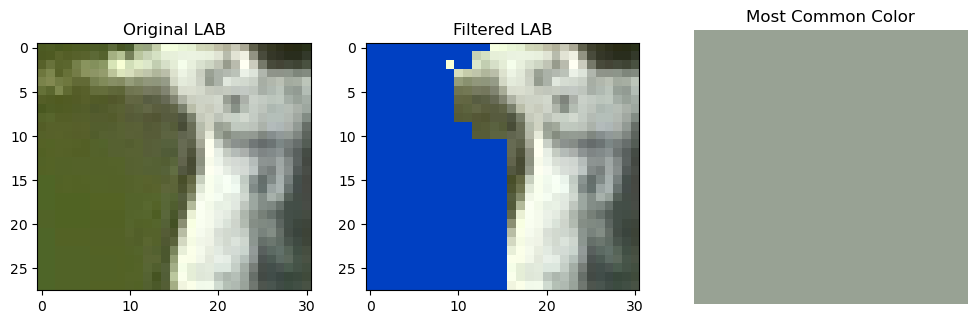

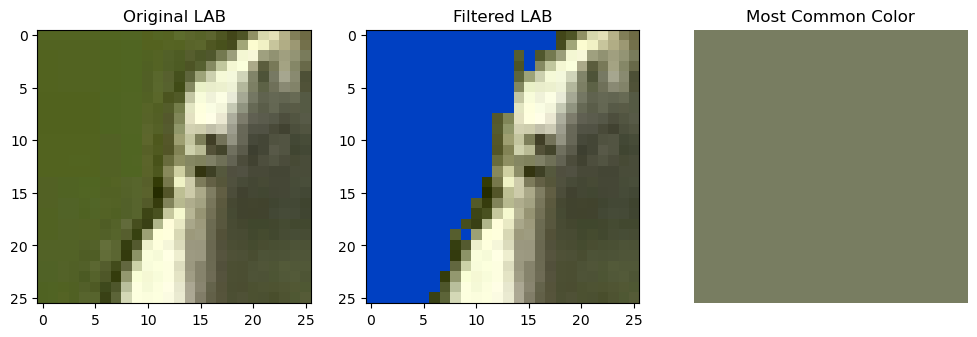

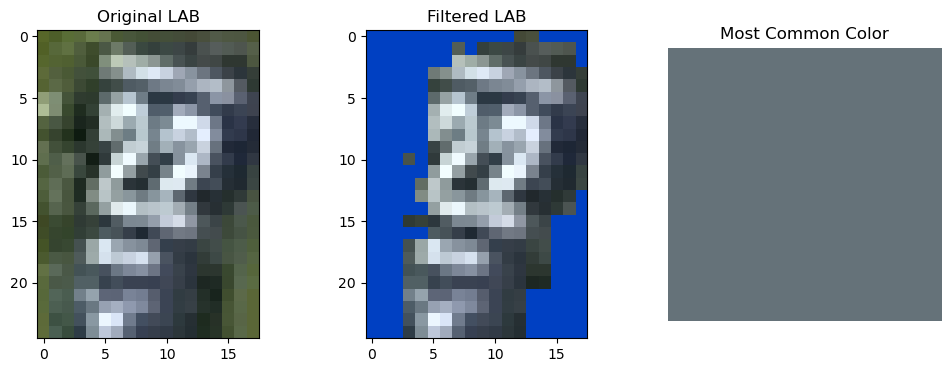

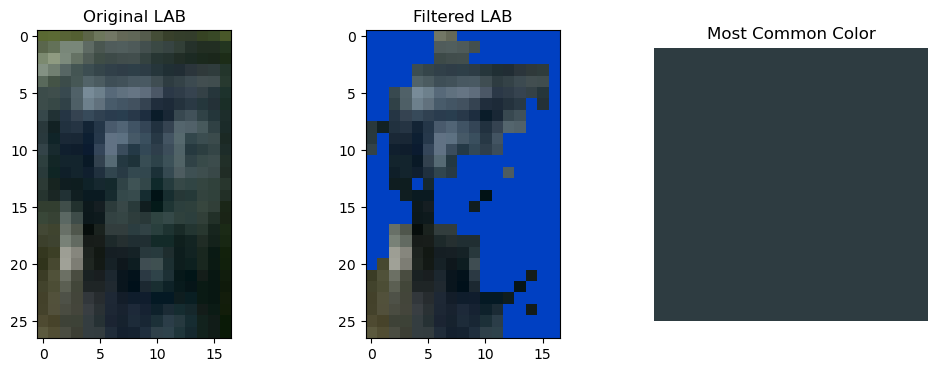

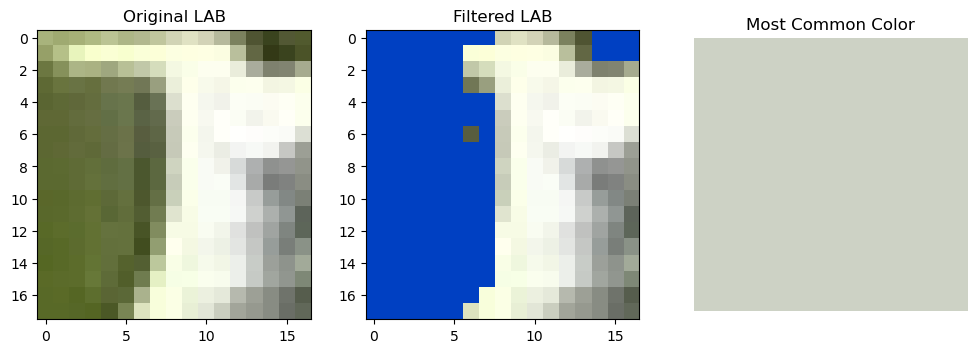

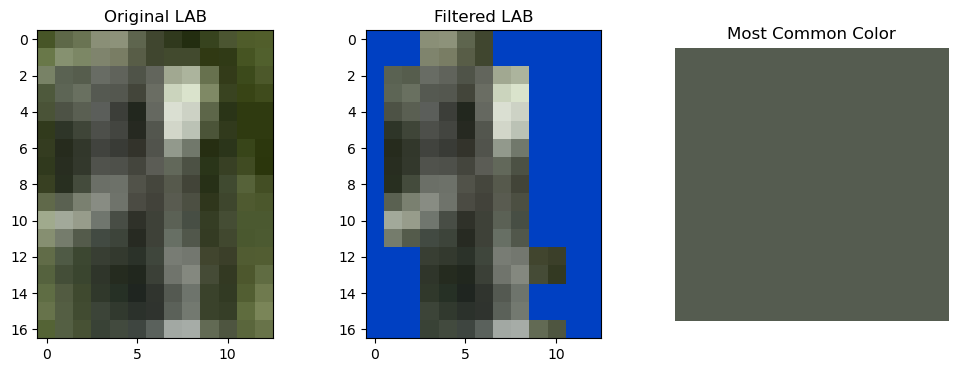

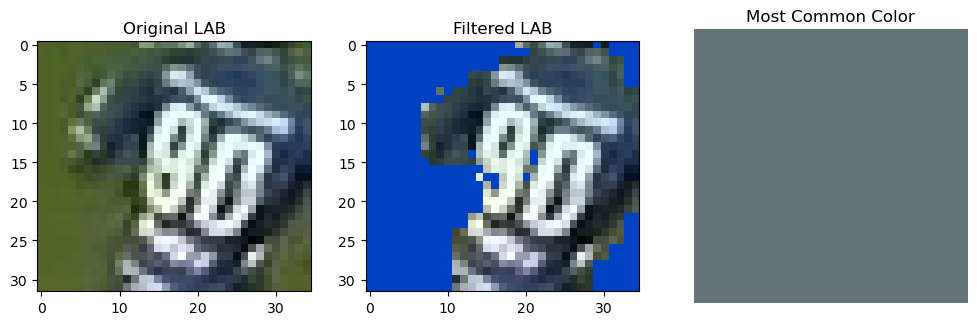

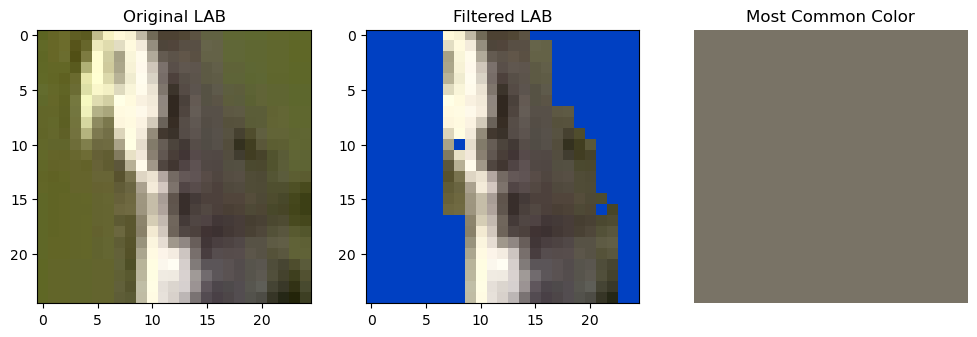

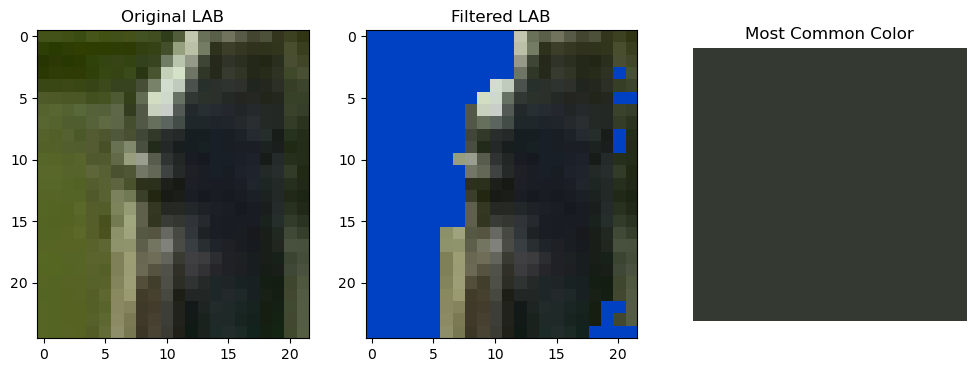

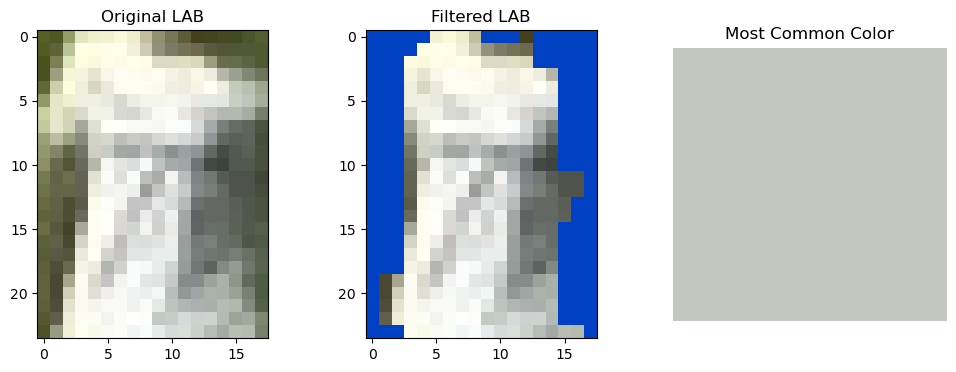

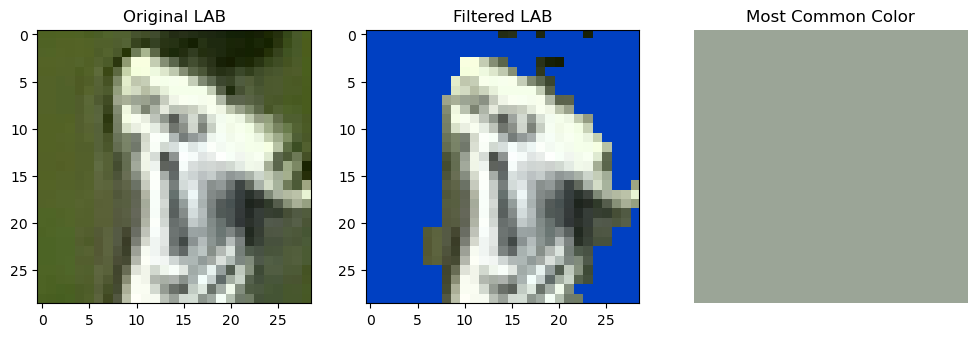

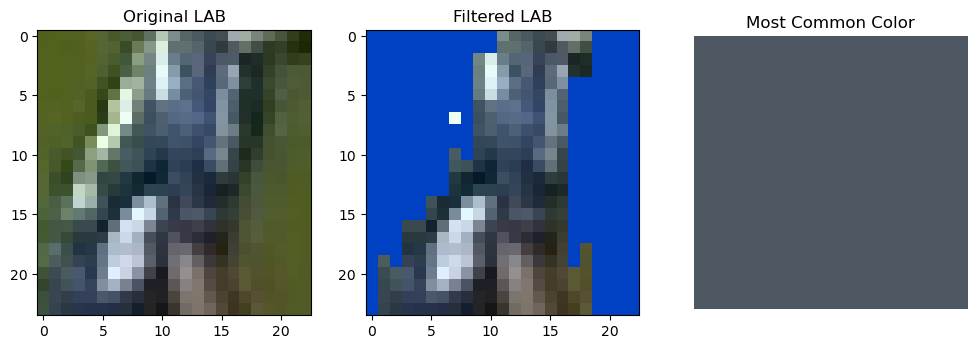

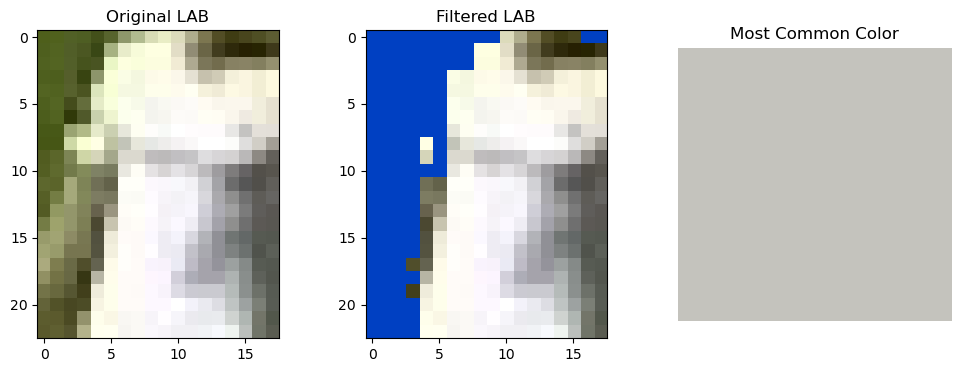

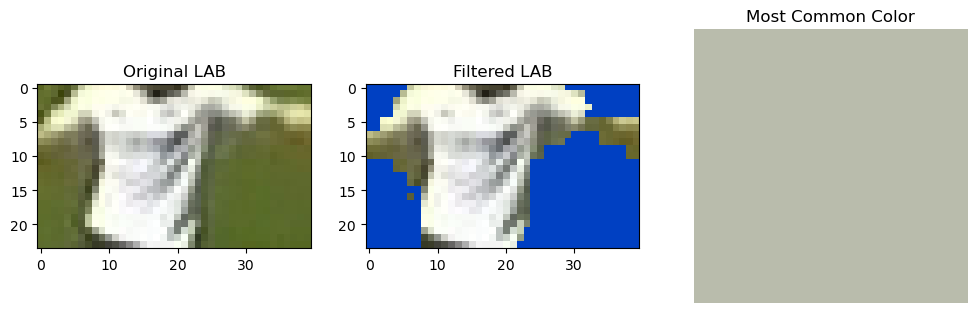

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1502696c0f70>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.5ms
Spe

16


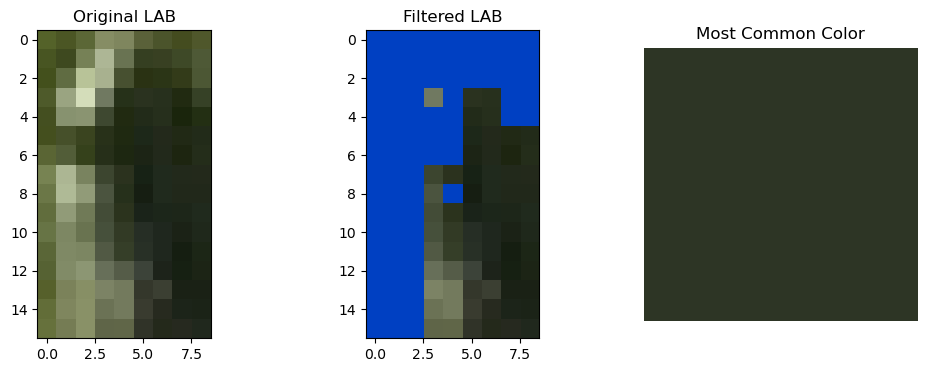

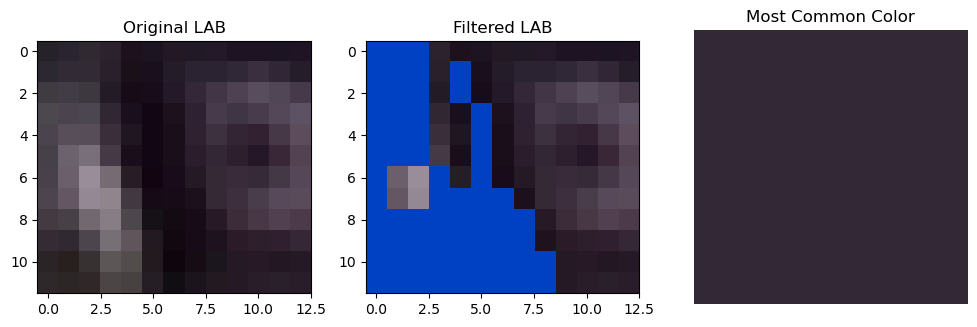

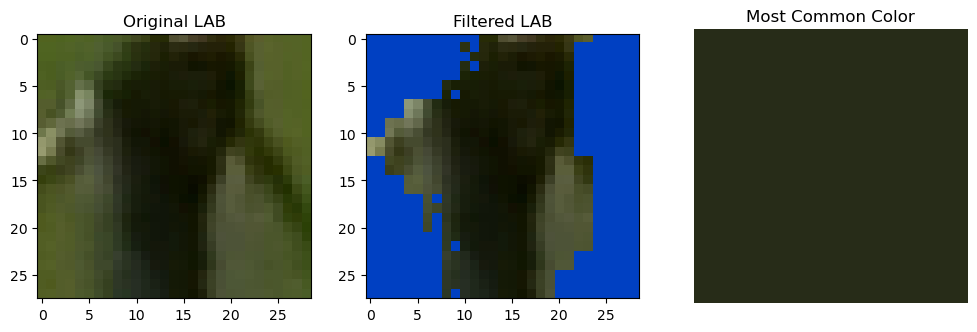

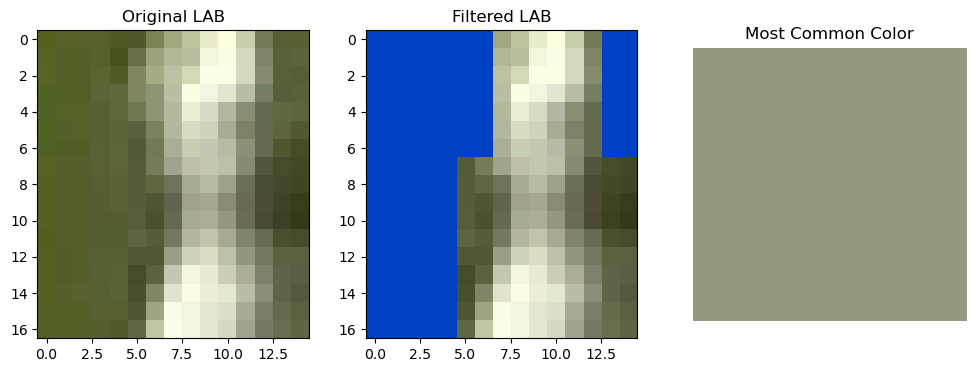

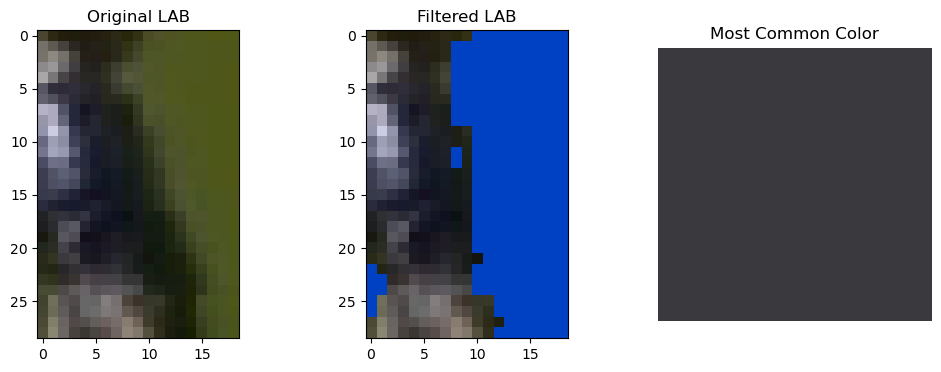

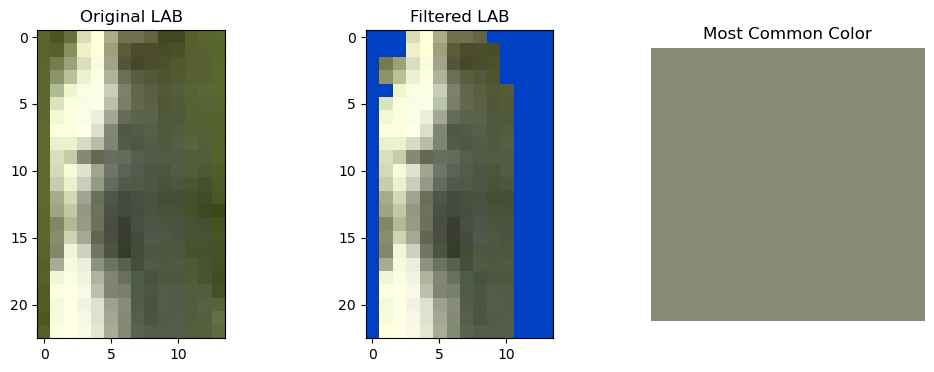

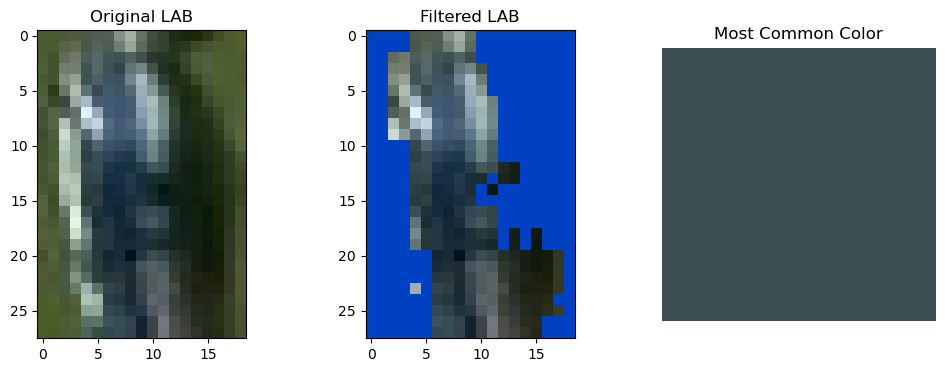

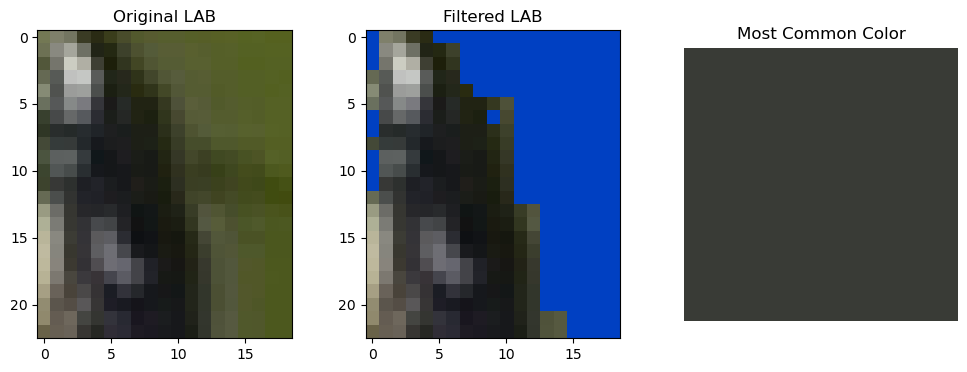

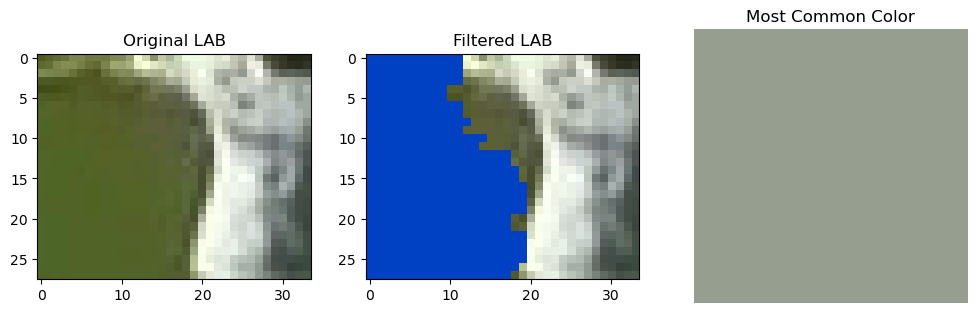

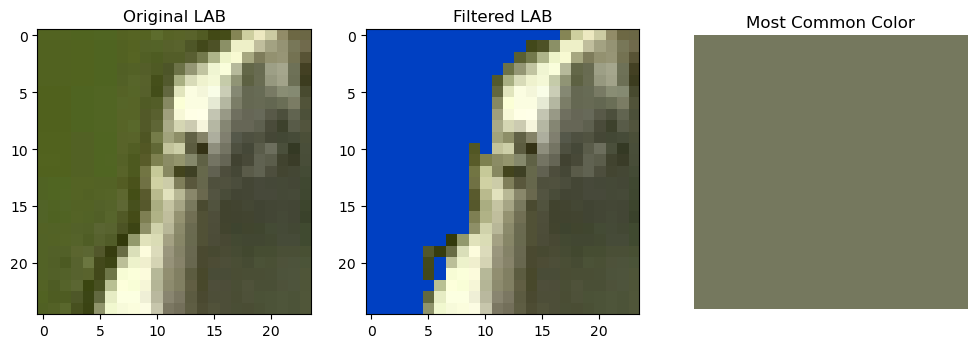

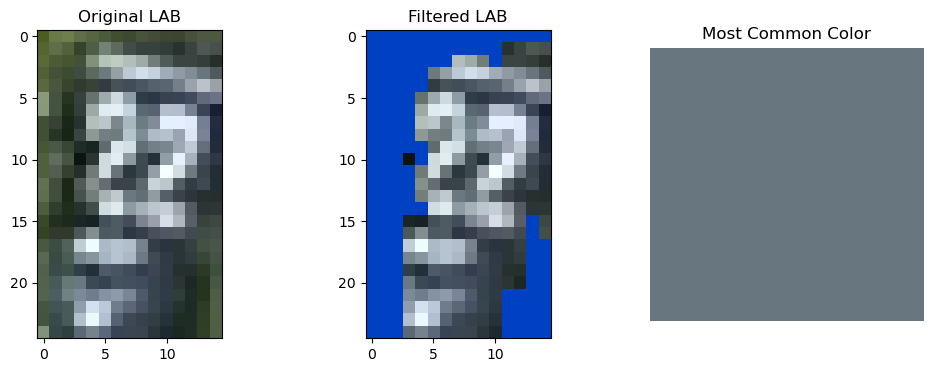

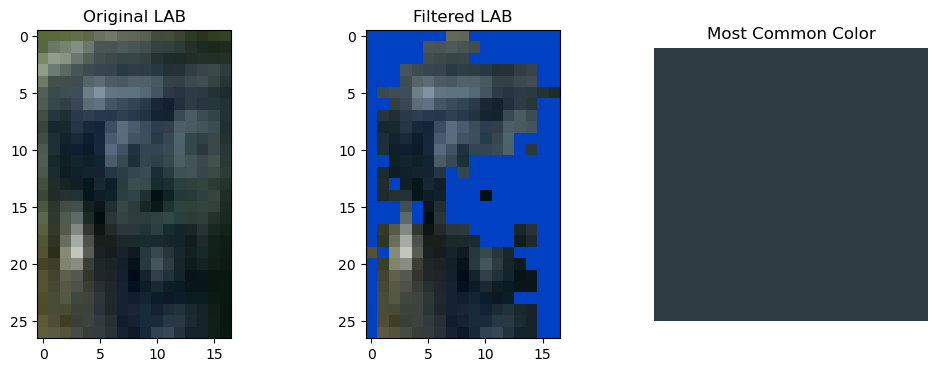

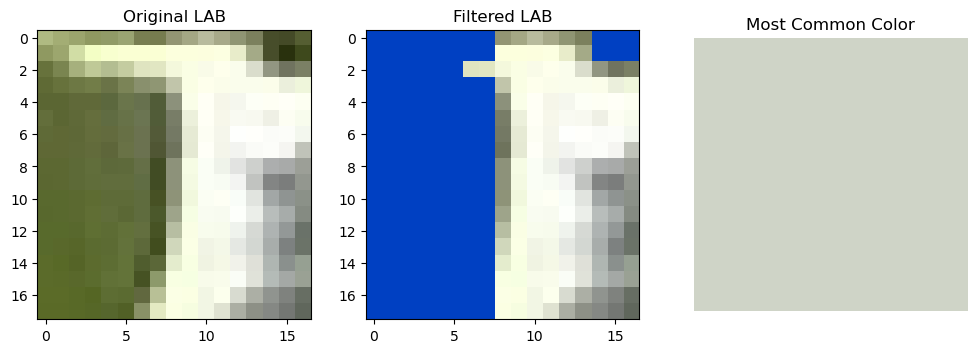

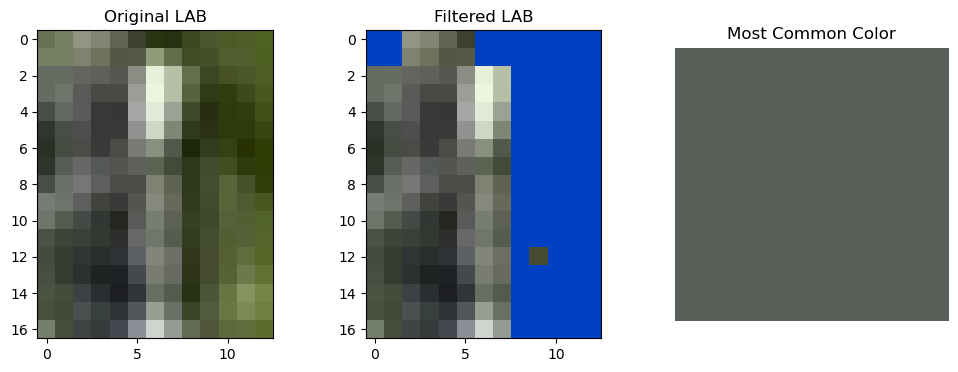

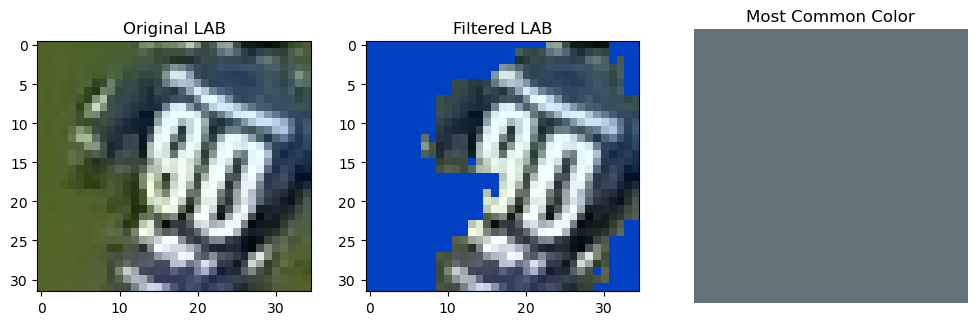

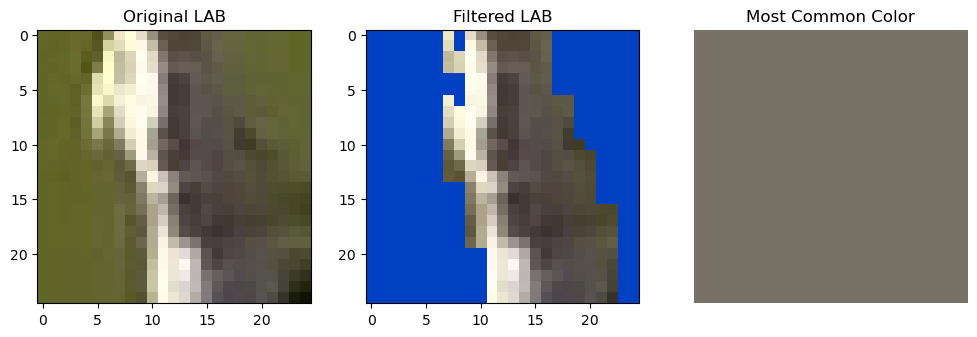

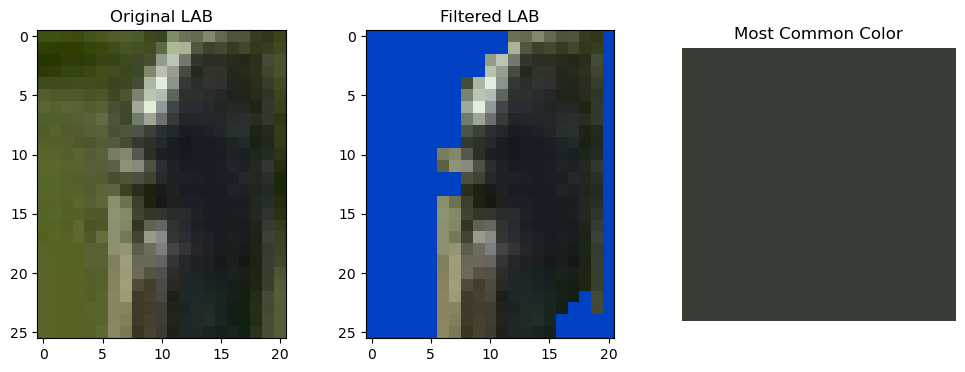

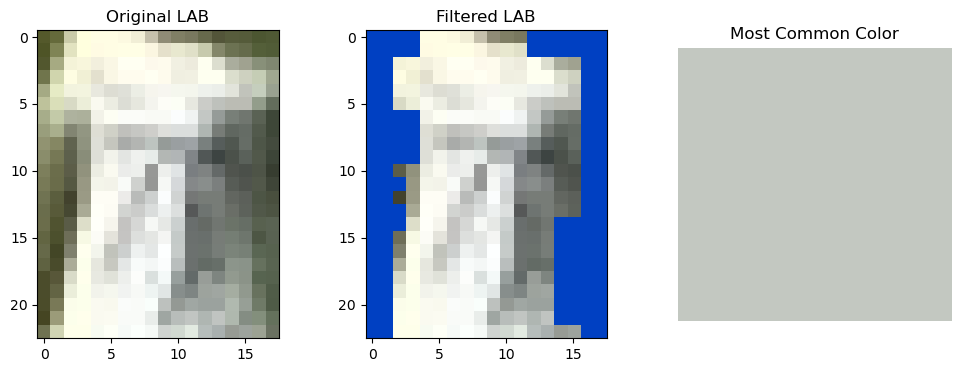

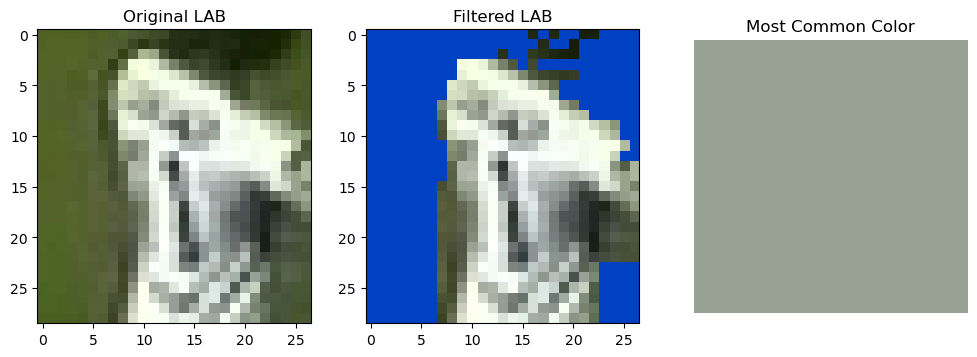

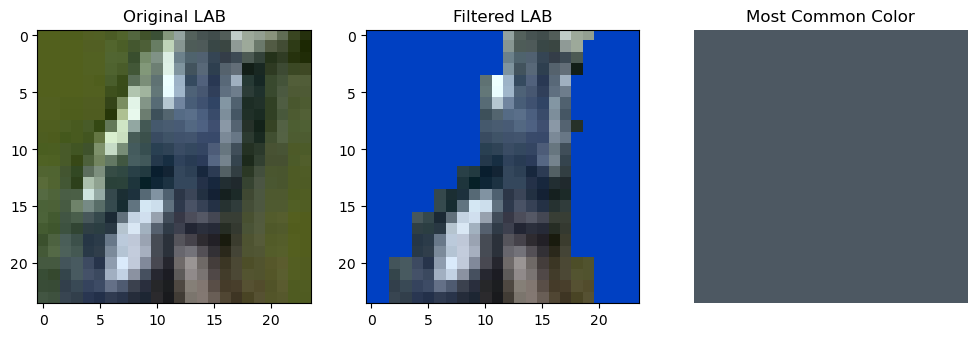

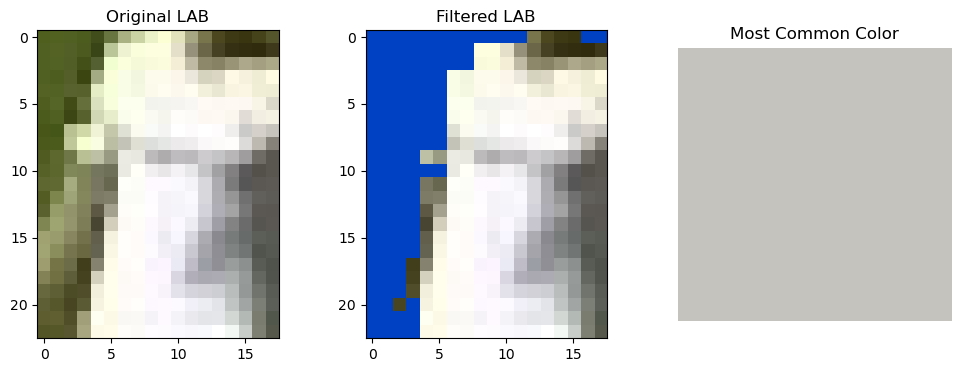

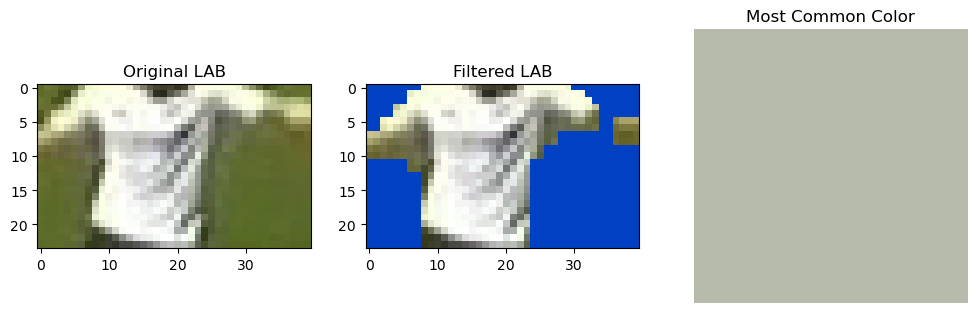

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1502696c0f70>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'

0: 1120x1984 1 ball, 22 players, 19.5ms
Spe

17


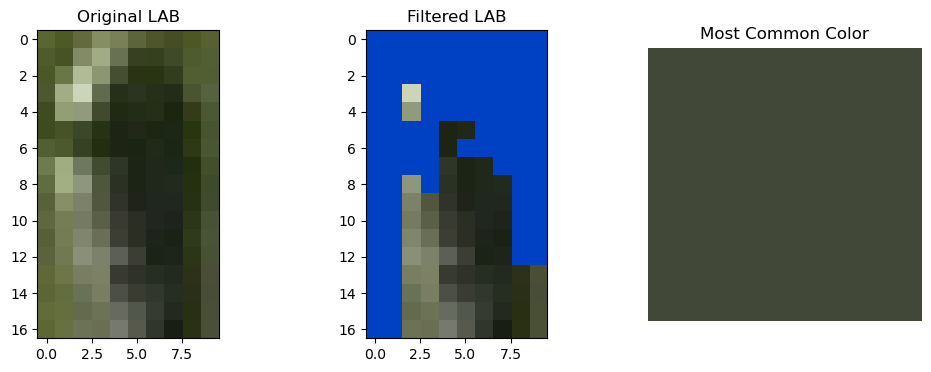

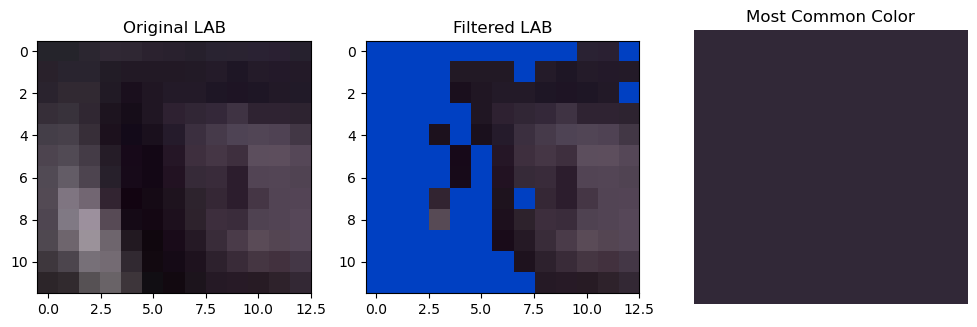

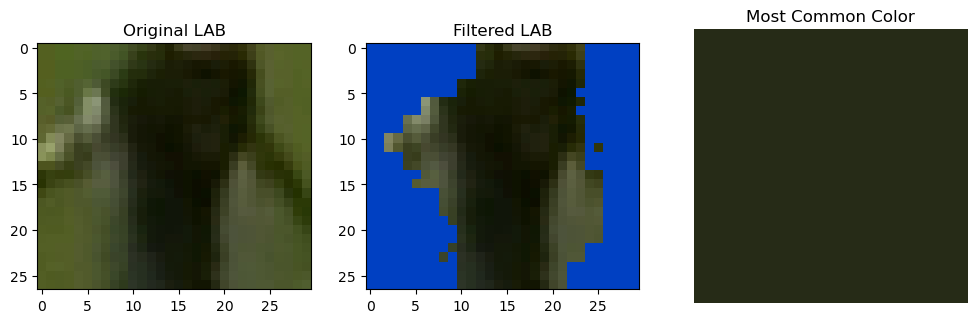

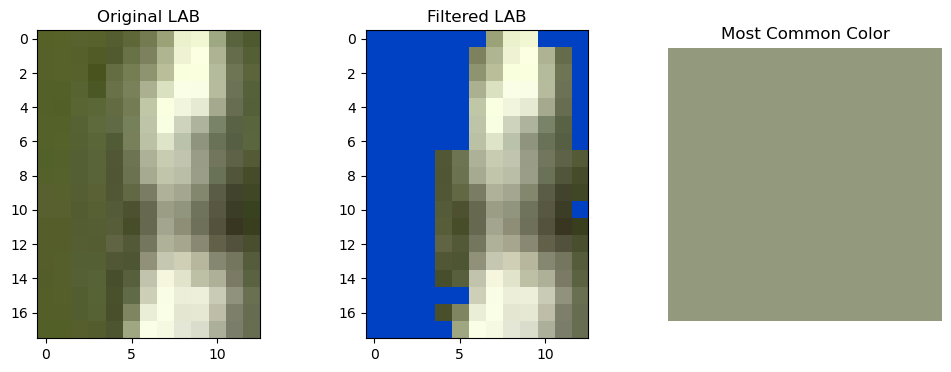

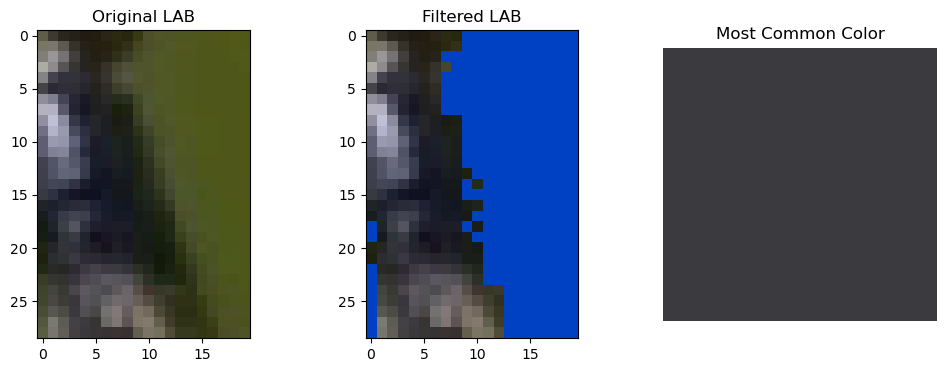

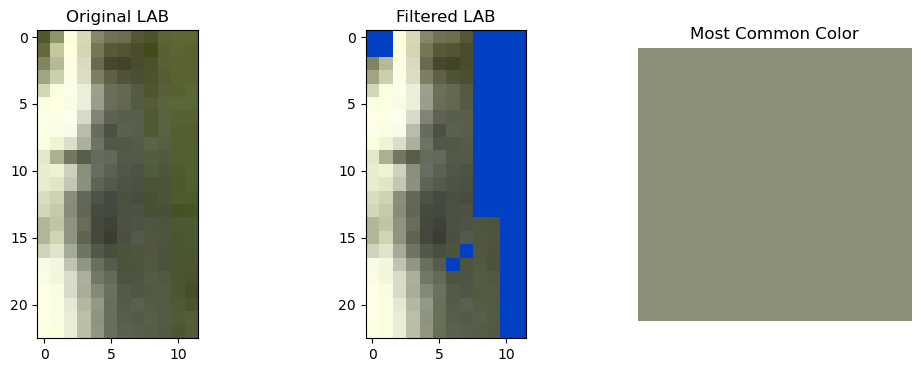

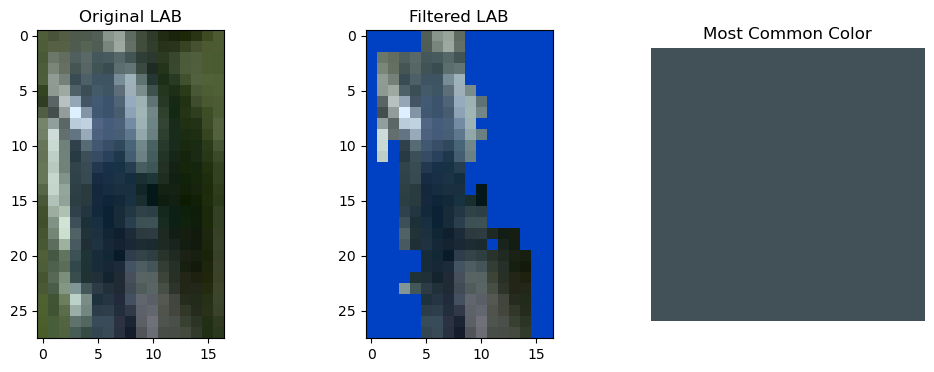

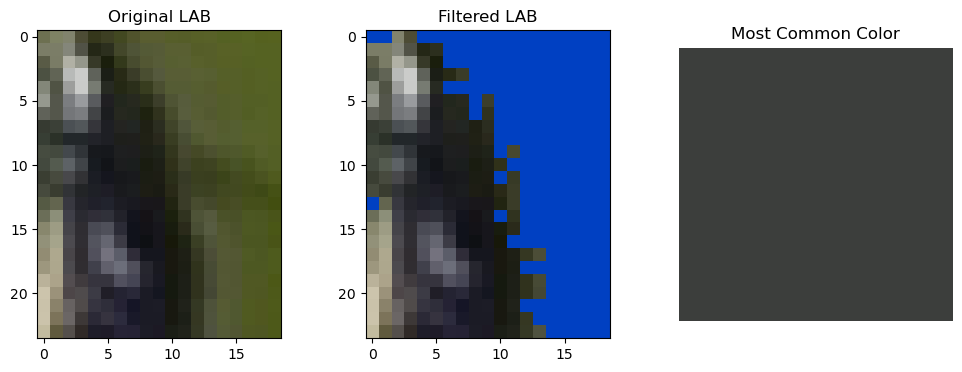

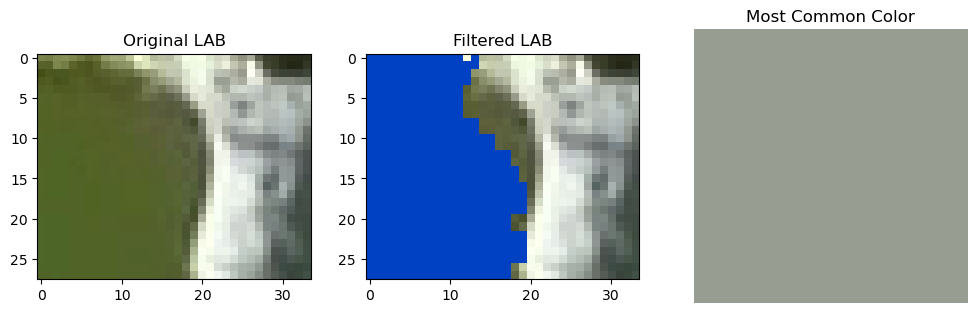

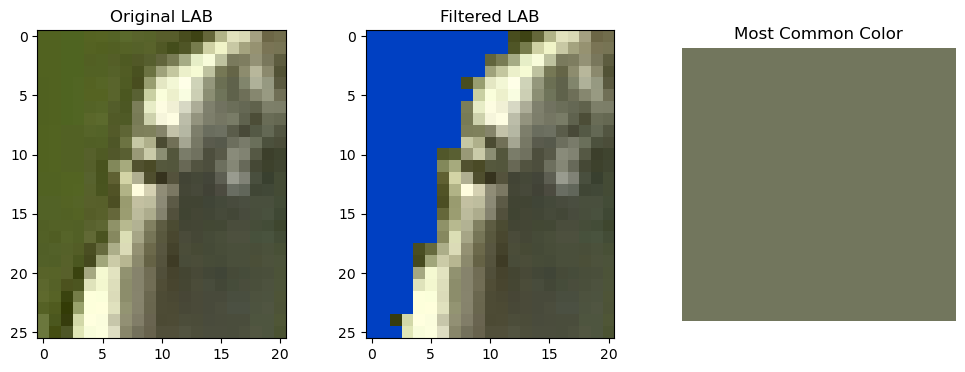

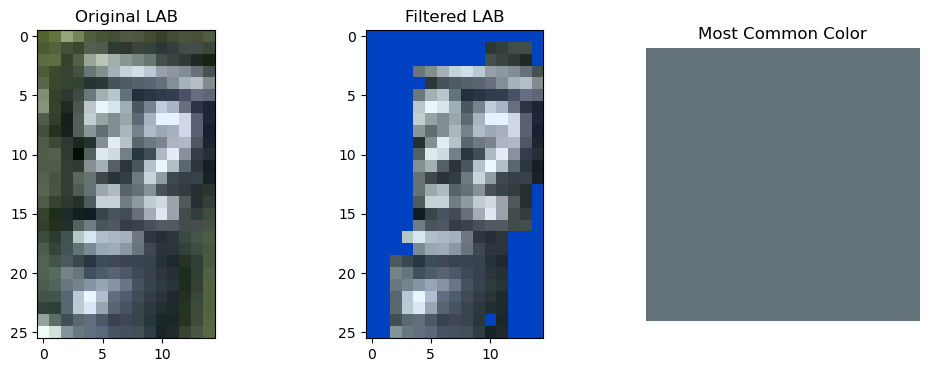

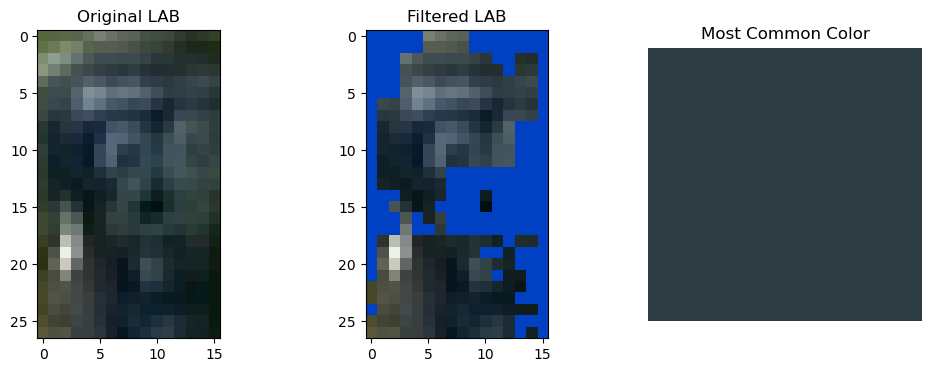

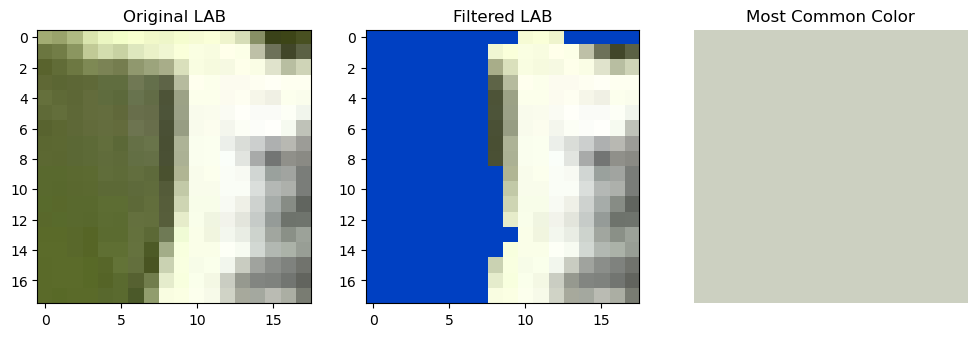

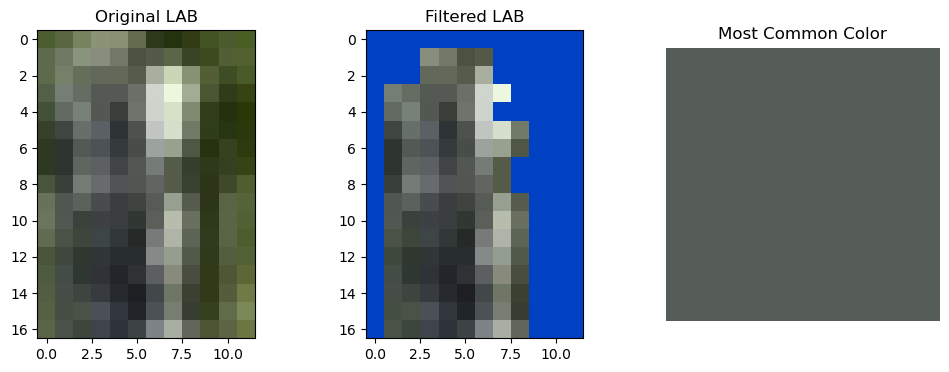

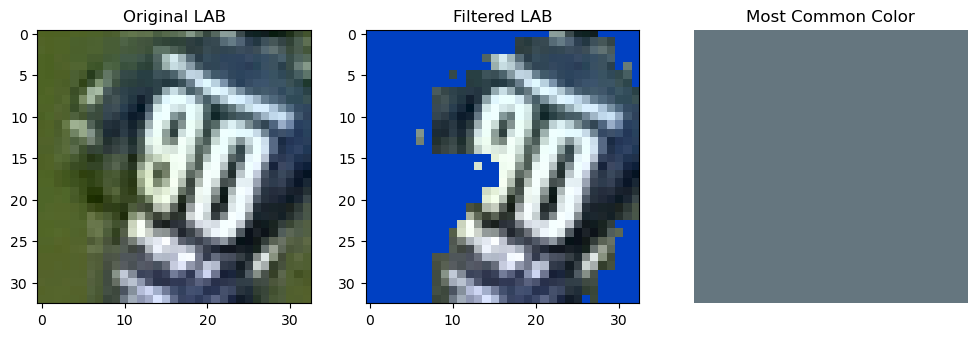

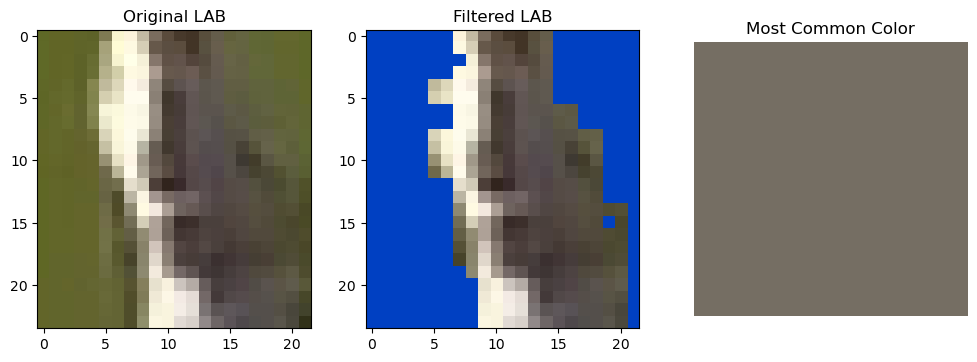

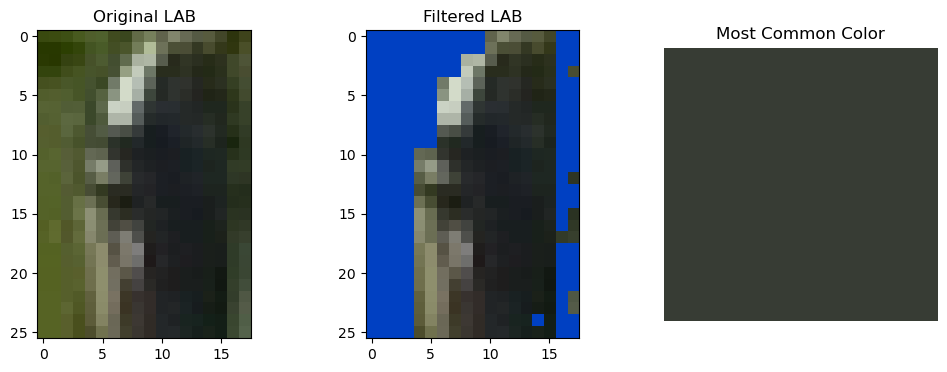

KeyboardInterrupt: 

In [79]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
model_weights = Path('osnet_x0_25_msmt17.pt')
yolo_model_path = 'runs/detect/NewDataset5008/weights/best.pt'
input_video_file = "2sec.mp4"
print(input_video_file.split(".")[0] + "_tracking1_output.mp4")
output_video_file = input_video_file.split(".")[0] + "_tracking1_output.mp4"

tracker = initialize_tracker(model_weights)
yolov8 = initialize_yolo(yolo_model_path)
process_video(input_video_file, output_video_file, tracker, yolov8)